<a href="https://colab.research.google.com/github/Arijitdutta19910601/Atmol4Cast-CNR/blob/main/Causalty_Based_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install pgmpy hmmlearn cartopy xarray openpyxl DateTime pandas numpy matplotlib keras scipy statsmodels arch pomegranate>=1.0.0

In [ ]:
! python3 -m pip install pgmpy hmmlearn seaborn cartopy xarray openpyxl DateTime pandas numpy matplotlib keras scipy statsmodels arch pomegranate>=1.0.0

In [ ]:
! pip3 install tensorflow


Defaulting to user installation because normal site-packages is not writeable


Granger Causality (For Multi-Variable Dependencies)

In [ ]:
import pandas as pd
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller

# Load CSV with Yeo-Johnson transformed columns
df = pd.read_csv('C:\\Users\\ariji\\Downloads\\ZephIR_Data_2015_2018_Yeo-Johnson_transformed - Copy.csv',
                 parse_dates=['Timestamp'], index_col='Timestamp')

wind_cols = [
    col for col in df.columns
    if col.endswith('_yj')
    or ('direction' in col and not col.endswith('_std'))
]

features = ['air_temperature', 'air_pressure',
            'humidity'] + wind_cols
df.index = pd.DatetimeIndex(df.index).to_period('10min')
df_selected = df[features].dropna()

In [ ]:
def check_adf(series):
    stat, p, _, _, crit, _ = adfuller(series)
    print(f'{series.name}: p={p:.3f}, stat={stat:.3f}, crit={crit}')

for col in df_selected.columns:
    check_adf(df_selected[col])

air_temperature: p=0.000, stat=-10.916, crit={'1%': np.float64(-3.4303908319793117), '5%': np.float64(-2.8615580471698405), '10%': np.float64(-2.566779605863977)}
air_pressure: p=0.000, stat=-16.162, crit={'1%': np.float64(-3.4303908319793117), '5%': np.float64(-2.8615580471698405), '10%': np.float64(-2.566779605863977)}
humidity: p=0.000, stat=-30.624, crit={'1%': np.float64(-3.4303908319793117), '5%': np.float64(-2.8615580471698405), '10%': np.float64(-2.566779605863977)}
h_1_wind_direction: p=0.000, stat=-27.366, crit={'1%': np.float64(-3.4303908319793117), '5%': np.float64(-2.8615580471698405), '10%': np.float64(-2.566779605863977)}
h_2_wind_direction: p=0.000, stat=-27.377, crit={'1%': np.float64(-3.4303908319793117), '5%': np.float64(-2.8615580471698405), '10%': np.float64(-2.566779605863977)}
h_3_wind_direction: p=0.000, stat=-27.601, crit={'1%': np.float64(-3.4303908317243548), '5%': np.float64(-2.8615580470571538), '10%': np.float64(-2.5667796058039976)}
h_4_wind_direction: p=

In [ ]:
df_selected = df_selected.dropna()

In [ ]:
print(df_selected.head())

                  air_temperature  air_pressure   humidity  \
Timestamp                                                    
2015-01-01 00:10             5.90   1014.000000  56.400002   
2015-01-01 00:20             5.55   1013.799988  58.790001   
2015-01-01 00:30             5.63   1014.200012  57.590000   
2015-01-01 00:40             5.53   1014.099976  59.790001   
2015-01-01 00:50             5.26   1014.000000  60.290001   

                  h_1_wind_direction  h_2_wind_direction  h_3_wind_direction  \
Timestamp                                                                      
2015-01-01 00:10          184.668777          169.334946          171.995071   
2015-01-01 00:20          201.106812          189.519730          175.395966   
2015-01-01 00:30          166.662628          188.703033          177.463348   
2015-01-01 00:40          204.806534          203.856033          196.466324   
2015-01-01 00:50          204.544022          203.941727          202.867188   

    

In [ ]:
model = VAR(df_selected)
lag_order = model.select_order(maxlags=72)
print(lag_order.summary())
best_lag = lag_order.bic  # or bic/hqic
var_res = model.fit(best_lag)

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        54.72       54.72   5.817e+23       54.72
1        25.95       25.99   1.857e+11       25.96
2        25.61       25.69   1.321e+11       25.63
3        25.51       25.63   1.203e+11       25.55
4        25.47      25.63*   1.152e+11       25.52
5        25.44       25.64   1.123e+11       25.50
6        25.43       25.66   1.105e+11      25.50*
7        25.42       25.69   1.093e+11       25.50
8        25.41       25.72   1.084e+11       25.50
9        25.40       25.75   1.076e+11       25.51
10       25.40       25.79   1.071e+11       25.51
11       25.39       25.82   1.067e+11       25.52
12       25.39       25.86   1.062e+11       25.53
13       25.39       25.90   1.061e+11       25.54
14       25.38       25.93   1.058e+11       25.55
15       25.38       25.97   1.056e+11       25.56
16       25.38       26.01   1.

In [ ]:
def granger_matrix(df, maxlag=4):
    # Separate target and input variables
    caused_vars = [col for col in df.columns if col.endswith('_yj')]
    causing_vars = [col for col in df.columns if not col.endswith('_yj')]

    # Fit VAR model once on the whole dataset
    model = VAR(df)
    var_res = model.fit(maxlags=maxlag, ic='bic')

    # Initialize results matrix
    mat = pd.DataFrame(index=caused_vars, columns=causing_vars)

    # Perform causality tests in a memory-friendly way
    for caused in caused_vars:
        for causing in causing_vars:
            if caused == causing:
                mat.loc[caused, causing] = None
                continue
            try:
                test = var_res.test_causality(caused=caused, causing=causing, kind='f')
                mat.loc[caused, causing] = test.pvalue
            except Exception as e:
                mat.loc[caused, causing] = None  # Log failure gracefully

    return mat


# Run with filtered influence set
gc_results = granger_matrix(df_selected, 4)
print(gc_results)

                                      air_temperature air_pressure  humidity  \
Horizontal_speed_300 m_transformed_yj             0.0          0.0       0.0   
Horizontal_speed_250 m_transformed_yj             0.0          0.0       0.0   
Horizontal_speed_200 m_transformed_yj             0.0          0.0       0.0   
Horizontal_speed_150 m_transformed_yj             0.0          0.0       0.0   
Horizontal_speed_120 m_transformed_yj             0.0          0.0       0.0   
Horizontal_speed_100 m_transformed_yj             0.0          0.0       0.0   
Horizontal_speed_80 m_transformed_yj              0.0          0.0       0.0   
Horizontal_speed_60 m_transformed_yj              0.0          0.0       0.0   
Horizontal_speed_20 m_transformed_yj              0.0          0.0       0.0   
Horizontal_speed_10 m_transformed_yj              0.0          0.0       0.0   
Horizontal_speed_38 m_transformed_yj              0.0          0.0  0.000201   

                                      h

In [ ]:
# Filter target variables ending with '_yj' or are the original speed columns
# Assuming you want to rank influences on the original wind speeds and their YJ transformations
# Let's refine this to just look at the transformed speed columns as targets
yj_targets = [col for col in gc_results.index if '_yj' in col or 'Horizontal_speed' in col]

# Dictionary to store ranked influences for each target
rankings = {}

# Iterate through the index (caused variables) of gc_results
for target in yj_targets:
    # Check if the target is actually in the index of gc_results
    if target in gc_results.index:
        # Access the row corresponding to the target using .loc
        influences = gc_results.loc[target].dropna()
        ranked = influences.sort_values()
        rankings[target] = ranked
    else:
        print(f"Warning: Target '{target}' not found in the index of gc_results.")


# Display top influencers per target (using a more reasonable p-value threshold)
p_value_threshold = 0.00 # Common significance level

for target, ranked in rankings.items():
    print(f"\nTop influences on {target}:")
    # Show influencers with p < p_value_threshold
    significant_influences = ranked[ranked > p_value_threshold]
    if not significant_influences.empty:
        print(significant_influences)
    else:
        print("No significant influences found at the specified threshold.")


Top influences on Horizontal_speed_300 m_transformed_yj:
air_temperature             0.0
air_pressure                0.0
humidity                    0.0
h_2_wind_direction     0.000002
h_8_wind_direction     0.001122
h_6_wind_direction      0.05933
h_7_wind_direction     0.123658
h_11_wind_direction    0.141247
h_5_wind_direction     0.185455
h_10_wind_direction    0.221831
h_4_wind_direction      0.27376
h_3_wind_direction     0.312991
h_1_wind_direction     0.458387
h_9_wind_direction     0.921218
Name: Horizontal_speed_300 m_transformed_yj, dtype: object

Top influences on Horizontal_speed_250 m_transformed_yj:
air_temperature             0.0
air_pressure                0.0
humidity                    0.0
h_2_wind_direction          0.0
h_8_wind_direction      0.00264
h_6_wind_direction     0.033754
h_10_wind_direction    0.095305
h_3_wind_direction       0.1154
h_4_wind_direction     0.354403
h_7_wind_direction     0.455595
h_5_wind_direction     0.568299
h_11_wind_direction    0.

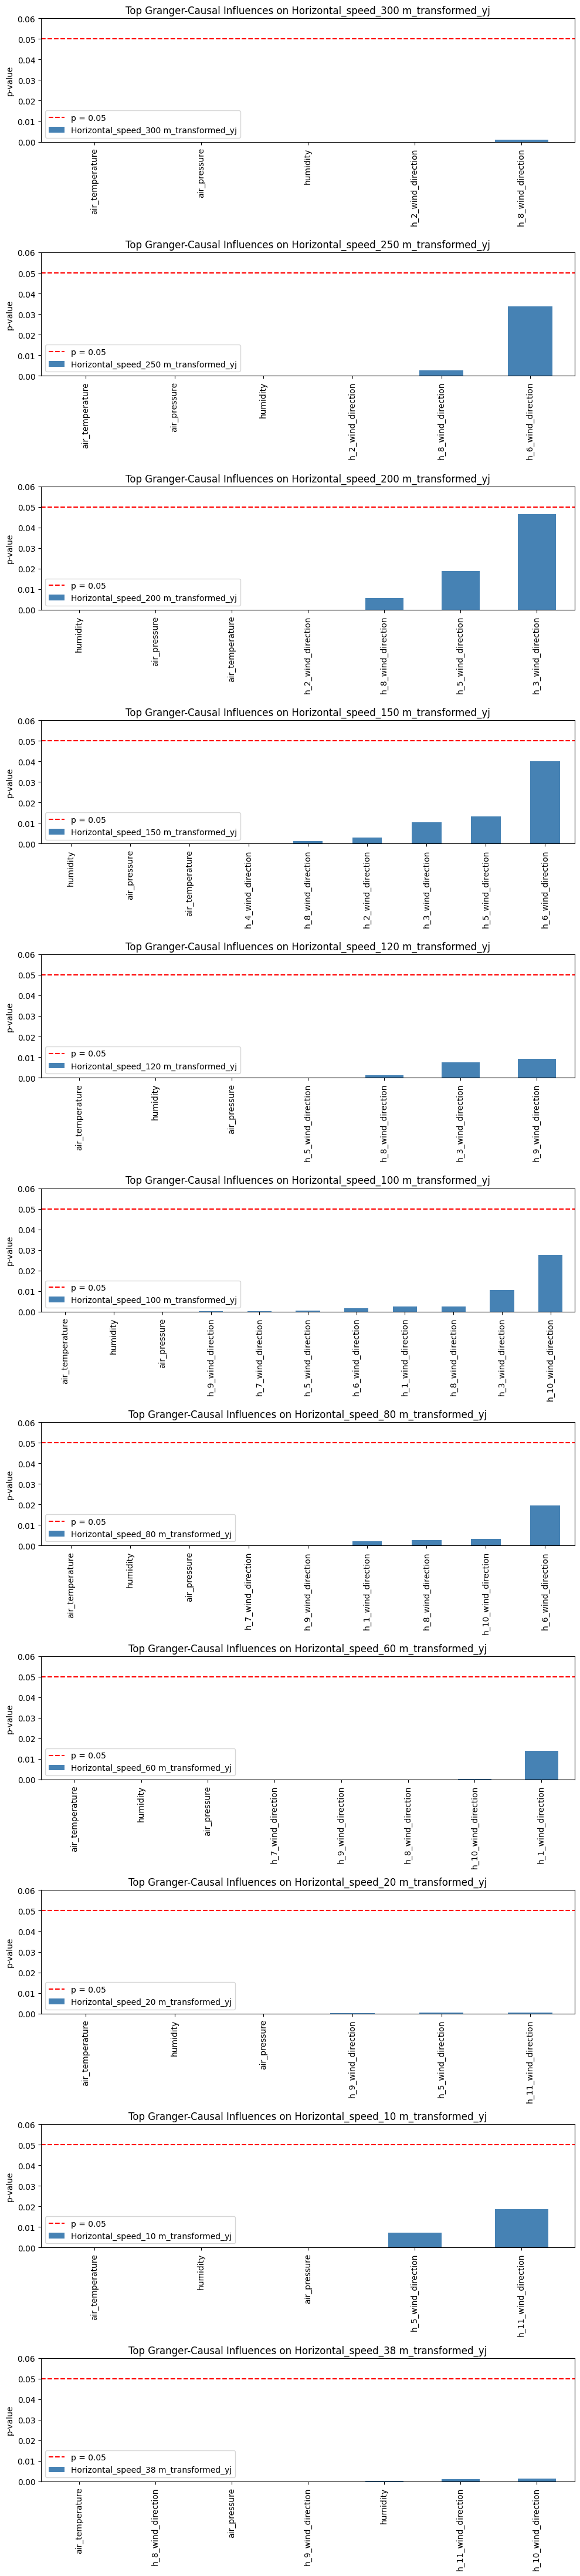

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd # Import pandas to create a DataFrame

# Set figure size dynamically based on number of targets
n_targets = len(rankings)
fig, axes = plt.subplots(n_targets, 1, figsize=(10, 4 * n_targets))

if n_targets == 1:
    axes = [axes]  # make iterable if only one plot

# Plot for each target
for ax, (target, ranked) in zip(axes, rankings.items()):
    significant = ranked[ranked < 0.05]
    if significant.empty:
        ax.set_title(f"{target} (no significant influencers)")
        ax.axis('off')
        continue

    significant.plot(kind='bar', ax=ax, color='steelblue')
    ax.set_title(f"Top Granger-Causal Influences on {target}")
    ax.set_ylabel("p-value")
    ax.axhline(0.05, color='red', linestyle='--', label='p = 0.05')
    ax.legend()
    ax.set_ylim(0, 0.06)

# --- FIX START ---
# Convert the 'rankings' dictionary to a pandas DataFrame before saving to CSV.
# Assuming 'rankings' is a dictionary where keys are targets and values are pandas Series (ranked).
# We can concatenate these Series into a single DataFrame or structure it as needed.
# For a cleaner CSV, let's convert each Series in the dictionary to a column in a DataFrame.

# Create an empty dictionary to hold the data for the new DataFrame
data_for_df = {}
for target, ranked_series in rankings.items():
    data_for_df[target] = ranked_series

# Convert the dictionary of Series to a DataFrame
rankings_df = pd.DataFrame(data_for_df)

# Save the DataFrame to CSV
rankings_df.to_csv('C:\\Users\\ariji\\Downloads\\granger_causality_results_rankings.csv')
# --- FIX END ---

plt.tight_layout()
plt.show()

HMM+Granger for Regime switch

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from hmmlearn.hmm import GaussianHMM
from statsmodels.tsa.vector_ar.var_model import VAR
import os
import gc

# Step 1: Train HMM on the selected features
n_states = 3  # adjust as needed
# Scale the data
scaler = StandardScaler()
scaled = scaler.fit_transform(df_selected.dropna().values)
pca = PCA(n_components=5)
hmm_data = pca.fit_transform(scaled)

# Fit a simpler HMM
hmm = GaussianHMM(n_components=n_states,
    covariance_type='full',
    n_iter=1000,         # Increase iterations
    tol=1e-3,            # Set a convergence tolerance
    random_state=42,
    verbose=True)

hmm.fit(hmm_data)

df_selected['regime'] = hmm.predict(hmm_data)

# Step 3: Granger causality per regime
def granger_matrix_hmm(df, regime_col='regime', maxlag=4):
    regimes = df[regime_col].unique()
    results = {}

    for reg in regimes:
        sub_df = df[df[regime_col] == reg].drop(columns=[regime_col])
        model = VAR(sub_df)
        var_res = model.fit(maxlags=maxlag, ic='bic')

        variables = sub_df.columns
        causing_vars = [col for col in variables if not col.endswith('_yj')]
        targets = [col for col in variables if col.endswith('_yj')]

        mat = pd.DataFrame(index=targets, columns=causing_vars)

        for caused in targets:
            for causing in causing_vars:
                if caused == causing:
                    mat.loc[caused, causing] = None
                    continue
                try:
                    test = var_res.test_causality(caused=caused, causing=causing, kind='f')
                    mat.loc[caused, causing] = test.pvalue
                except Exception as e:
                    mat.loc[caused, causing] = np.nan  # Handle potential test failure
        results[f'regime_{reg}'] = mat
    return results

# Run regime-specific Granger causality
gc_regime_results = granger_matrix_hmm(df_selected)

output_directory_granger = 'C:\\Users\\ariji\\Downloads\\granger_causality_regime_results'
os.makedirs(output_directory_granger, exist_ok=True)
print(f"\nSaving Granger causality results to: {output_directory_granger}")

for regime_key, granger_matrix_content in gc_regime_results.items():
    # Only save if the content is actually a DataFrame (i.e., not an error message)
    if isinstance(granger_matrix_content, pd.DataFrame):
        file_path = os.path.join(output_directory_granger, f'{regime_key}.csv')
        granger_matrix_content.to_csv(file_path)
        print(f"  Saved {regime_key} to {file_path}")
    else:
        print(f"  Skipping save for {regime_key}: {granger_matrix_content}")

print("Granger causality results saving complete.")
gc.collect() # Force garbage collection after saving

# Step 4: Display top influencers for each regime
p_value_threshold = 0.05
for regime, mat in gc_regime_results.items():
    print(f"\n=== {regime.upper()} ===")
    for target in mat.index:
        influences = mat.loc[target].dropna().sort_values()
        sig_influences = influences[influences < p_value_threshold]
        if not sig_influences.empty:
            print(f"\nTop influences on {target}:")
            print(sig_influences)
        else:
            print(f"\nNo significant influences found for {target}")

         1 -1565252.40344602             +nan
         2 -1345861.87652284 +219390.52692318
         3 -1335363.08657310  +10498.78994973
         4 -1334343.99165242   +1019.09492068
         5 -1333996.53926041    +347.45239201
         6 -1333815.72300162    +180.81625879
         7 -1333709.38085555    +106.34214607
         8 -1333640.22428190     +69.15657366
         9 -1333595.69213366     +44.53214824
        10 -1333565.69951210     +29.99262156
        11 -1333543.70531236     +21.99419974
        12 -1333526.30988244     +17.39542993
        13 -1333511.27614556     +15.03373687
        14 -1333497.41477347     +13.86137209
        15 -1333485.23195994     +12.18281353
        16 -1333475.11866067     +10.11329927
        17 -1333466.84749793      +8.27116274
        18 -1333460.07038046      +6.77711747
        19 -1333454.46403731      +5.60634315
        20 -1333449.77581384      +4.68822348
        21 -1333445.81719774      +3.95861609
        22 -1333442.44053060      


Saving Granger causality results to: C:\Users\ariji\Downloads\granger_causality_regime_results
  Saved regime_1 to C:\Users\ariji\Downloads\granger_causality_regime_results\regime_1.csv
  Saved regime_0 to C:\Users\ariji\Downloads\granger_causality_regime_results\regime_0.csv
  Saved regime_2 to C:\Users\ariji\Downloads\granger_causality_regime_results\regime_2.csv
Granger causality results saving complete.

=== REGIME_1 ===

Top influences on Horizontal_speed_300 m_transformed_yj:
air_temperature             0.0
air_pressure                0.0
humidity                    0.0
h_8_wind_direction     0.002217
h_4_wind_direction     0.004438
h_10_wind_direction    0.004466
h_1_wind_direction     0.014684
h_9_wind_direction     0.035233
Name: Horizontal_speed_300 m_transformed_yj, dtype: object

Top influences on Horizontal_speed_250 m_transformed_yj:
air_temperature             0.0
air_pressure                0.0
humidity                    0.0
h_8_wind_direction     0.001504
h_10_wind_d

In [ ]:
df_selected.to_csv('C:\\Users\\ariji\\Downloads\\ZephIR_Data_2015_2018_Yeo-Johnson_transformed_with_regimes.csv')

In [ ]:
df_selected= pd.read_csv('C:\\Users\\ariji\\Downloads\\ZephIR_Data_2015_2018_Yeo-Johnson_transformed_with_regimes.csv')

In [ ]:
print("Granger causality analysis completed for all regimes.")
print(df_selected.head())

Granger causality analysis completed for all regimes.
          Timestamp  air_temperature  air_pressure   humidity  \
0  2015-01-01 00:10             5.90   1014.000000  56.400002   
1  2015-01-01 00:20             5.55   1013.799988  58.790001   
2  2015-01-01 00:30             5.63   1014.200012  57.590000   
3  2015-01-01 00:40             5.53   1014.099976  59.790001   
4  2015-01-01 00:50             5.26   1014.000000  60.290001   

   h_1_wind_direction  h_2_wind_direction  h_3_wind_direction  \
0          184.668777          169.334946          171.995071   
1          201.106812          189.519730          175.395966   
2          166.662628          188.703033          177.463348   
3          204.806534          203.856033          196.466324   
4          204.544022          203.941727          202.867188   

   h_4_wind_direction  h_5_wind_direction  h_6_wind_direction  ...  \
0          192.466354          207.185211          201.681946  ...   
1          262.580536   

In [ ]:
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM
from sklearn.decomposition import PCA
from statsmodels.tsa.vector_ar.var_model import VAR

# Step 1: Train HMM on the selected features
n_states = 3  # adjust as needed
# Scale the data
scaler = StandardScaler()
scaled = scaler.fit_transform(df_selected.dropna().values)
pca = PCA(n_components=5)
hmm_data = pca.fit_transform(scaled)

# Fit a simpler HMM
hmm = GaussianHMM(n_components=n_states,
    covariance_type='diag',
    n_iter=1000,         # Increase iterations
    tol=1e-3,            # Set a convergence tolerance
    random_state=42,
    verbose=True)

hmm.fit(hmm_data)

# Step 2: Predict latent states (regimes)
df_selected['regime'] = hmm.predict(hmm_data)

# Step 3: Granger causality per regime
def granger_matrix_hmm(df, regime_col='regime', maxlag=26):
    regimes = df[regime_col].unique()
    results = {}

    for reg in regimes:
        sub_df = df[df[regime_col] == reg].drop(columns=[regime_col])

        if sub_df.shape[0] <= maxlag + 2:
            print(f"Skipping regime {reg} (insufficient data points)")
            continue

        model = VAR(sub_df)
        try:
            var_res = model.fit(maxlags=8, ic='hqic')
        except Exception as e:
            print(f"Failed to fit VAR for regime {reg}: {e}")
            continue

        variables = sub_df.columns
        causing_vars = [col for col in variables if not col.endswith('_yj')]
        targets = [col for col in variables if col.endswith('_yj')]

        mat = pd.DataFrame(index=targets, columns=causing_vars)

        for caused in targets:
            for causing in causing_vars:
                if caused == causing:
                    mat.loc[caused, causing] = None
                    continue
                try:
                    test = var_res.test_causality(caused=caused, causing=causing, kind='f')
                    mat.loc[caused, causing] = test.pvalue
                except Exception as e:
                    mat.loc[caused, causing] = np.nan
        results[f'regime_{reg}'] = mat
    return results

# Run regime-specific Granger causality
gc_regime_results = granger_matrix_hmm(df_selected)

# Step 4: Display top influencers per target for each regime
p_value_threshold = 0.05

for regime, mat in gc_regime_results.items():
    print(f"\n=== {regime.upper()} ===")
    for target in mat.index:
        influences = mat.loc[target].dropna().sort_values()
        sig_influences = influences[influences < p_value_threshold]
        if not sig_influences.empty:
            print(f"\nTop influences on {target}:")
            print(sig_influences)
        else:
            print(f"\nNo significant influences found for {target}")

         1 -1567277.13866986             +nan
         2 -1374451.81052399 +192825.32814587
         3 -1135927.25665386 +238524.55387013
         4 -1106572.50271132  +29354.75394254
         5 -1100818.93894376   +5753.56376756
         6 -1098011.29021663   +2807.64872713
         7 -1095683.39101983   +2327.89919680
         8 -1092021.26276359   +3662.12825623
         9 -1084899.56704143   +7121.69572216
        10 -1073498.65488593  +11400.91215550
        11 -1060466.03469196  +13032.62019396
        12 -1052973.04227496   +7492.99241701
        13 -1049866.30380348   +3106.73847147
        14 -1048334.69294589   +1531.61085760
        15 -1047391.87193019    +942.82101570
        16 -1046750.36572698    +641.50620321
        17 -1046300.69177705    +449.67394993
        18 -1045983.15229348    +317.53948357
        19 -1045758.42849137    +224.72380211
        20 -1045598.80102247    +159.62746891
        21 -1045484.64625519    +114.15476728
        22 -1045402.30242809     +


=== REGIME_0 ===

No significant influences found for Horizontal_speed_300 m_transformed_yj

No significant influences found for Horizontal_speed_250 m_transformed_yj

No significant influences found for Horizontal_speed_200 m_transformed_yj

Top influences on Horizontal_speed_150 m_transformed_yj:
air_pressure    0.015225
Name: Horizontal_speed_150 m_transformed_yj, dtype: object

Top influences on Horizontal_speed_120 m_transformed_yj:
air_pressure       0.016518
air_temperature    0.033506
Name: Horizontal_speed_120 m_transformed_yj, dtype: object

Top influences on Horizontal_speed_100 m_transformed_yj:
air_temperature    0.003708
Name: Horizontal_speed_100 m_transformed_yj, dtype: object

Top influences on Horizontal_speed_80 m_transformed_yj:
air_temperature       0.000007
h_7_wind_direction    0.048284
Name: Horizontal_speed_80 m_transformed_yj, dtype: object

Top influences on Horizontal_speed_60 m_transformed_yj:
air_temperature             0.0
h_10_wind_direction    0.015921

C:\Users\ariji\AppData\Local\Temp\ipykernel_17484\2340888867.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


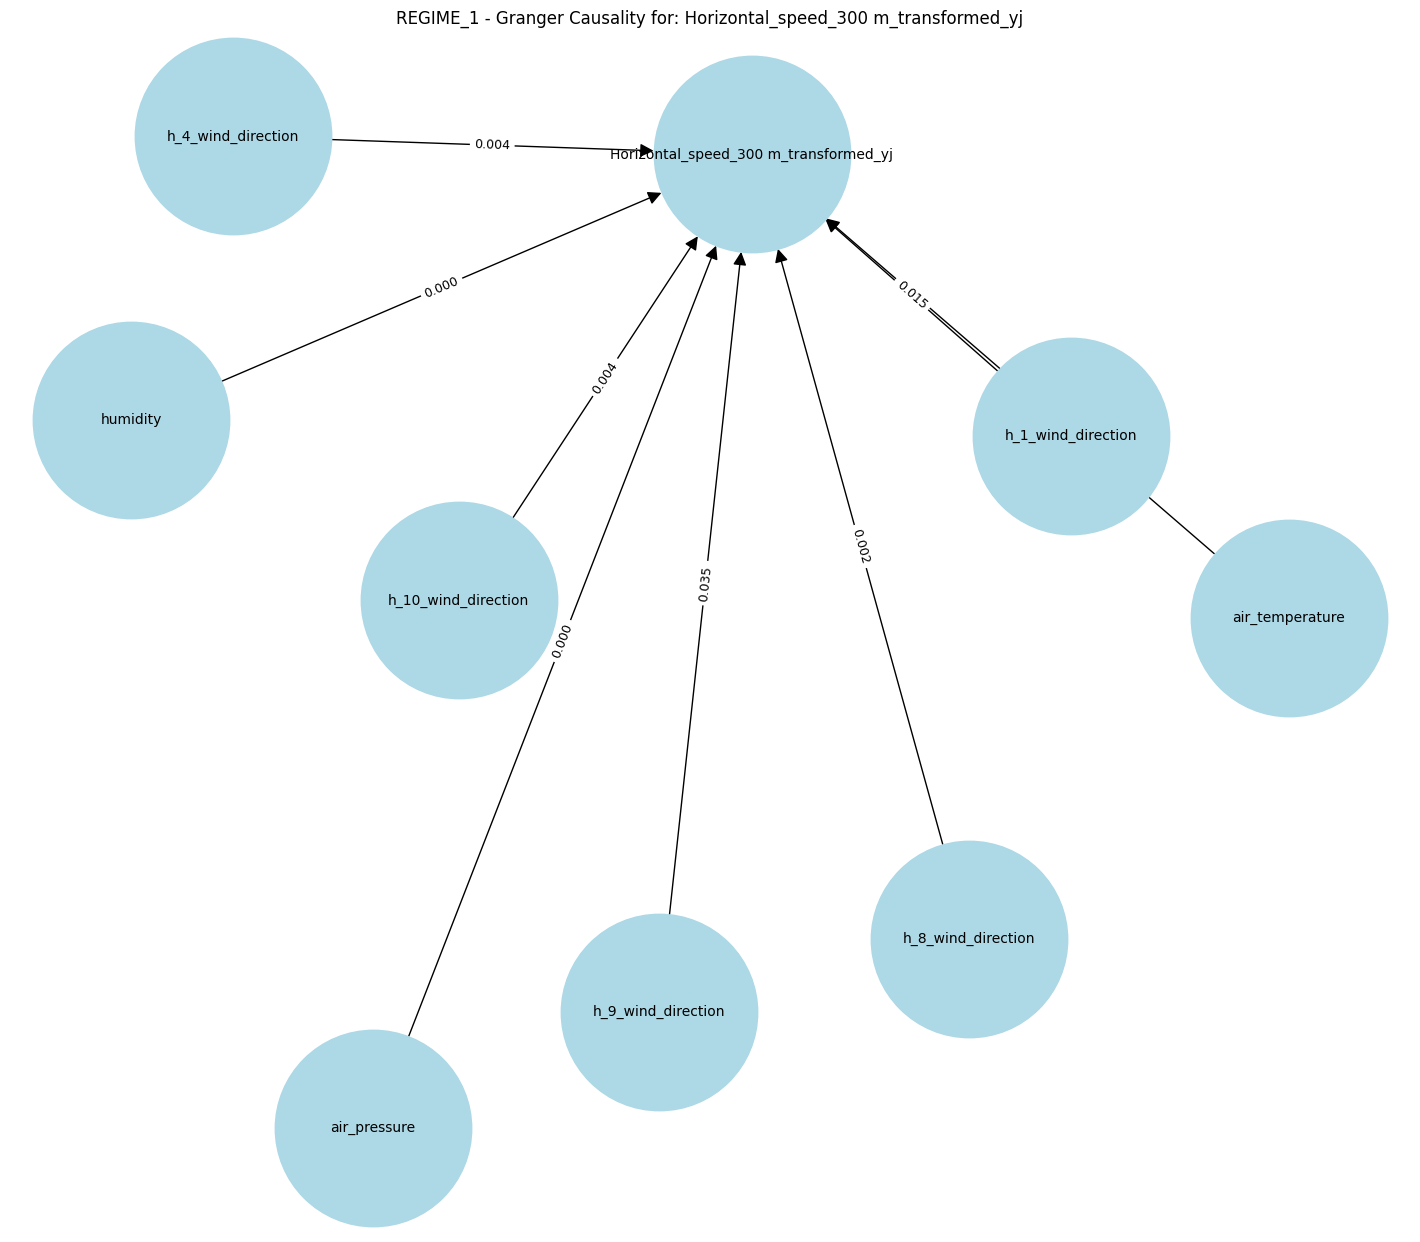

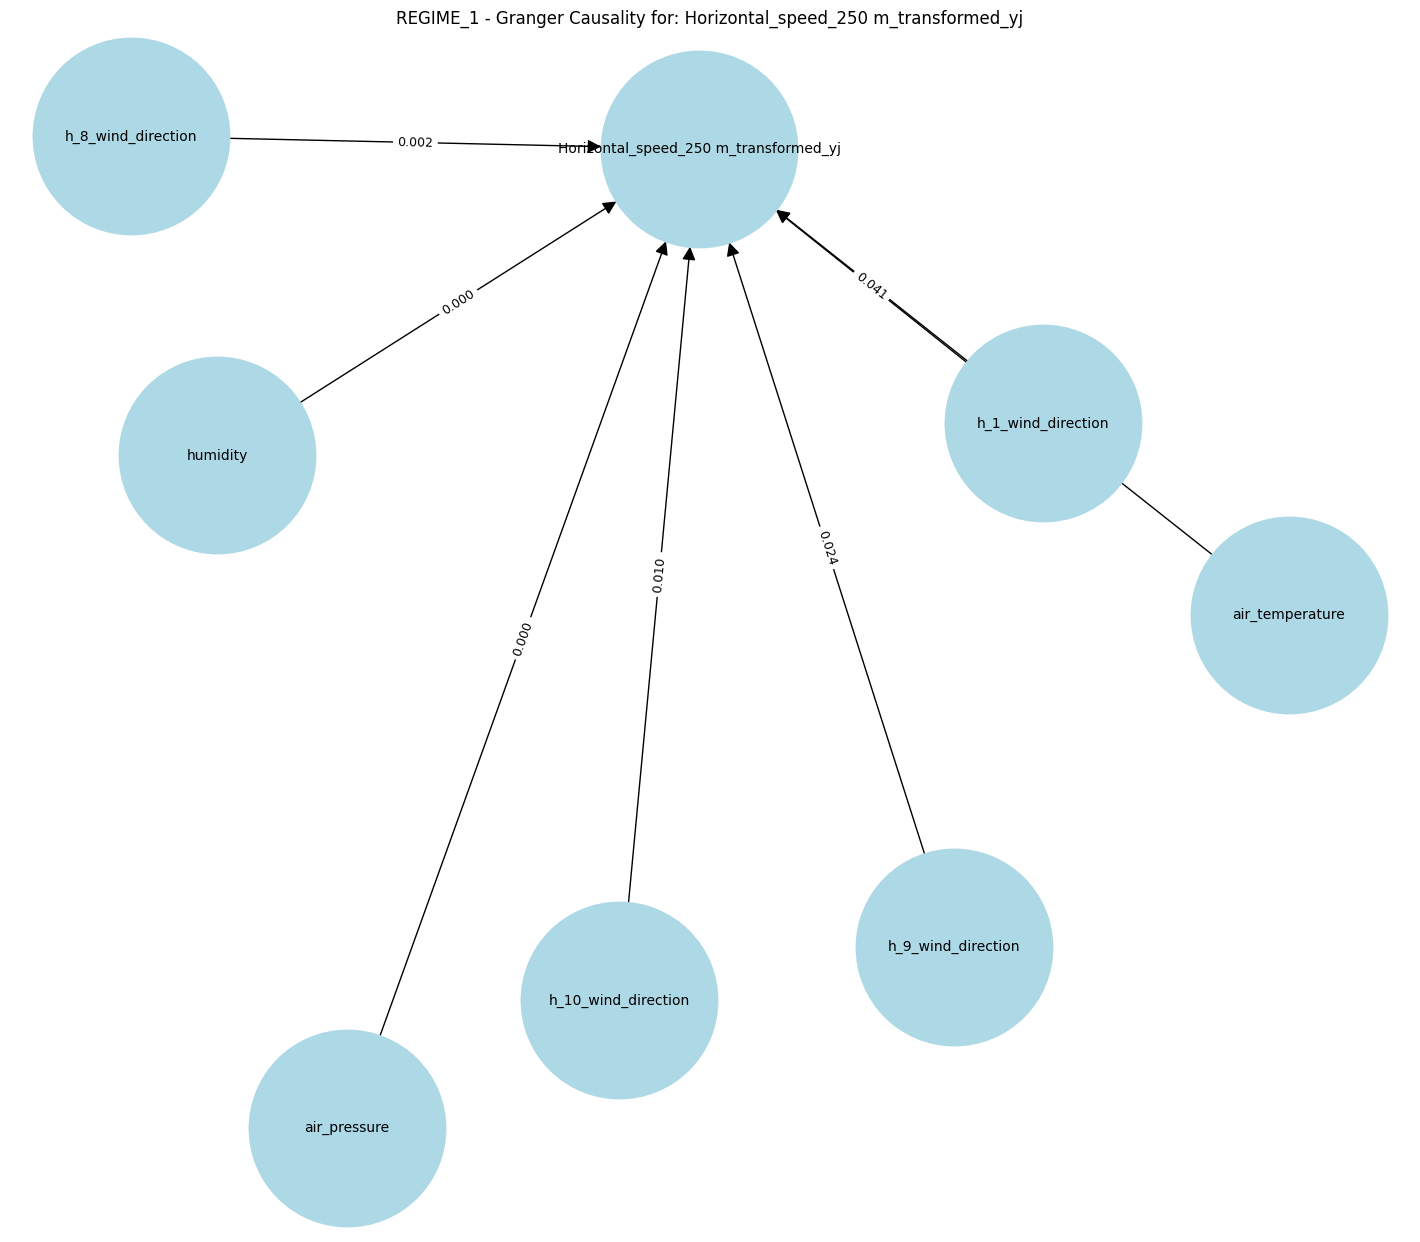

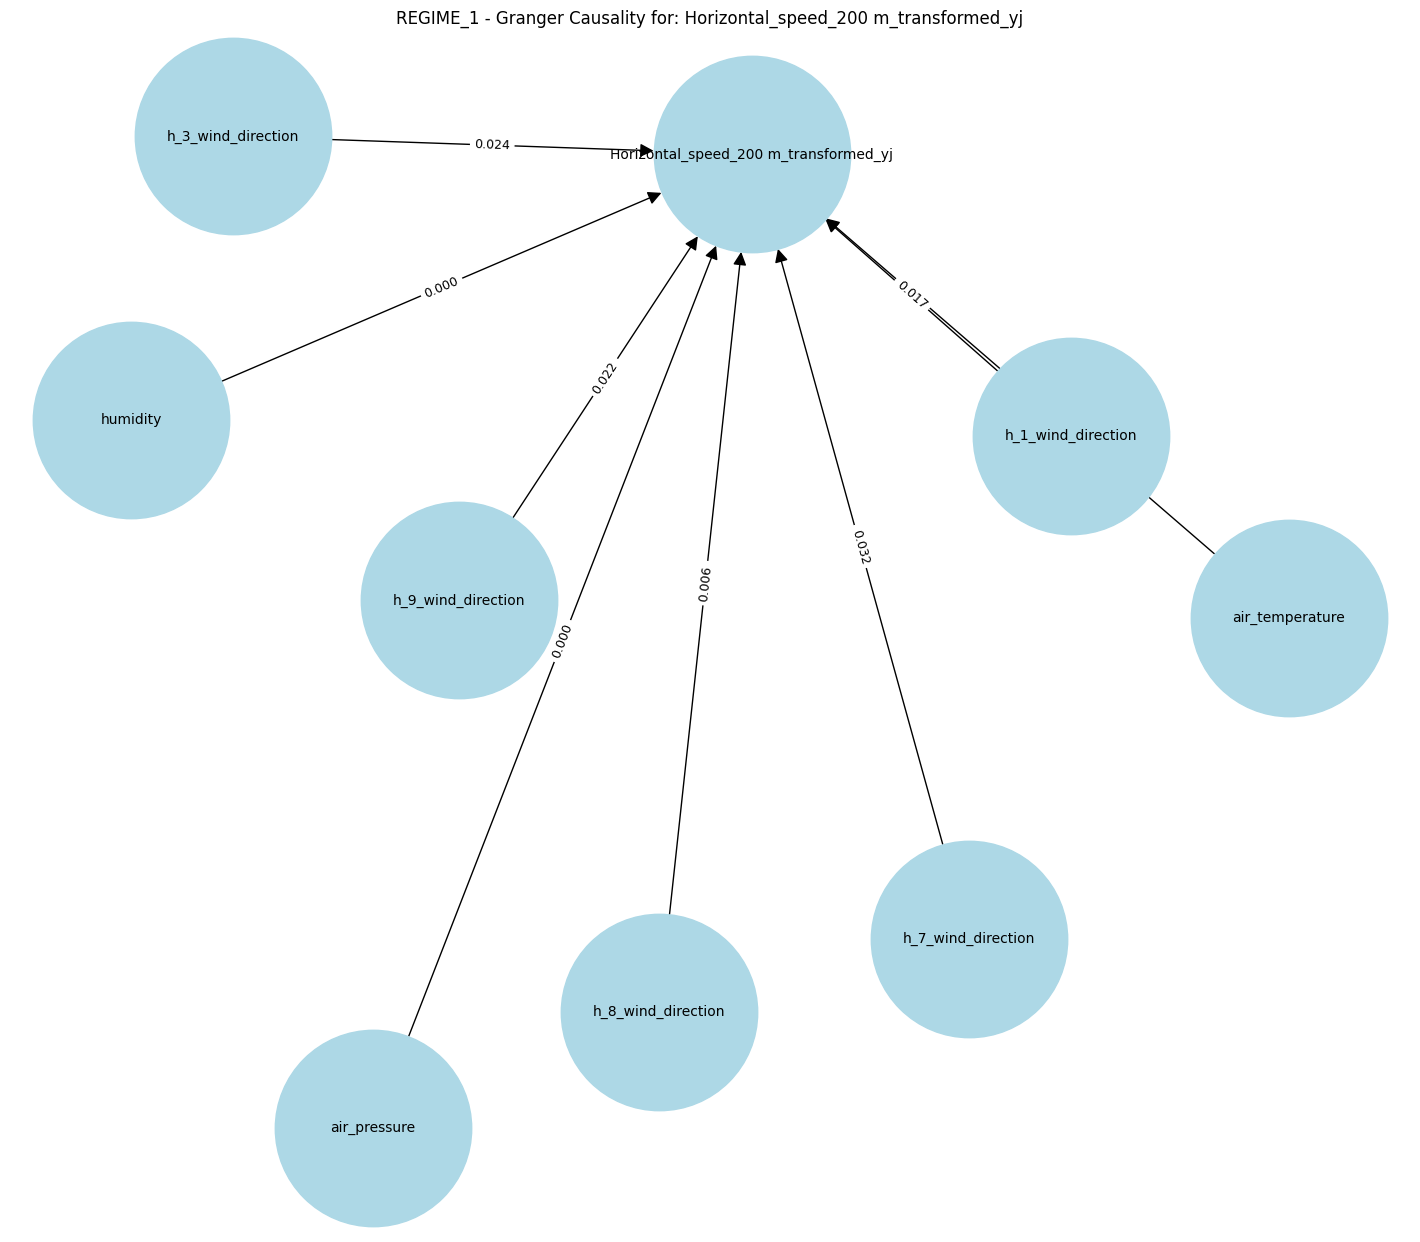

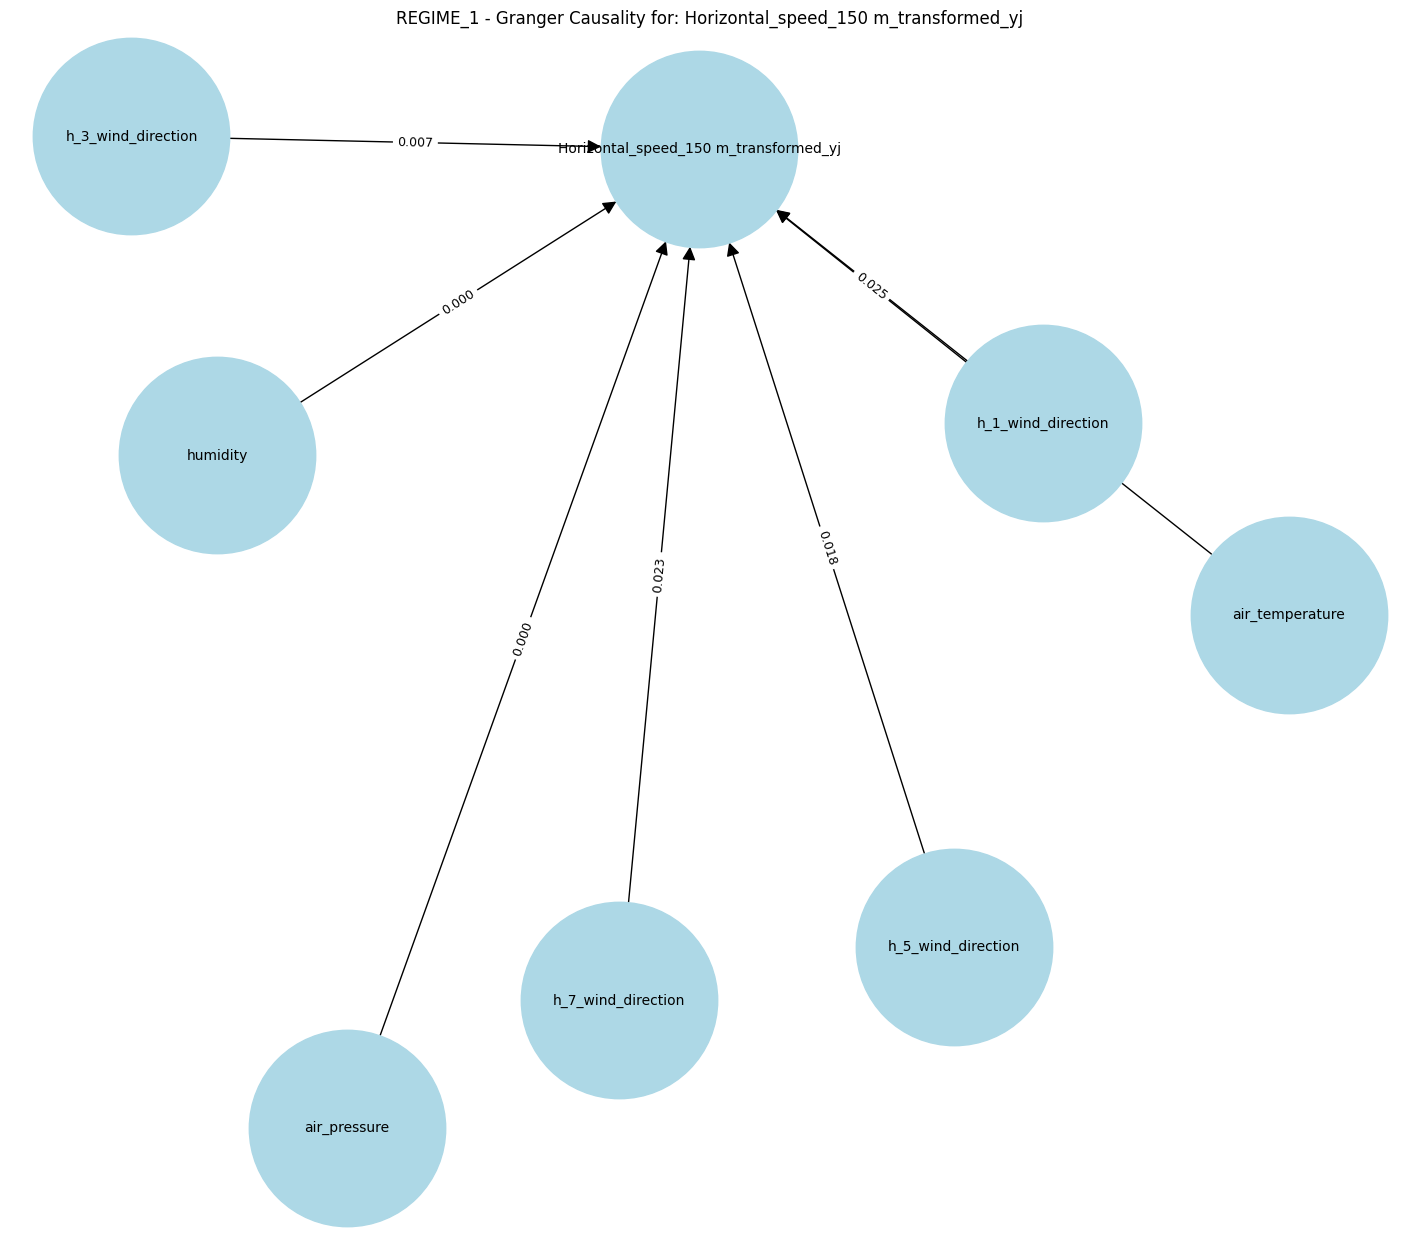

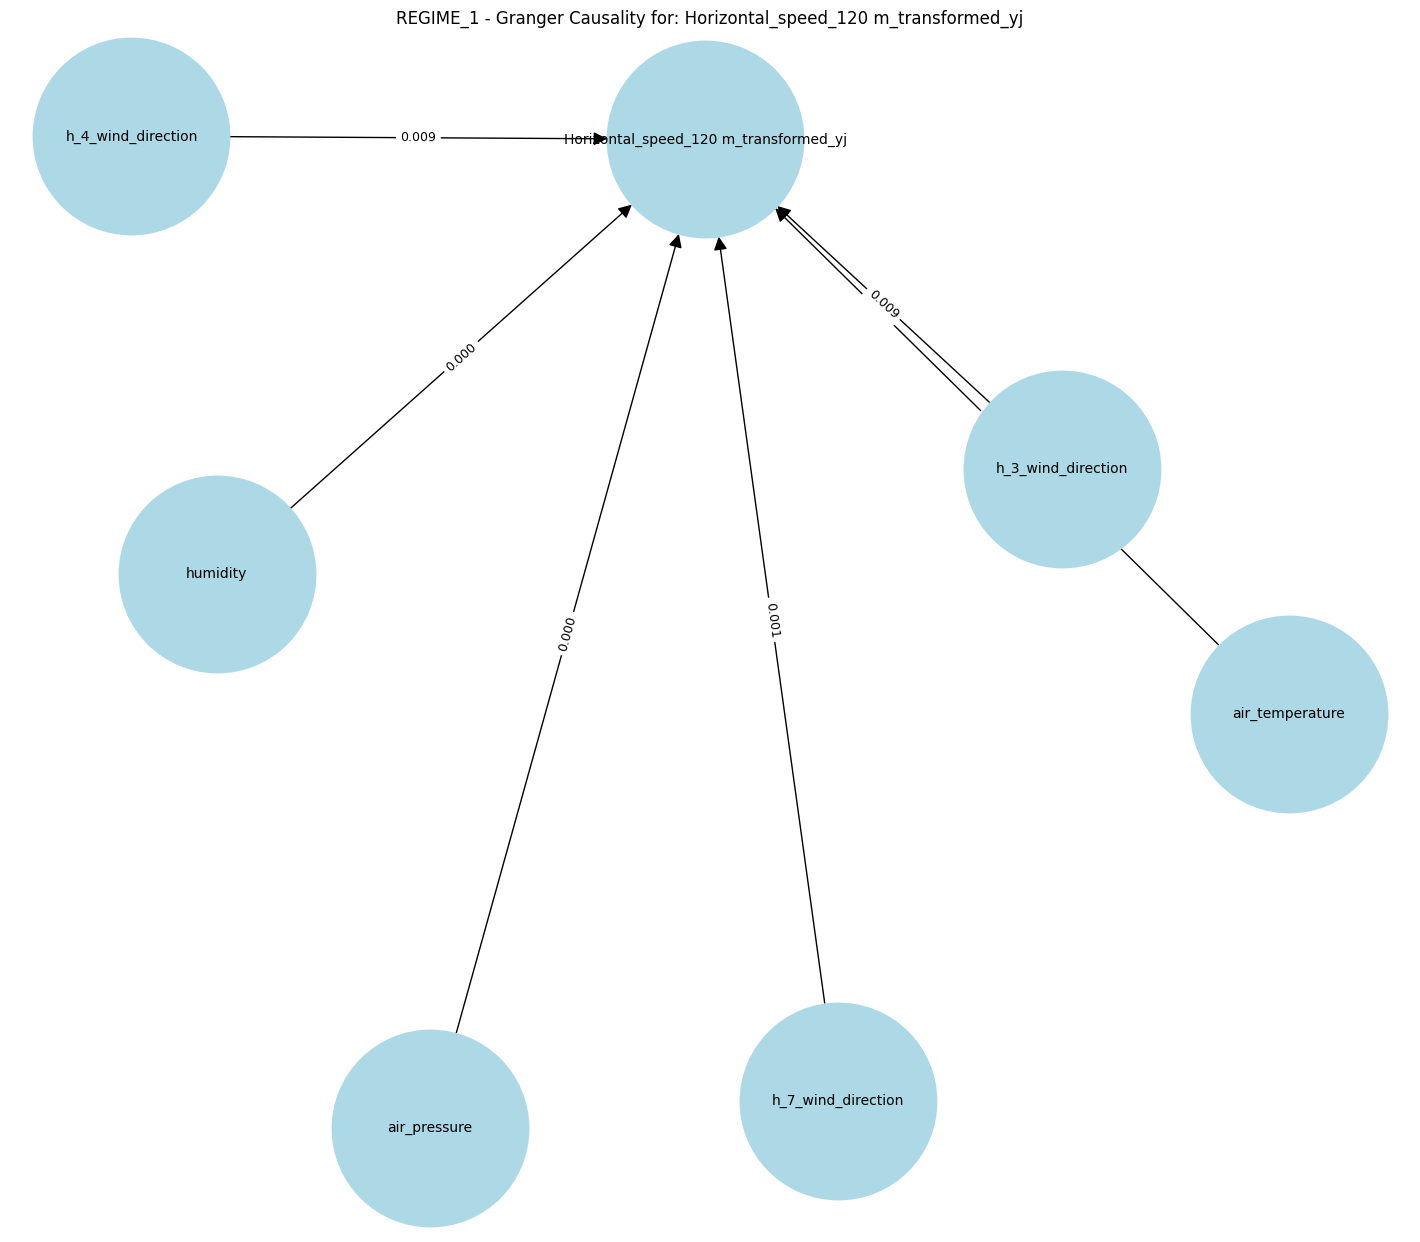

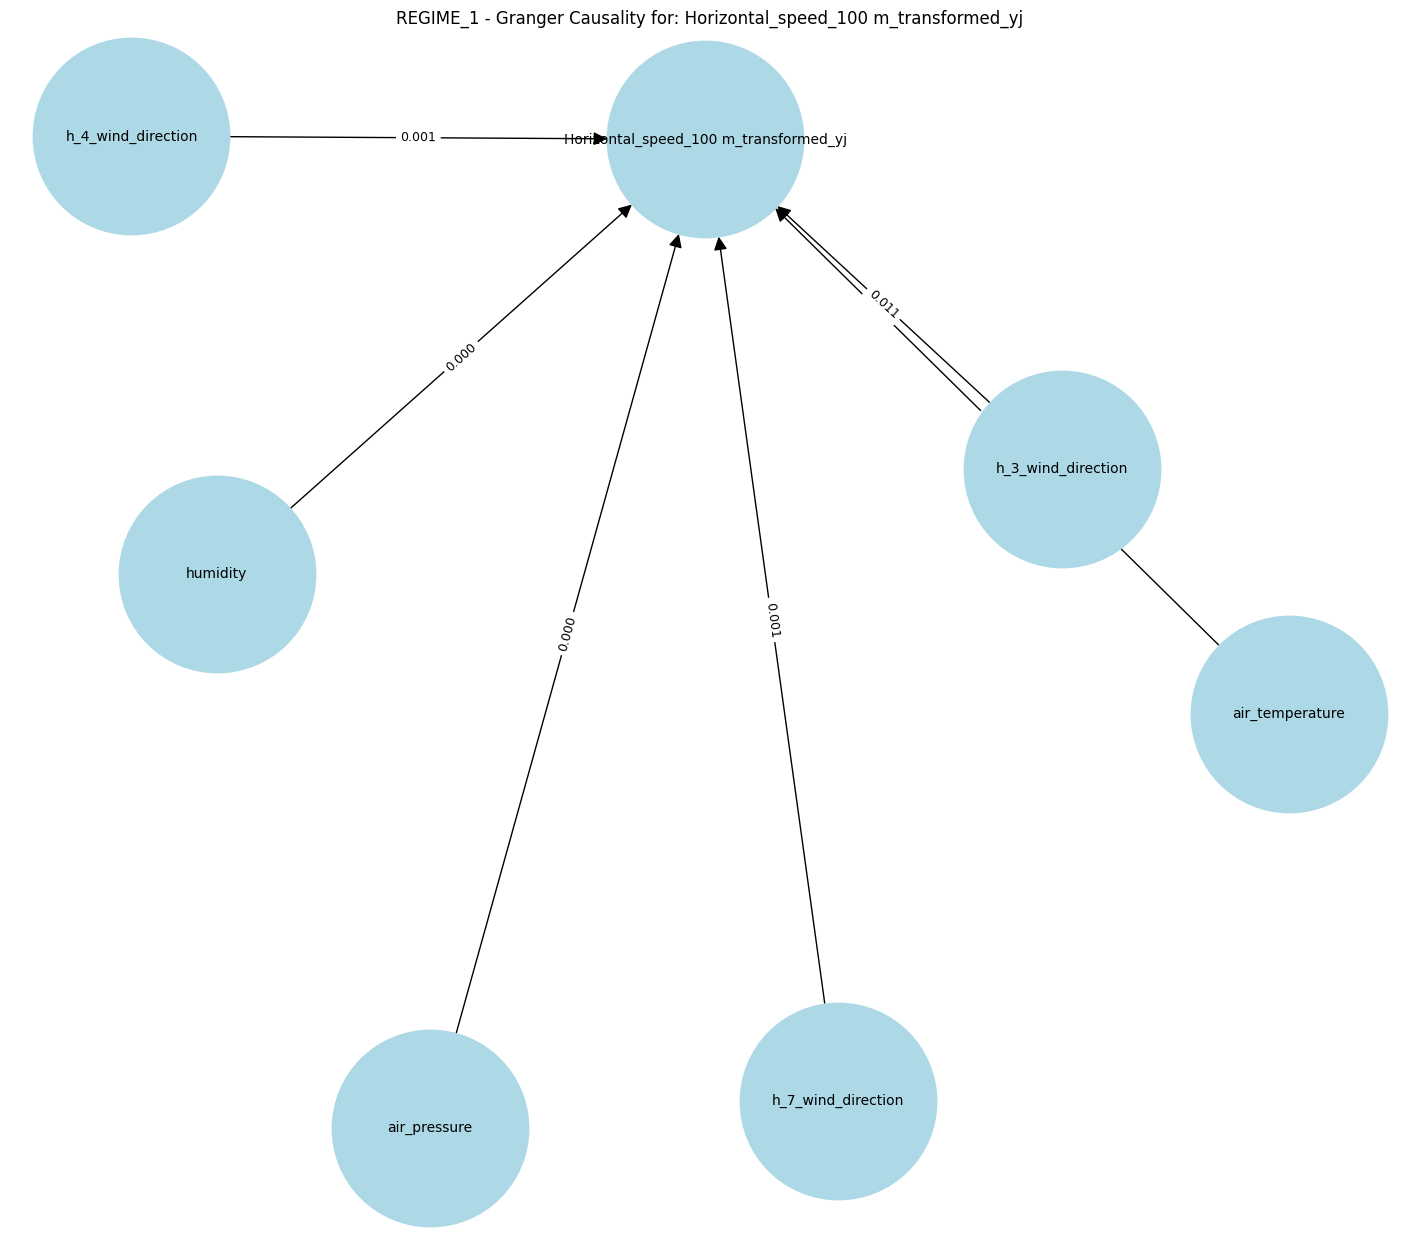

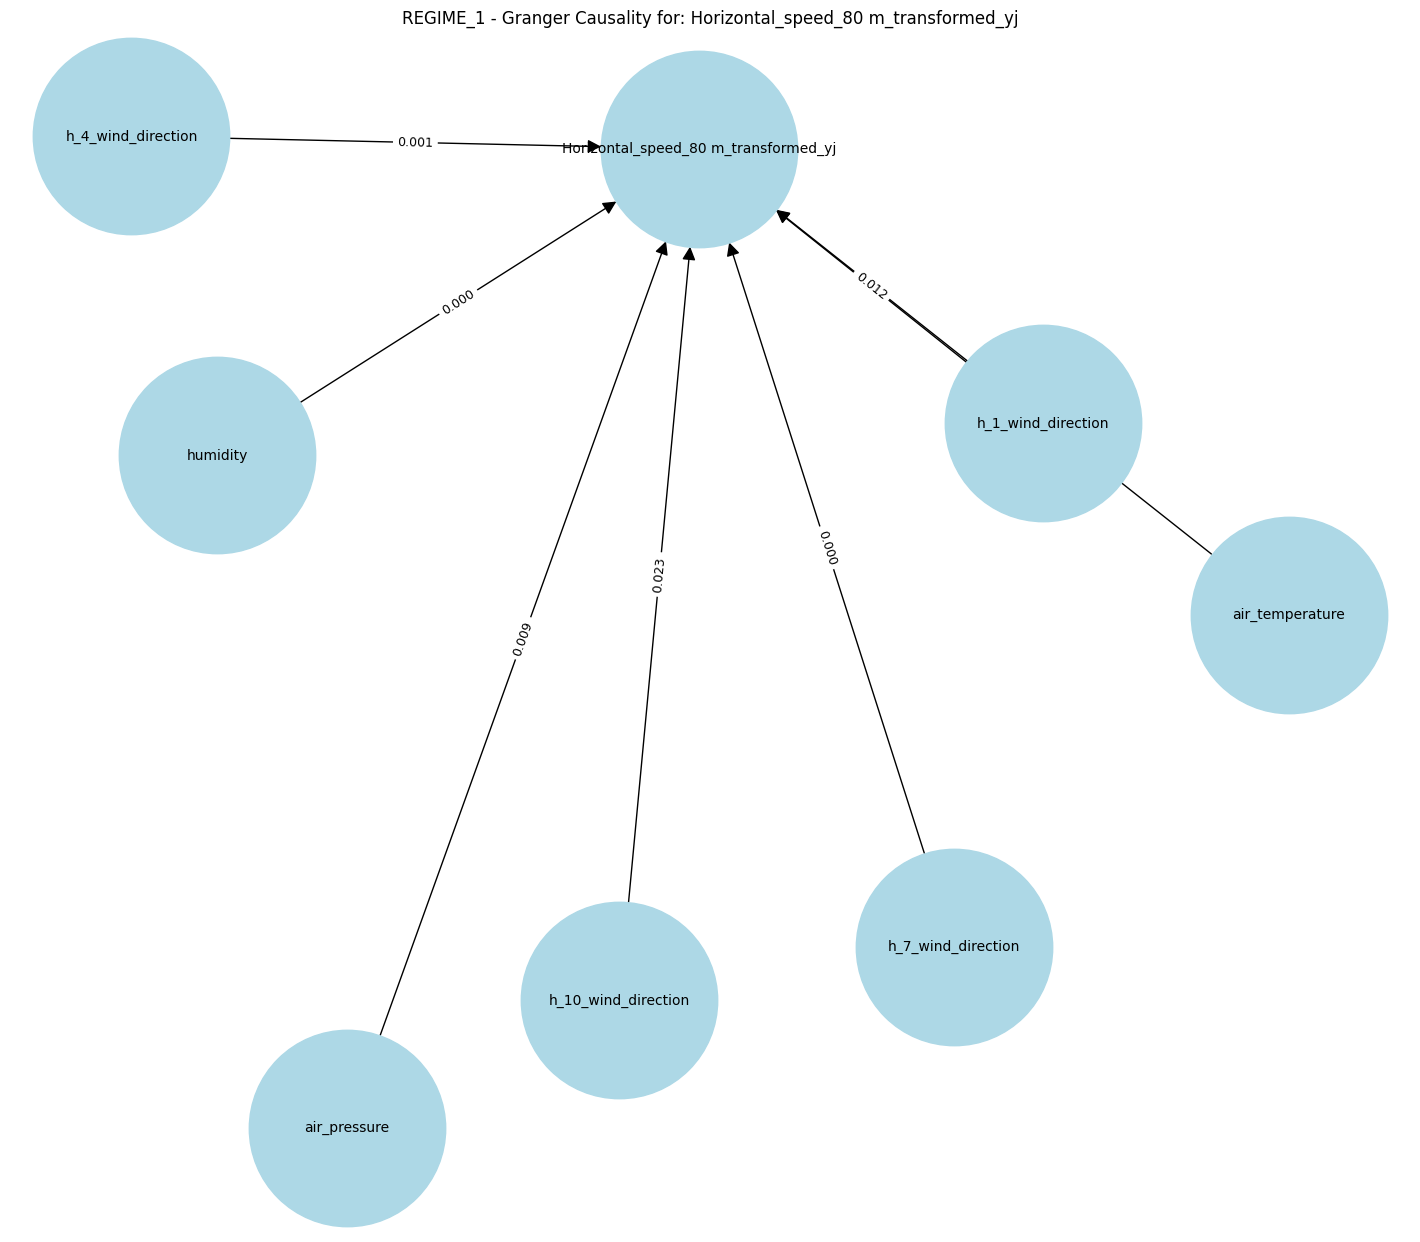

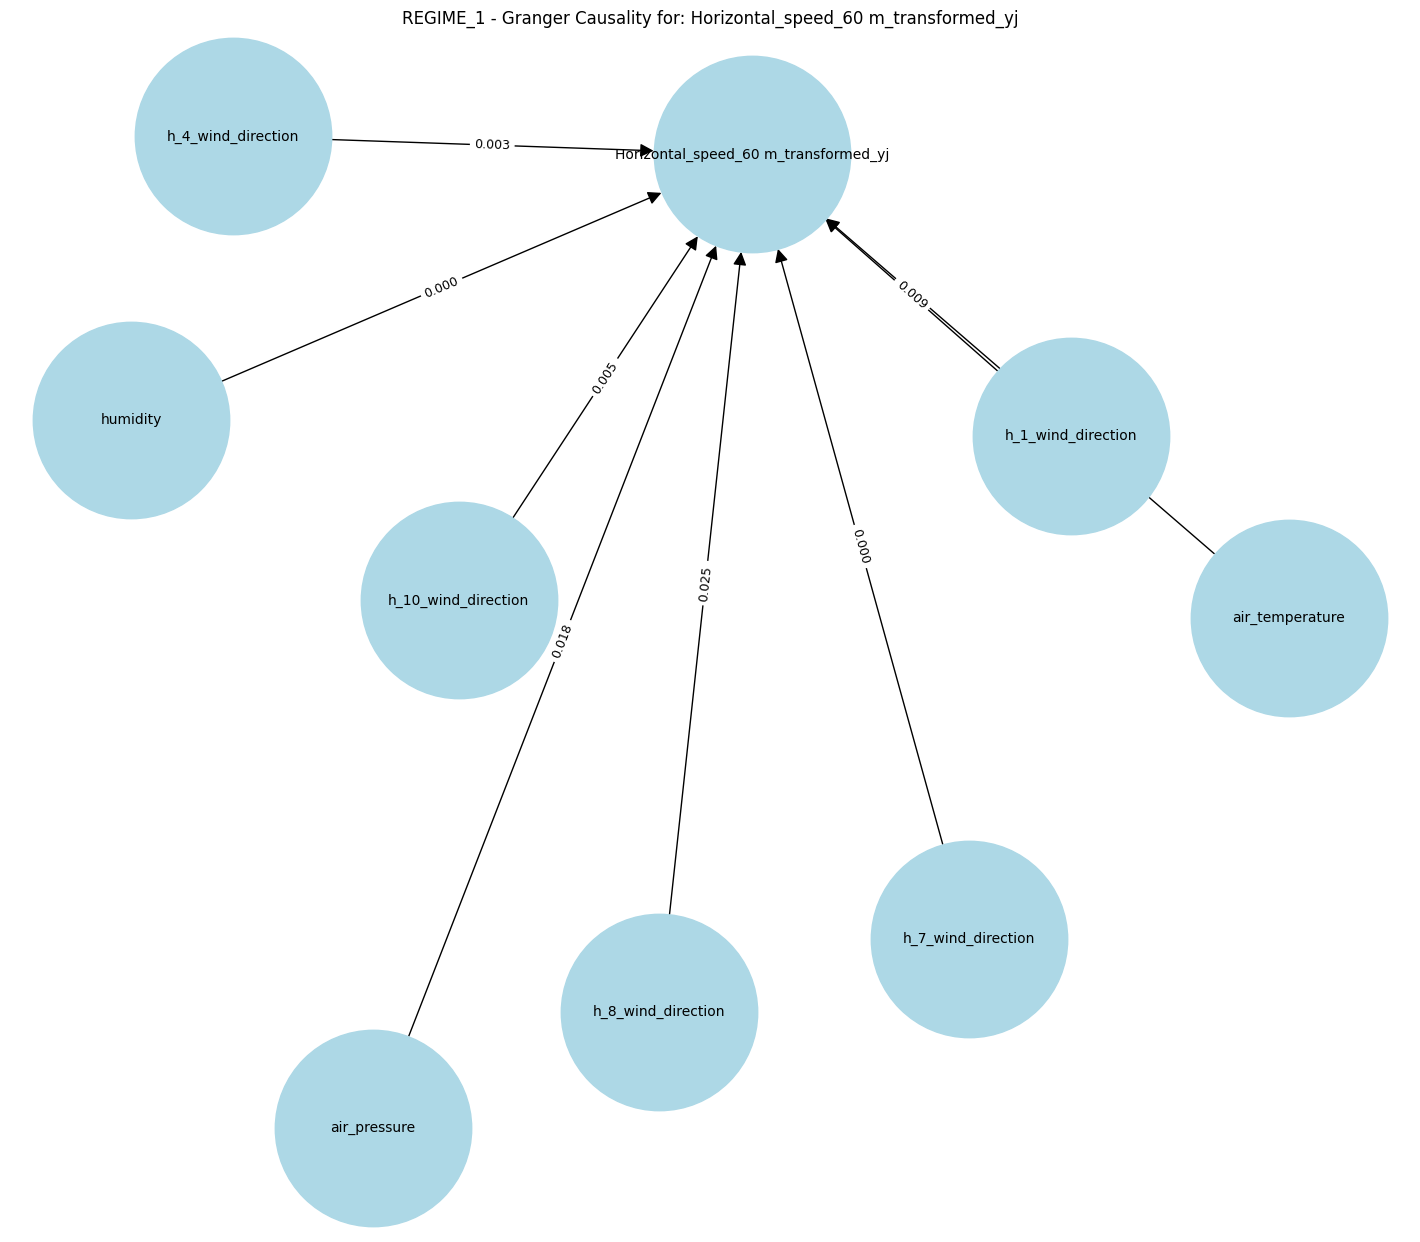

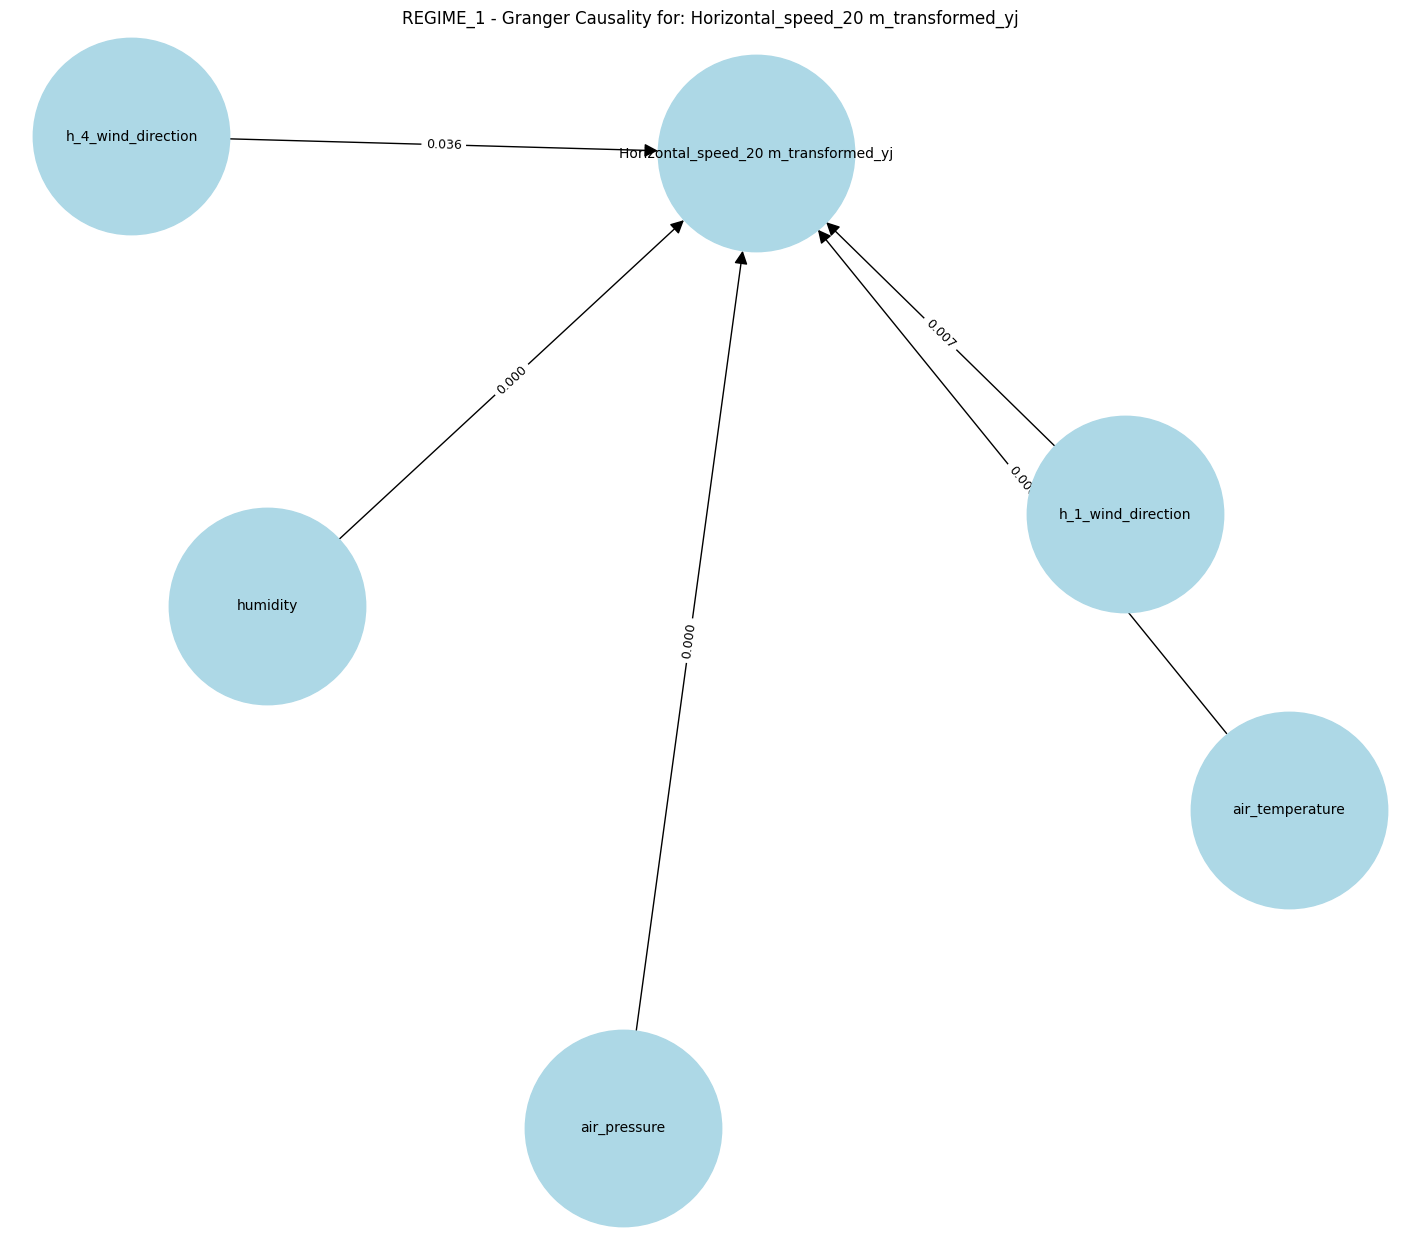

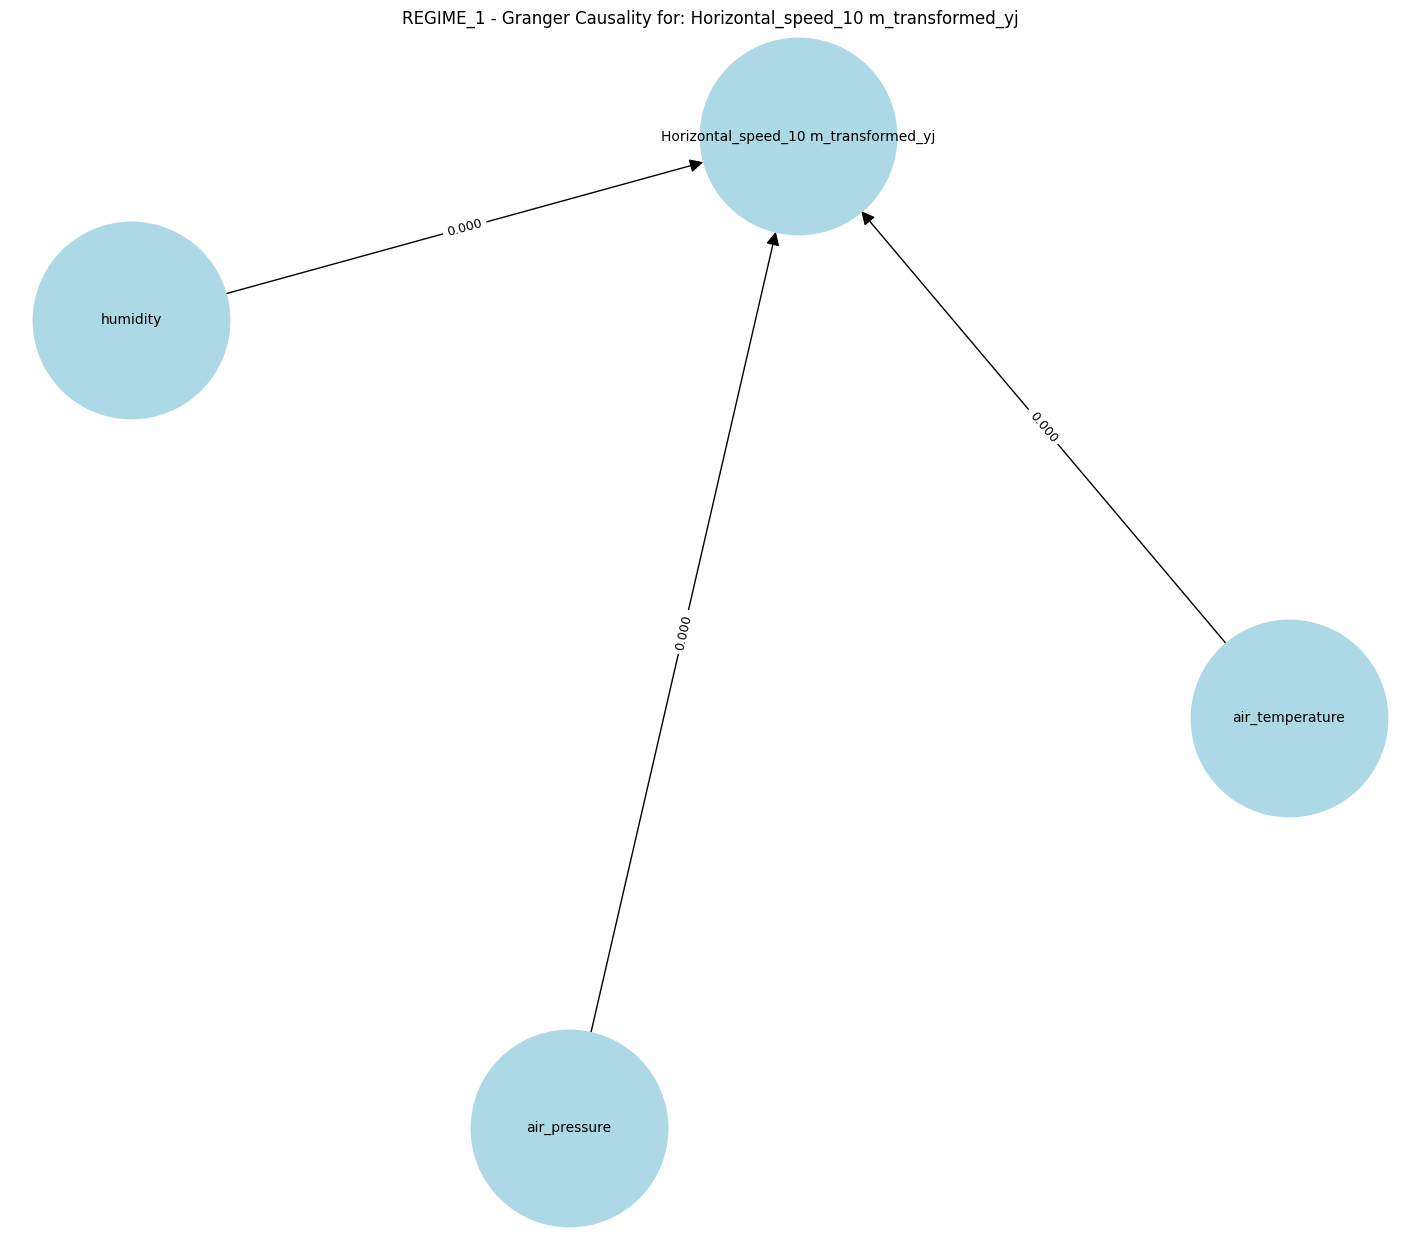

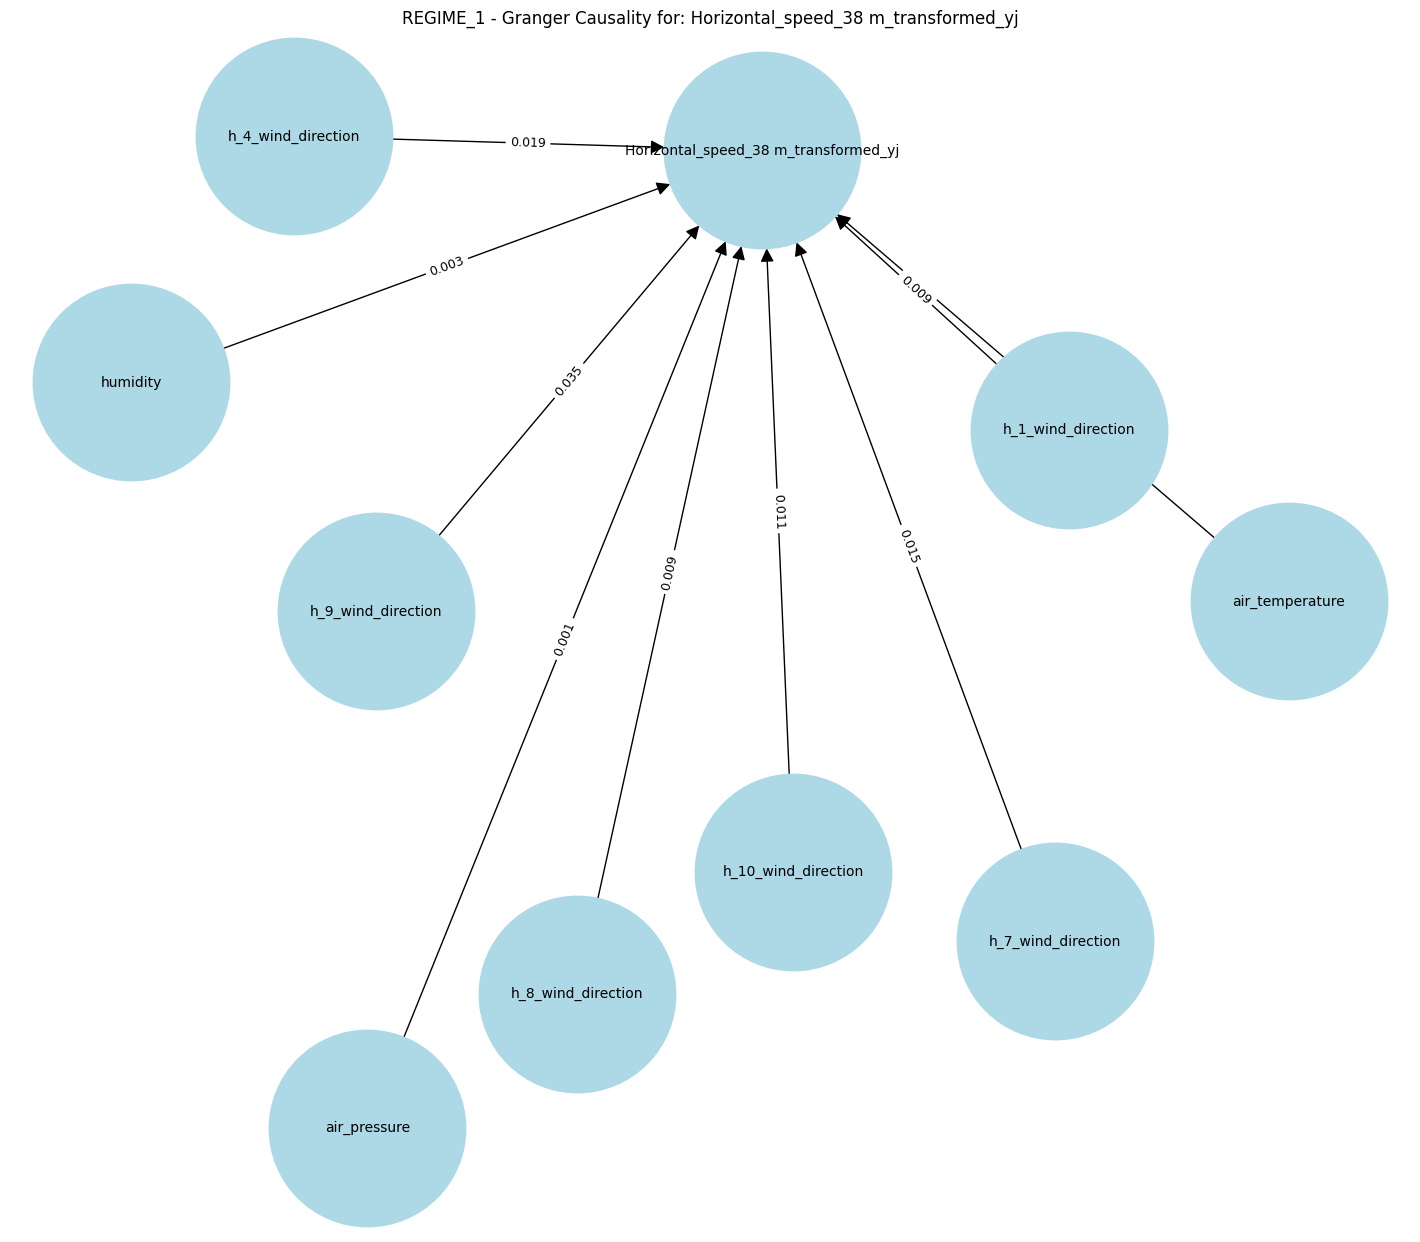

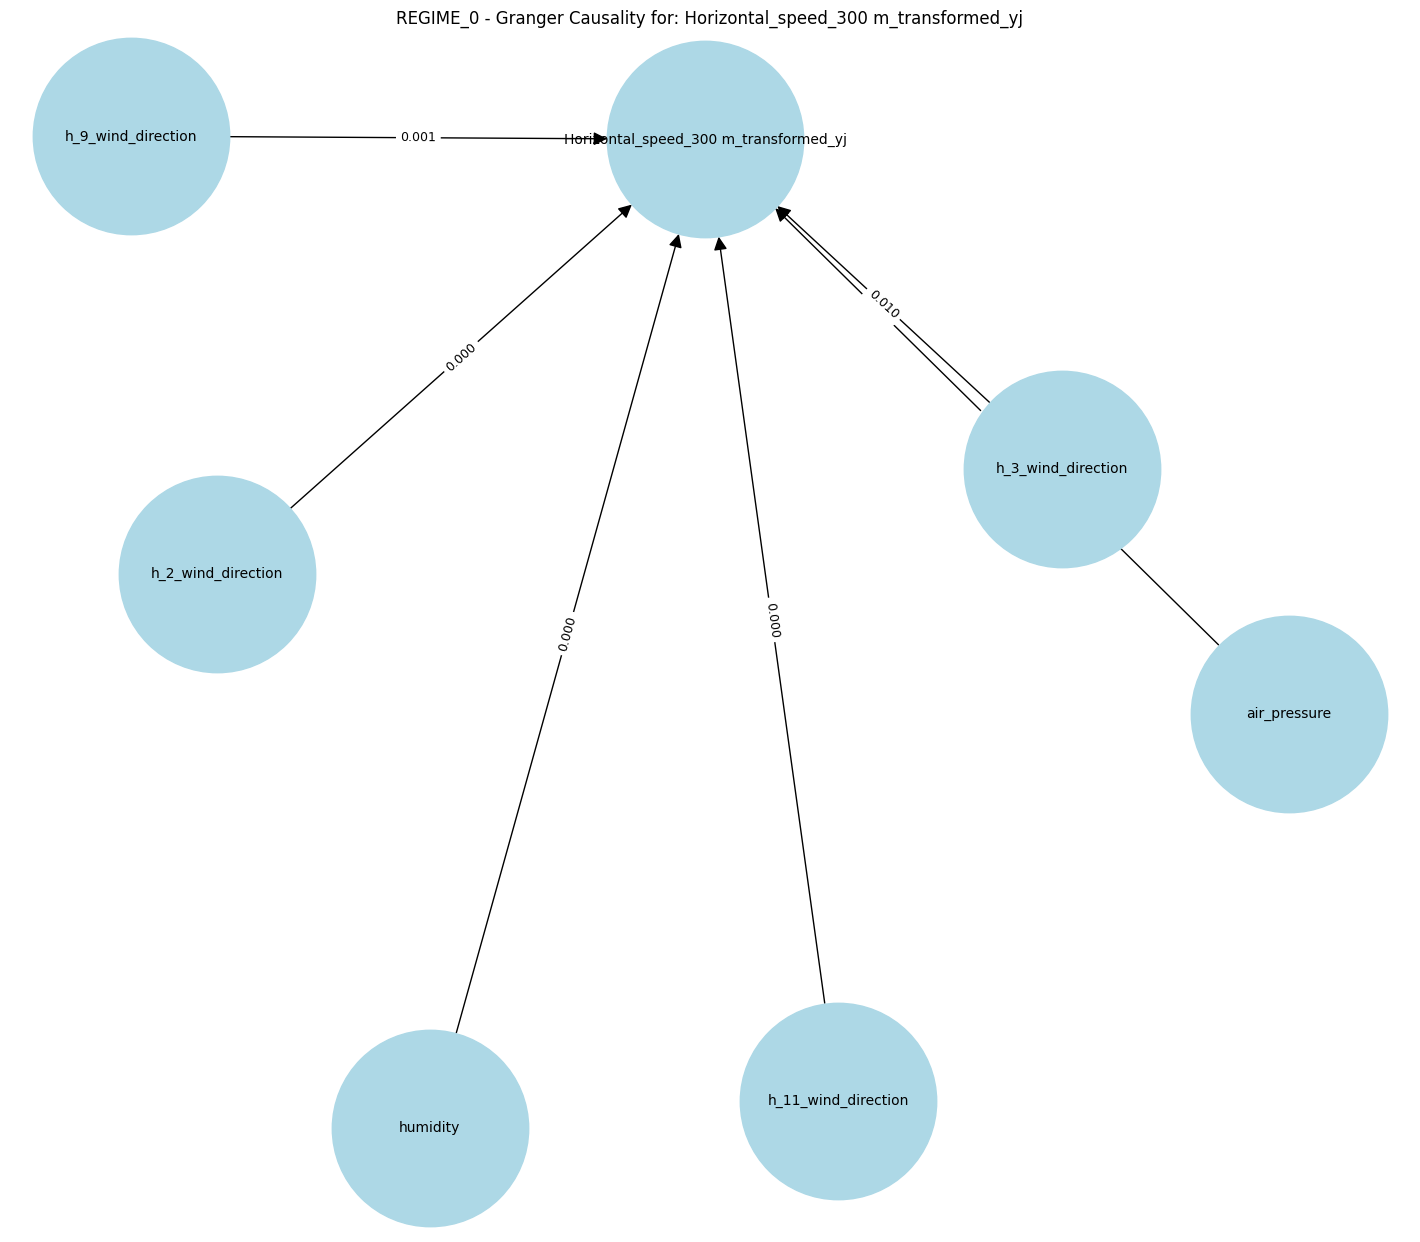

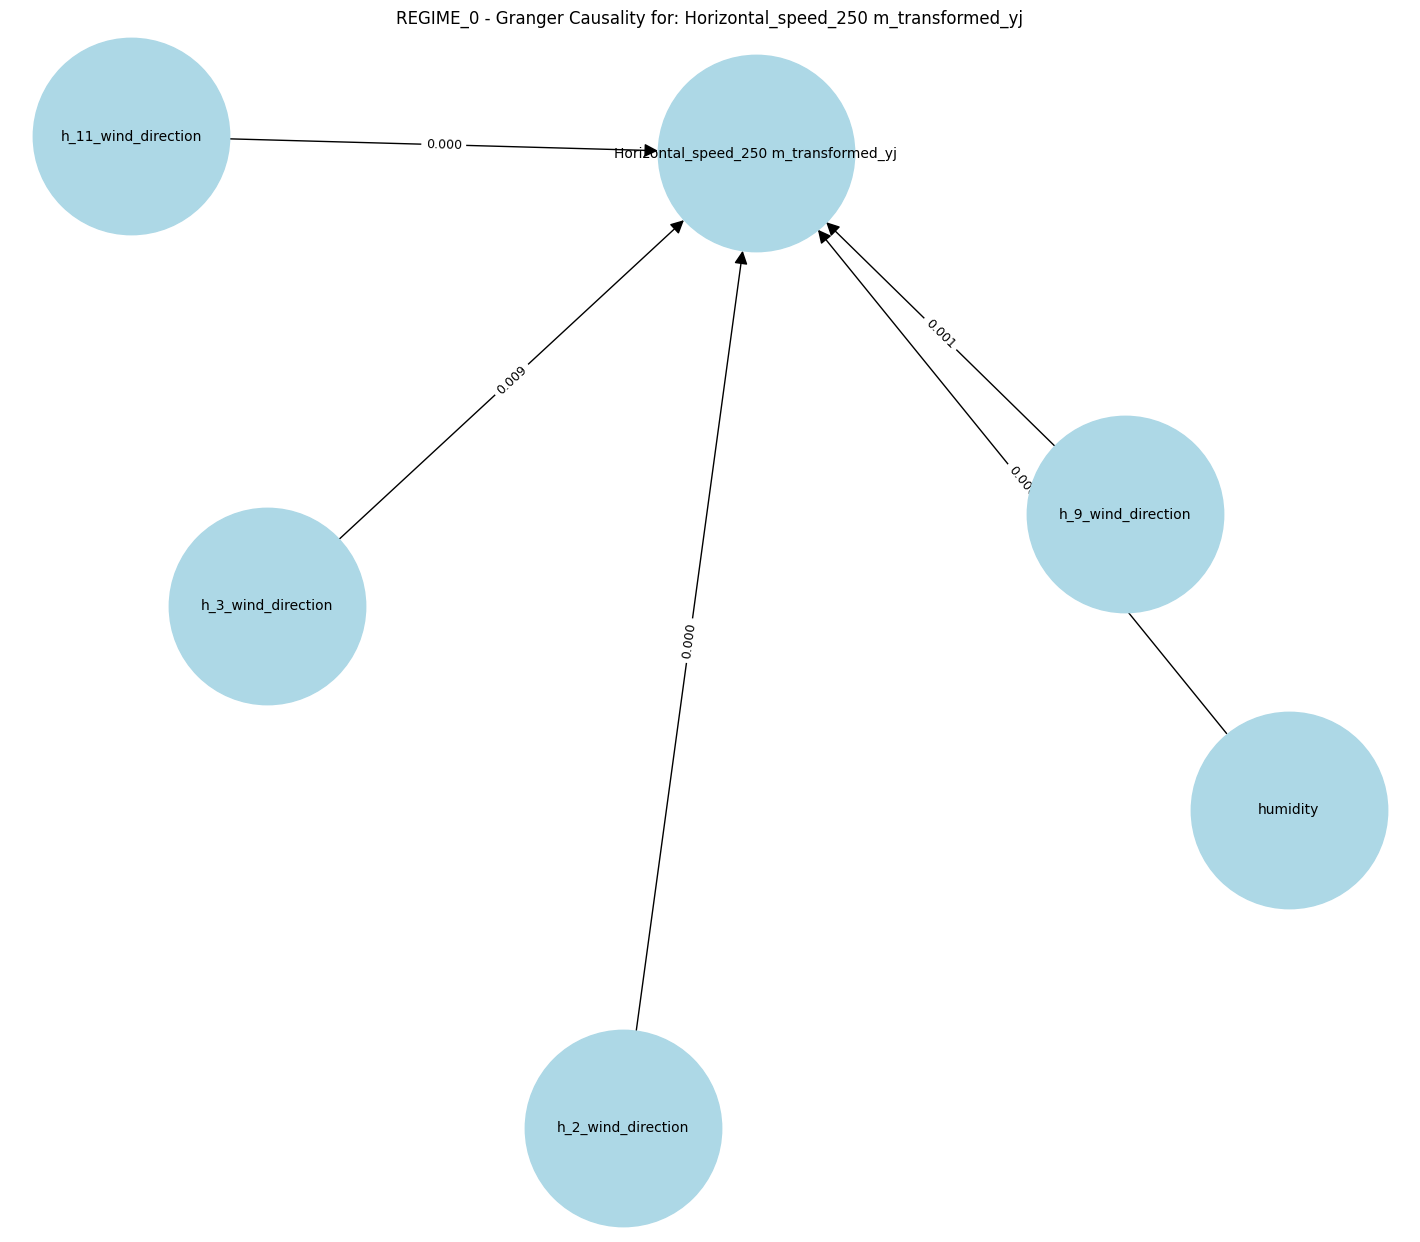

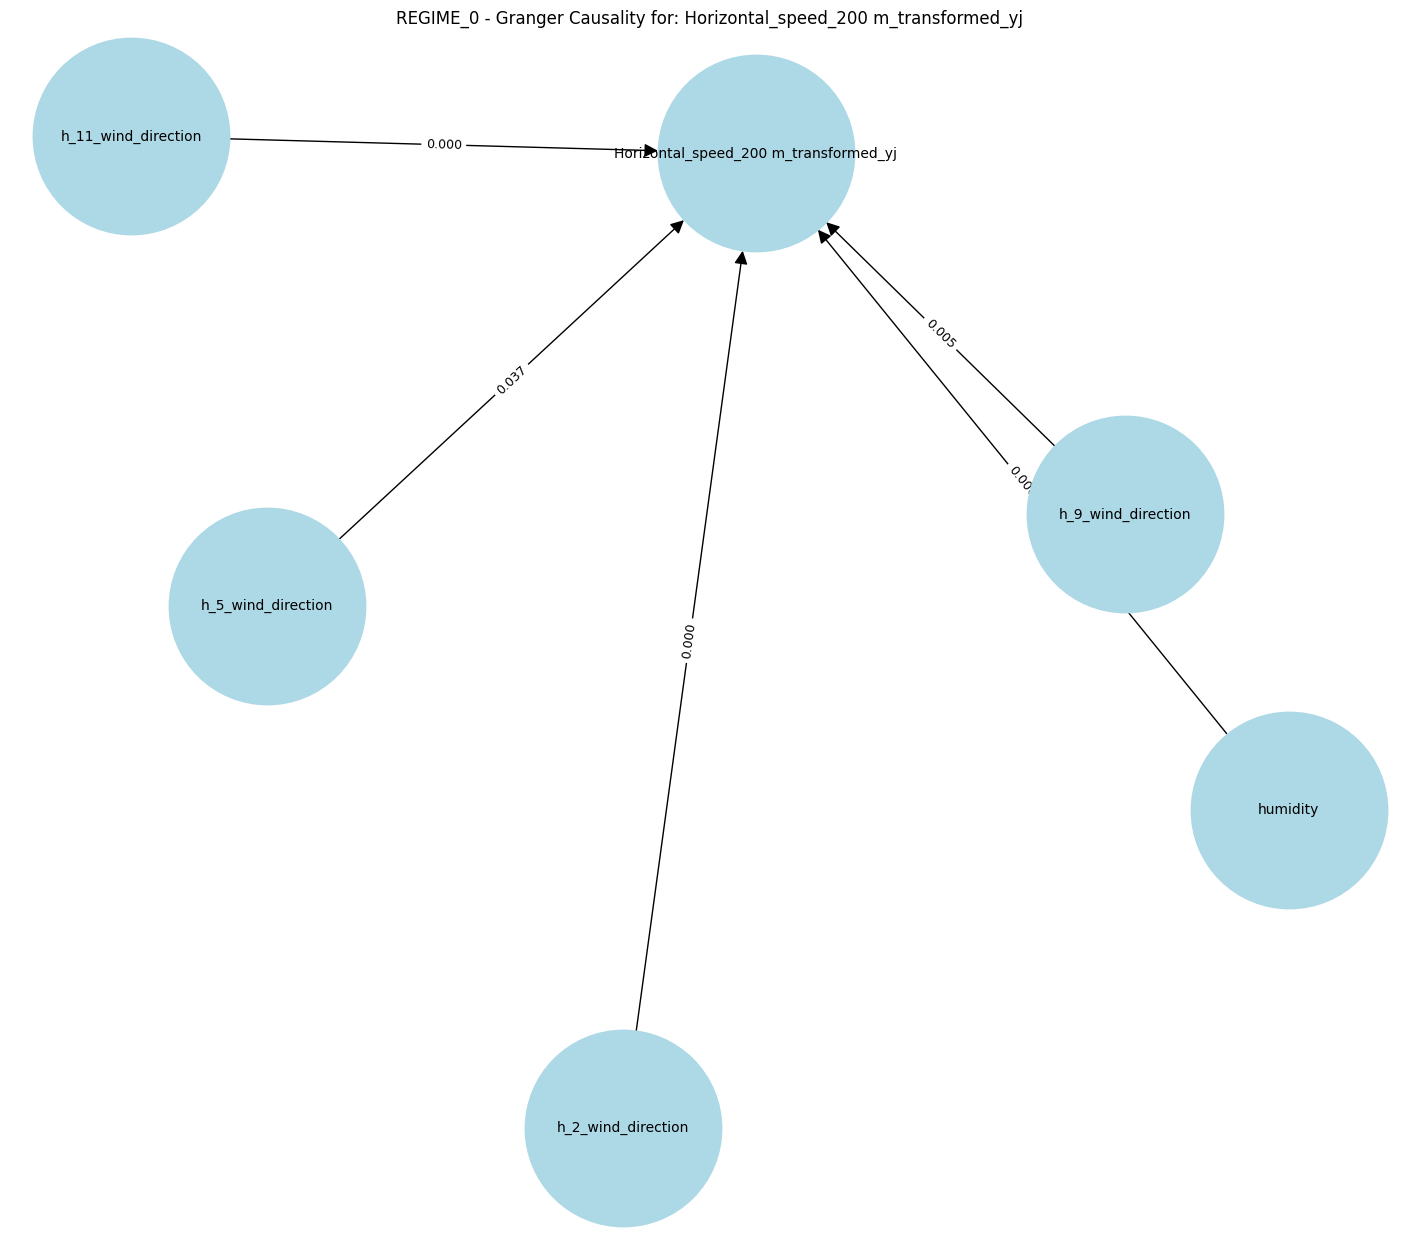

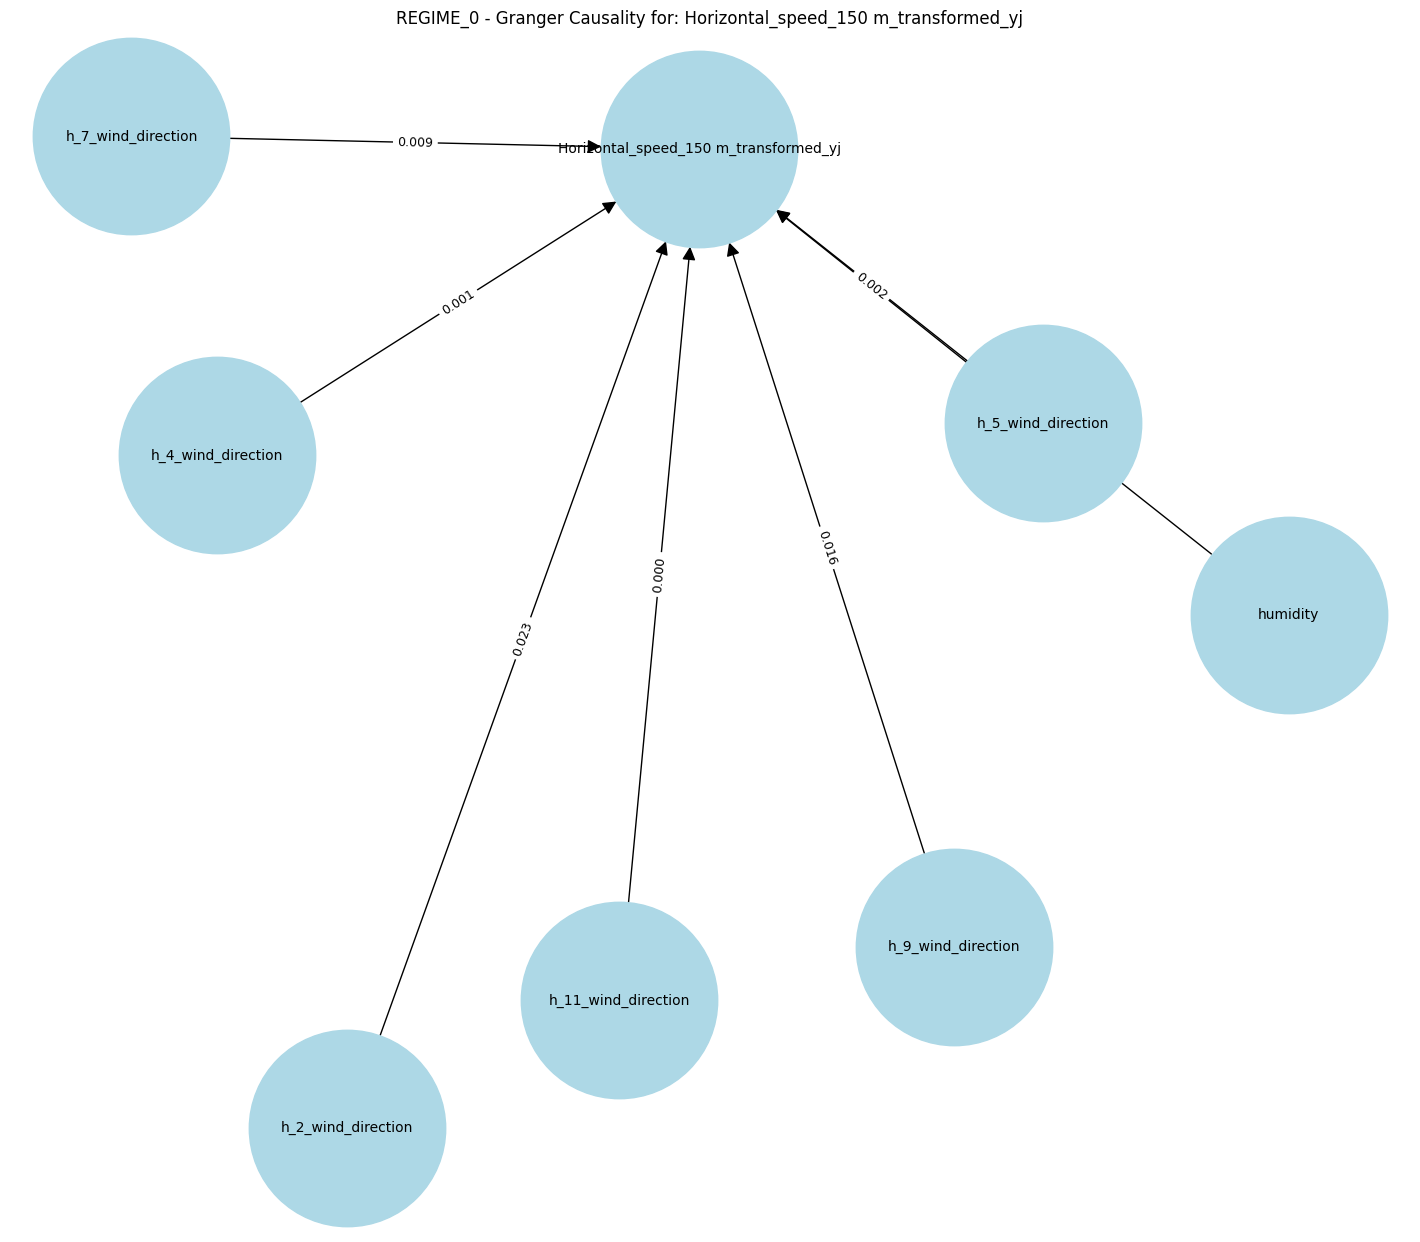

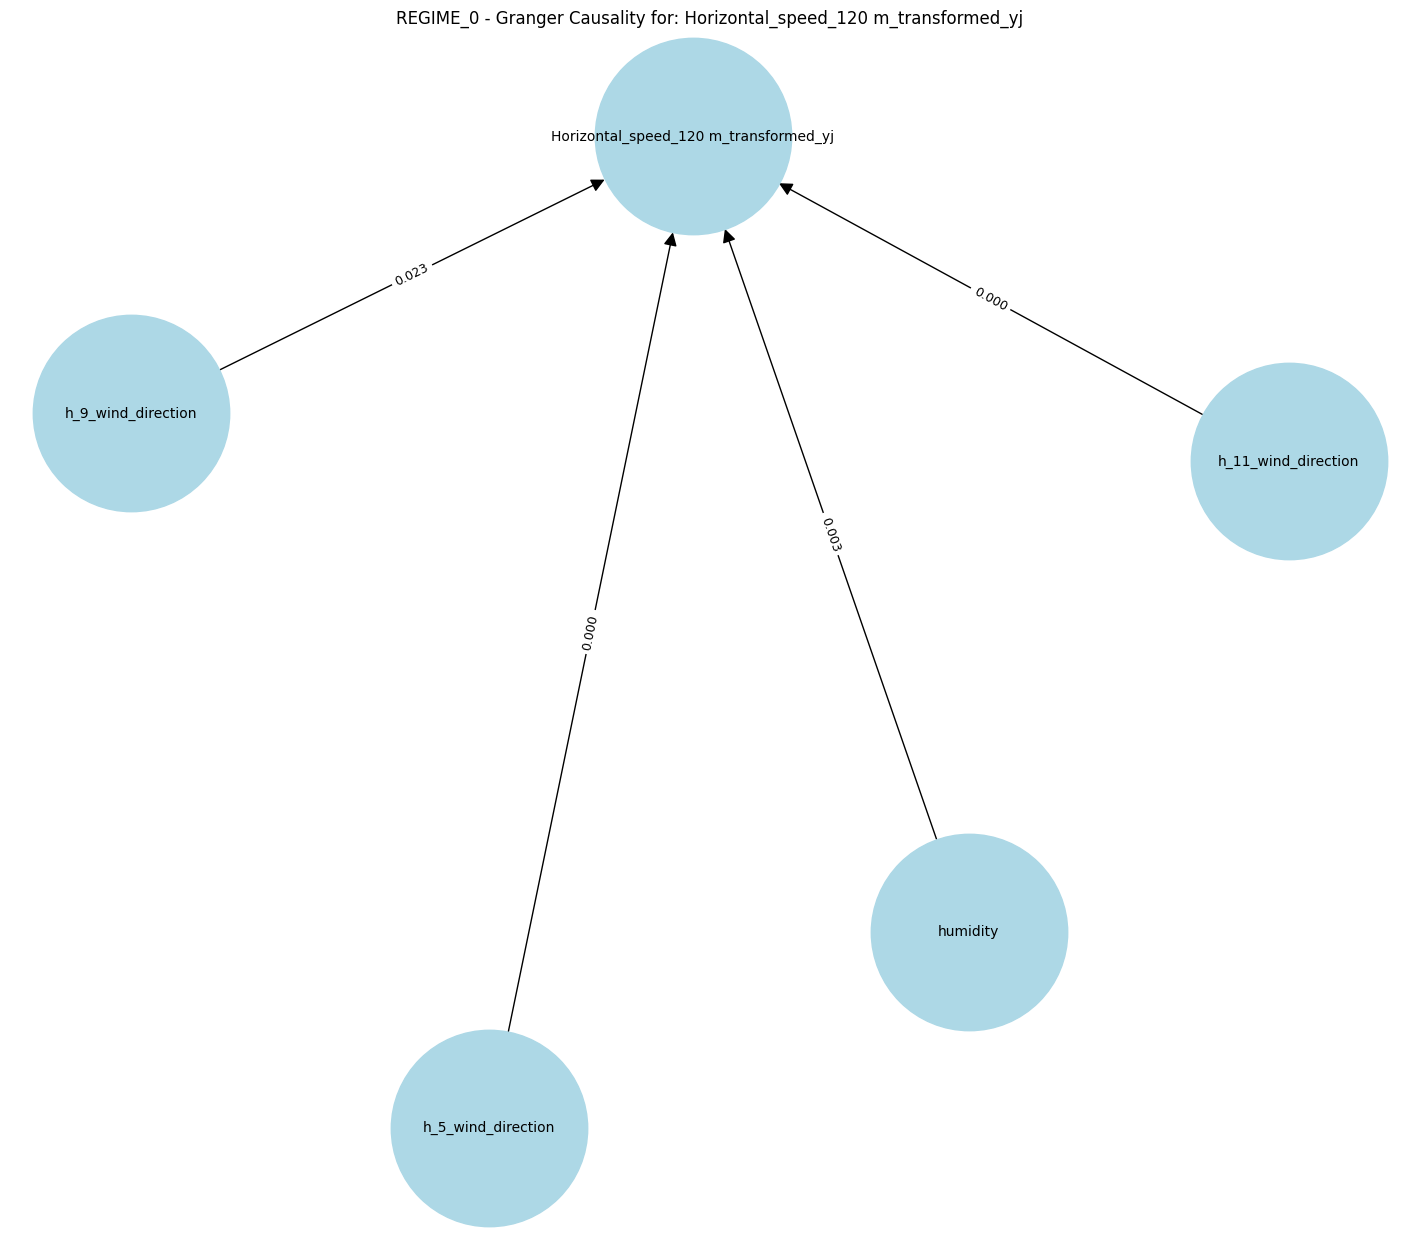

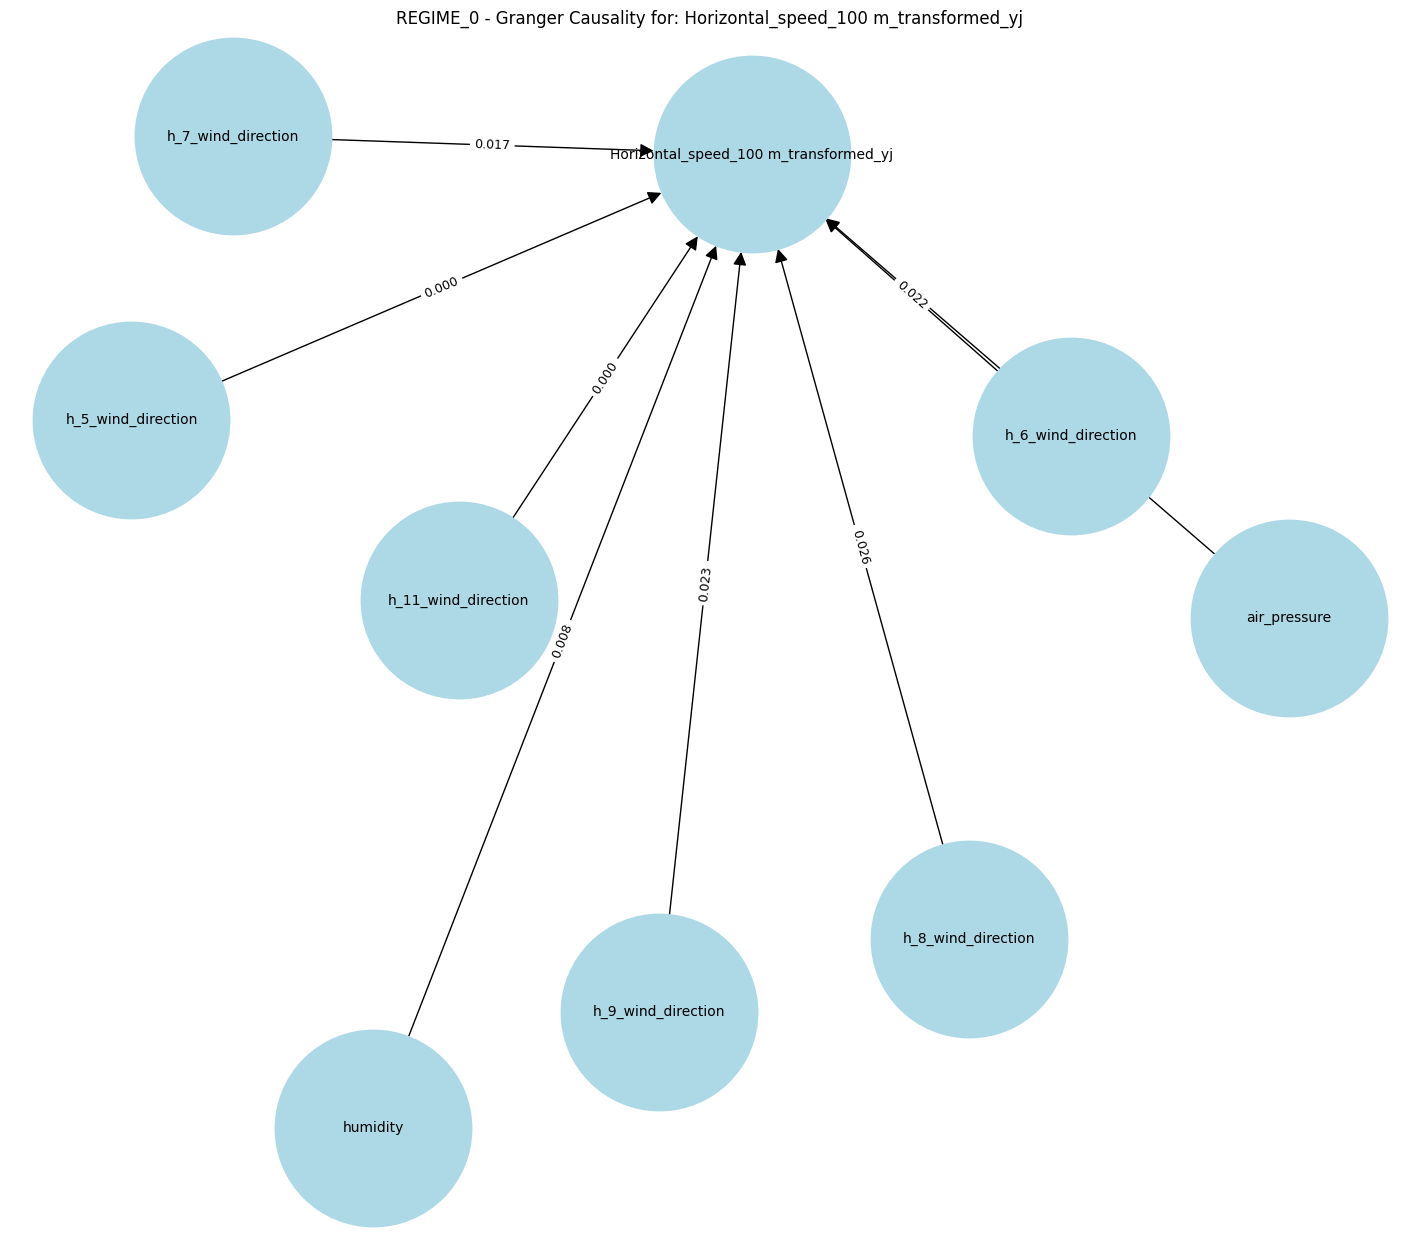

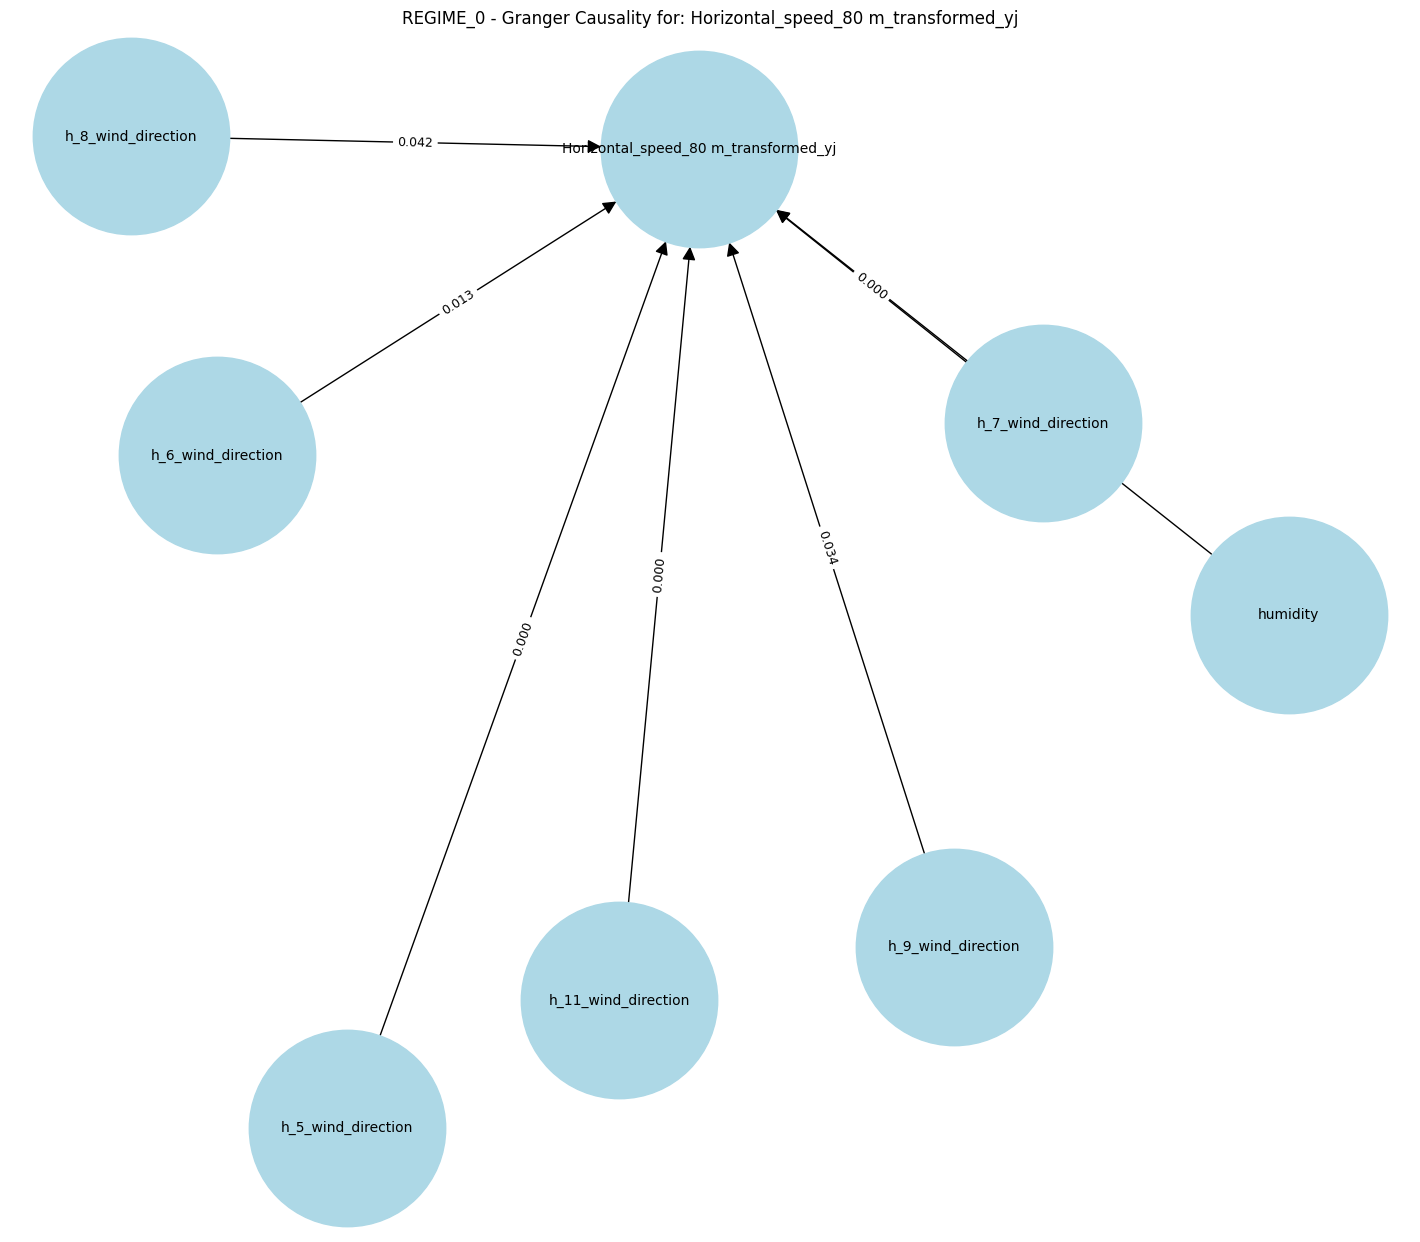

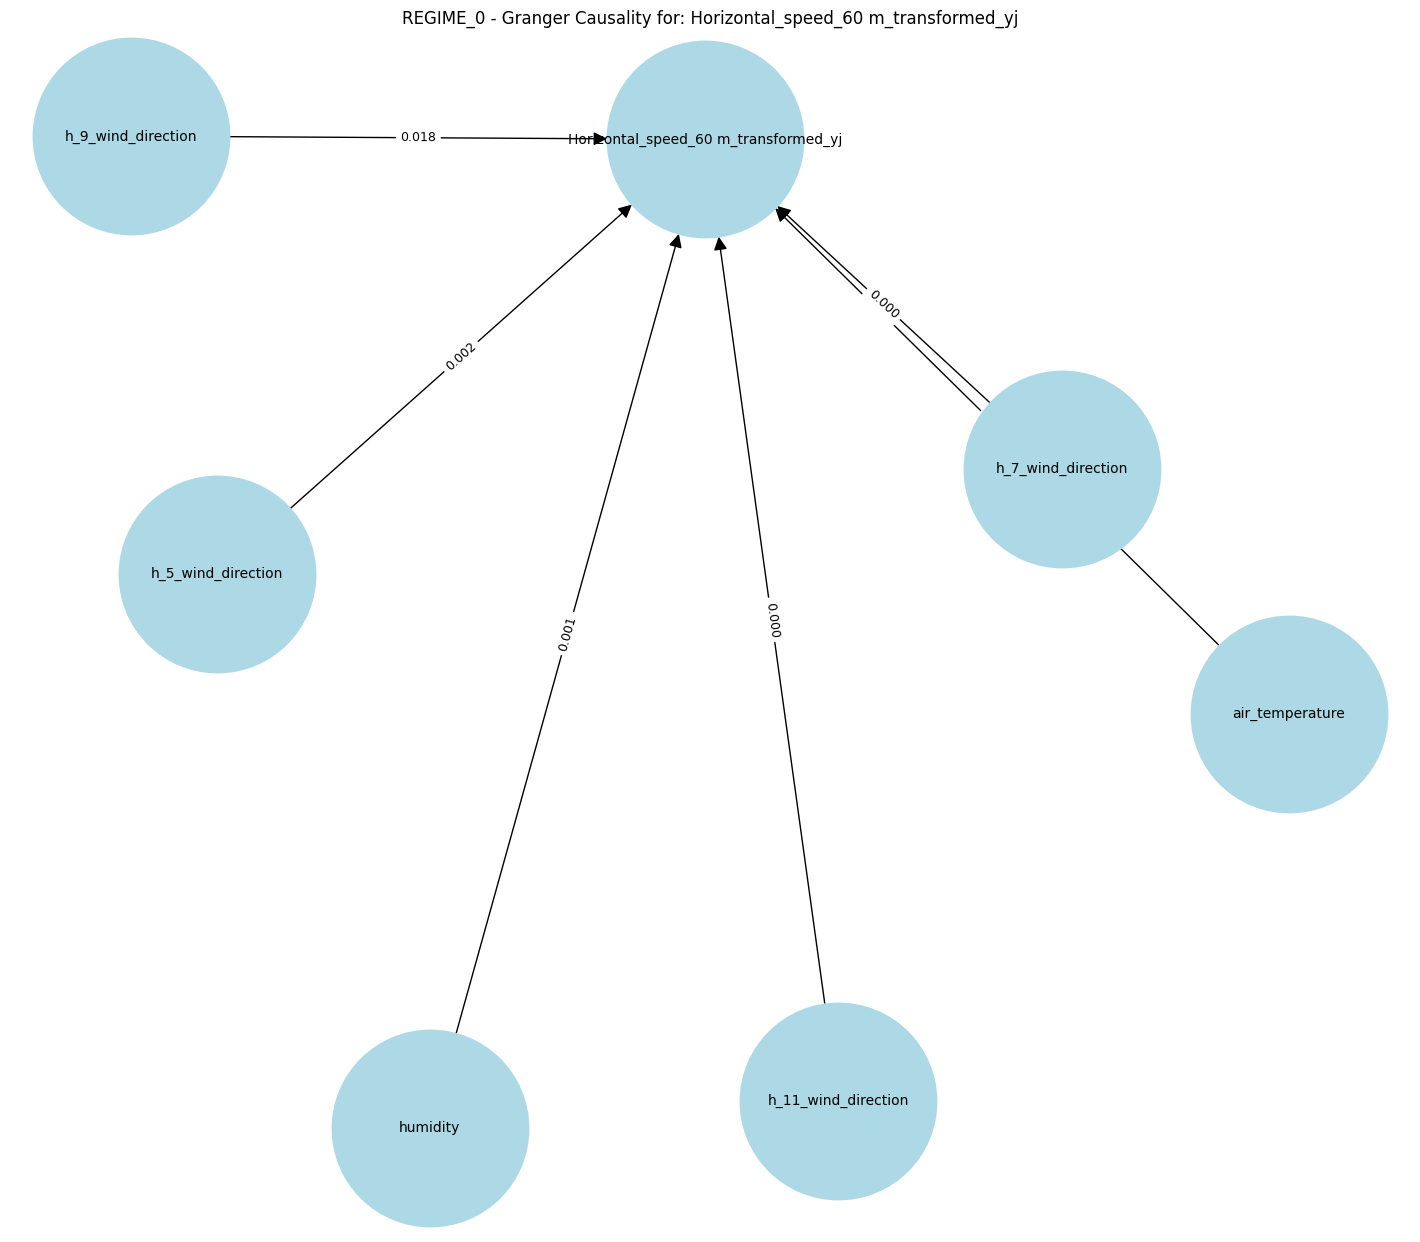

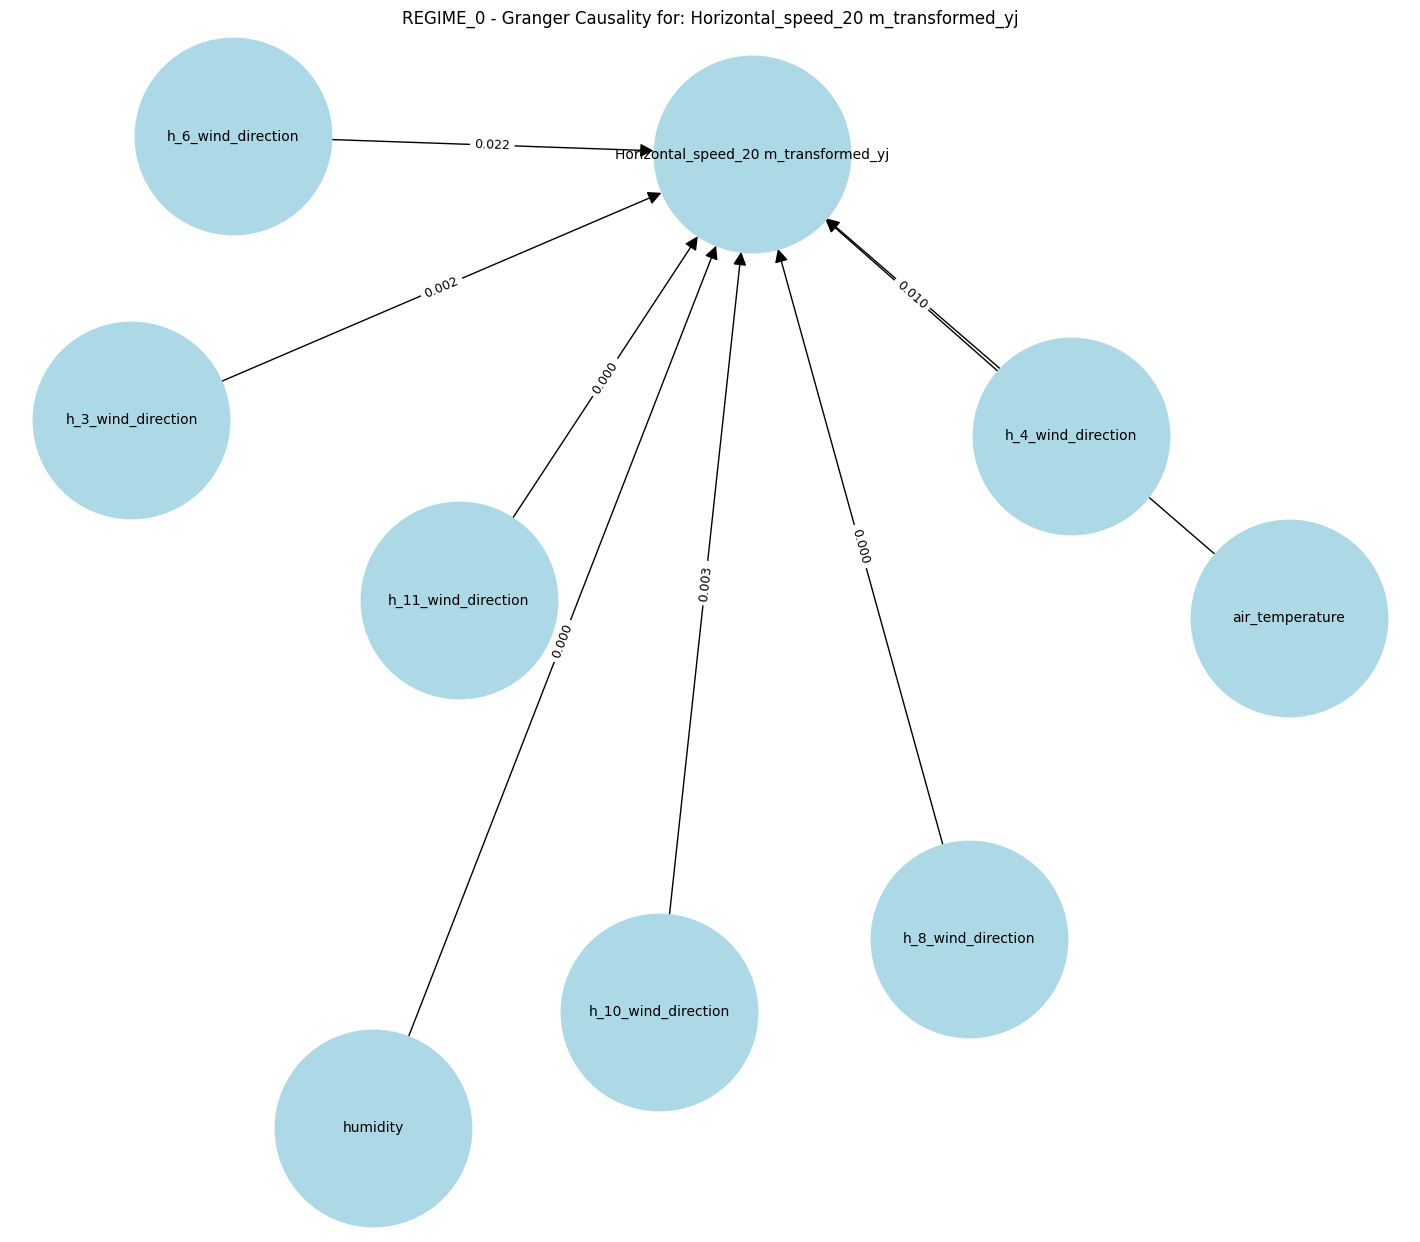

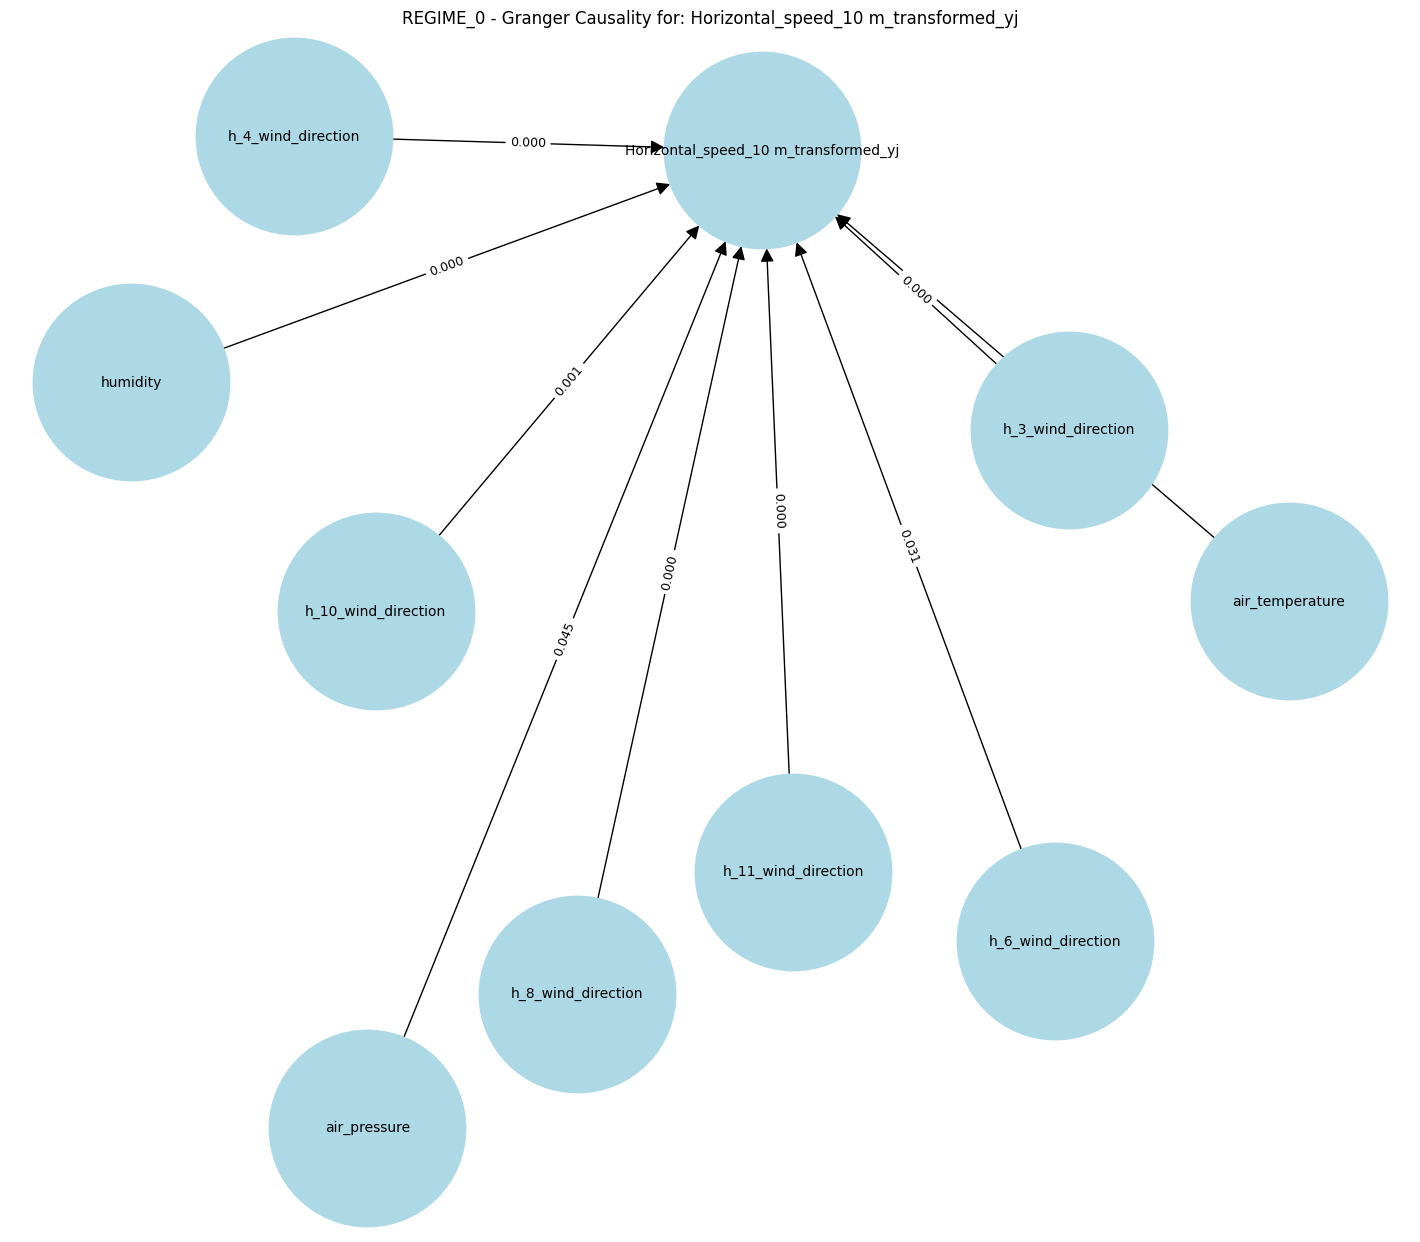

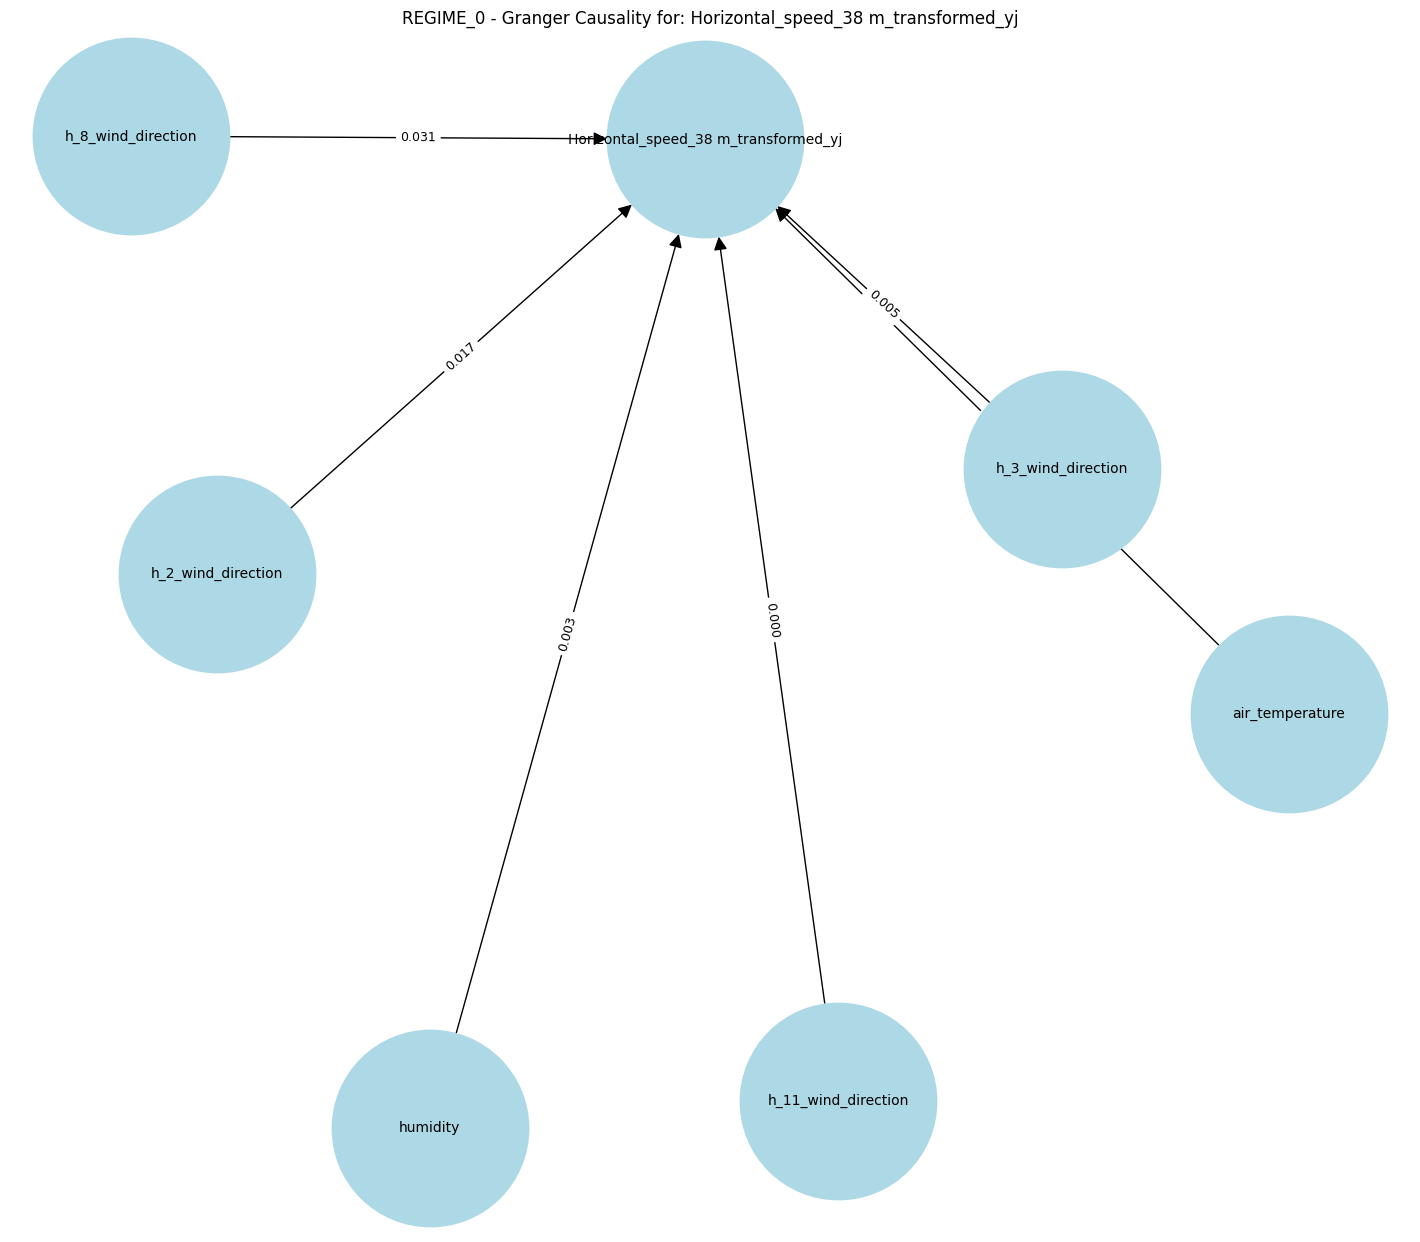

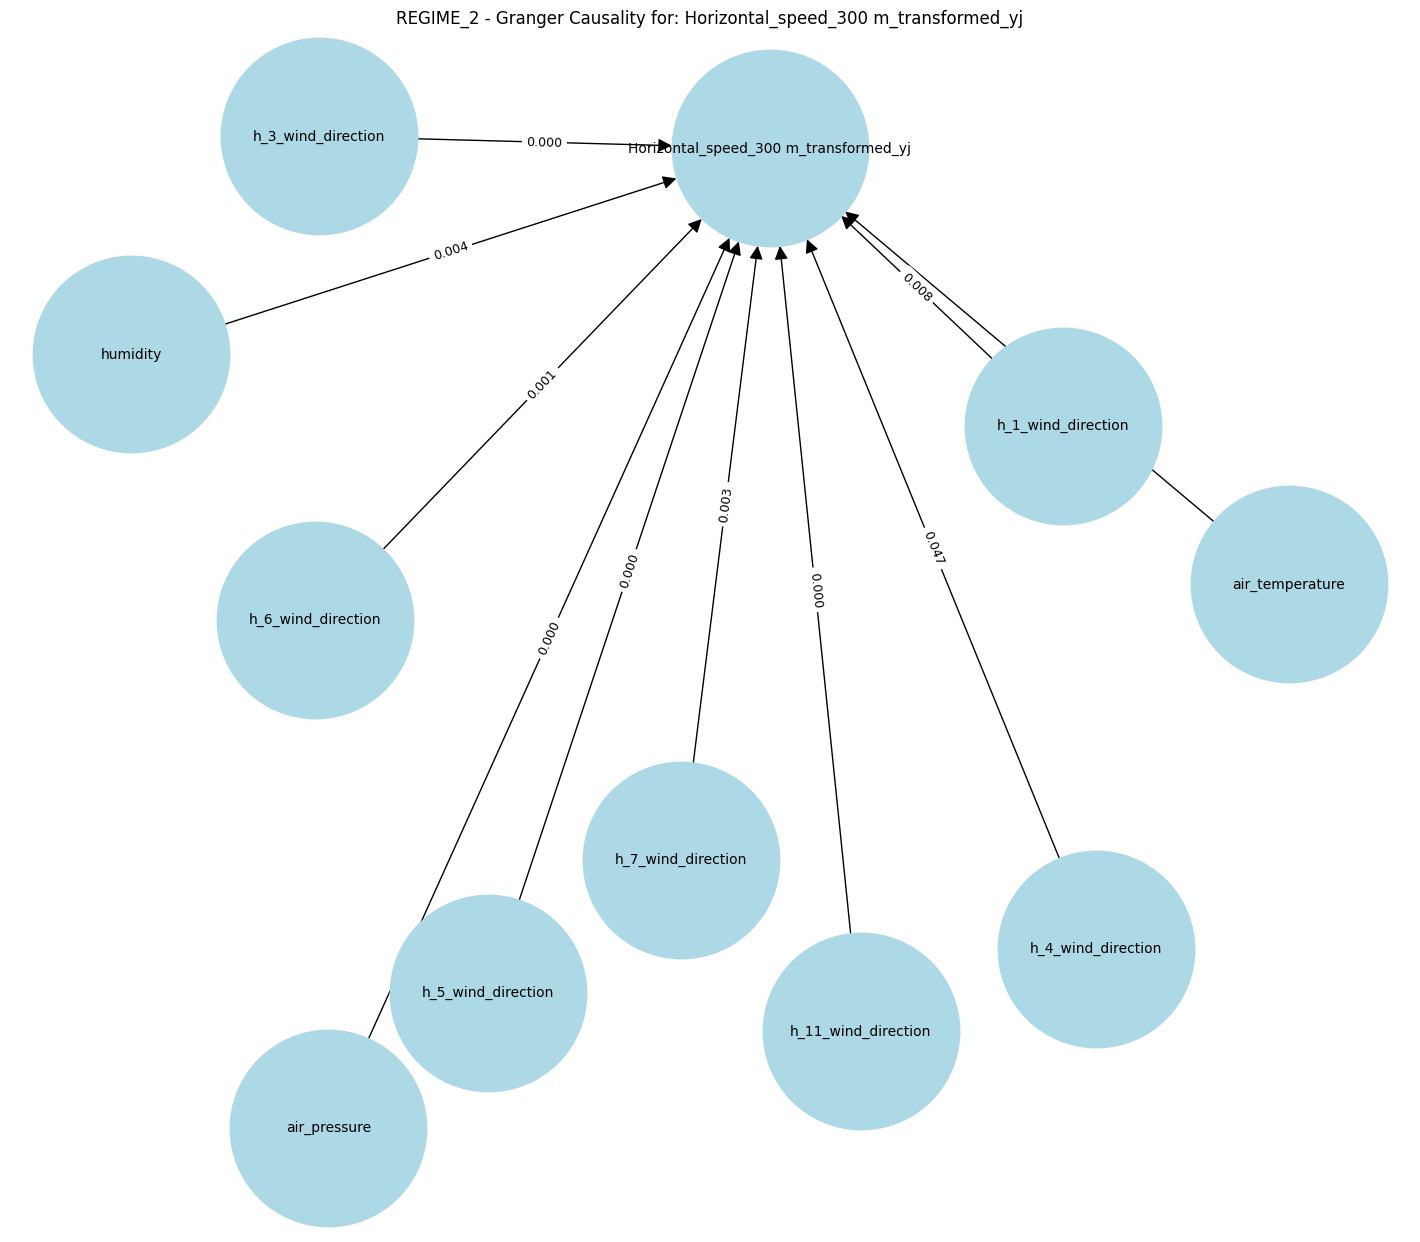

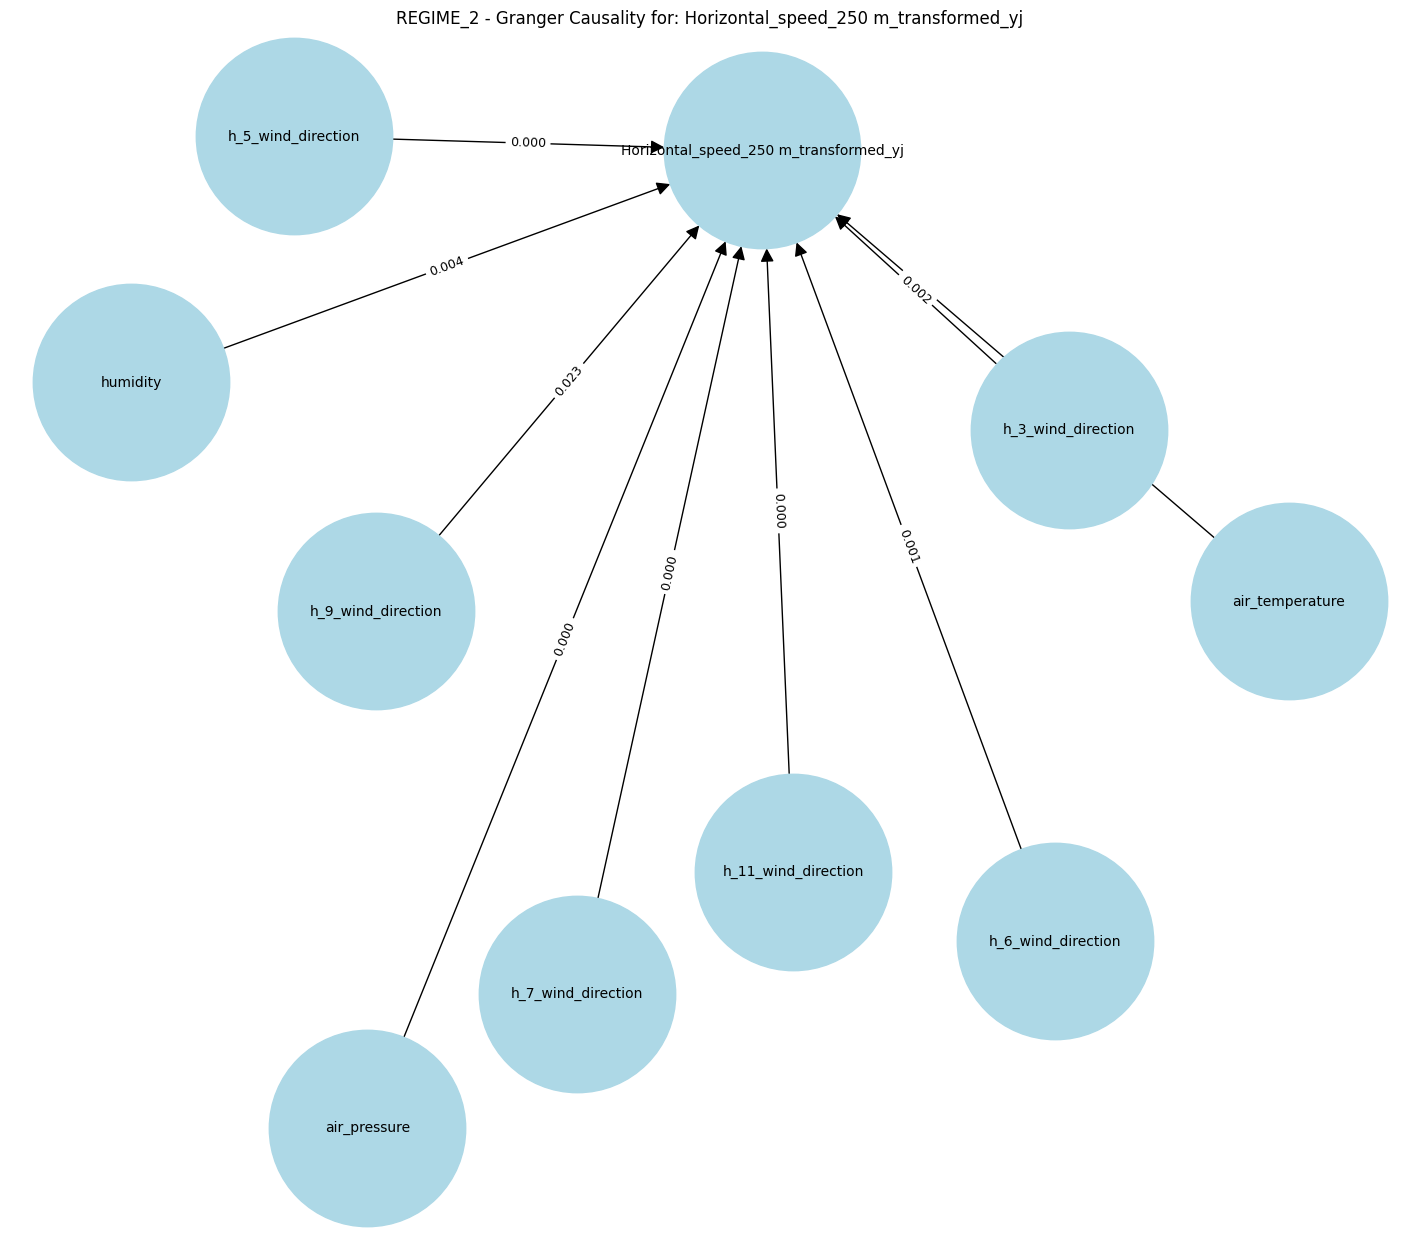

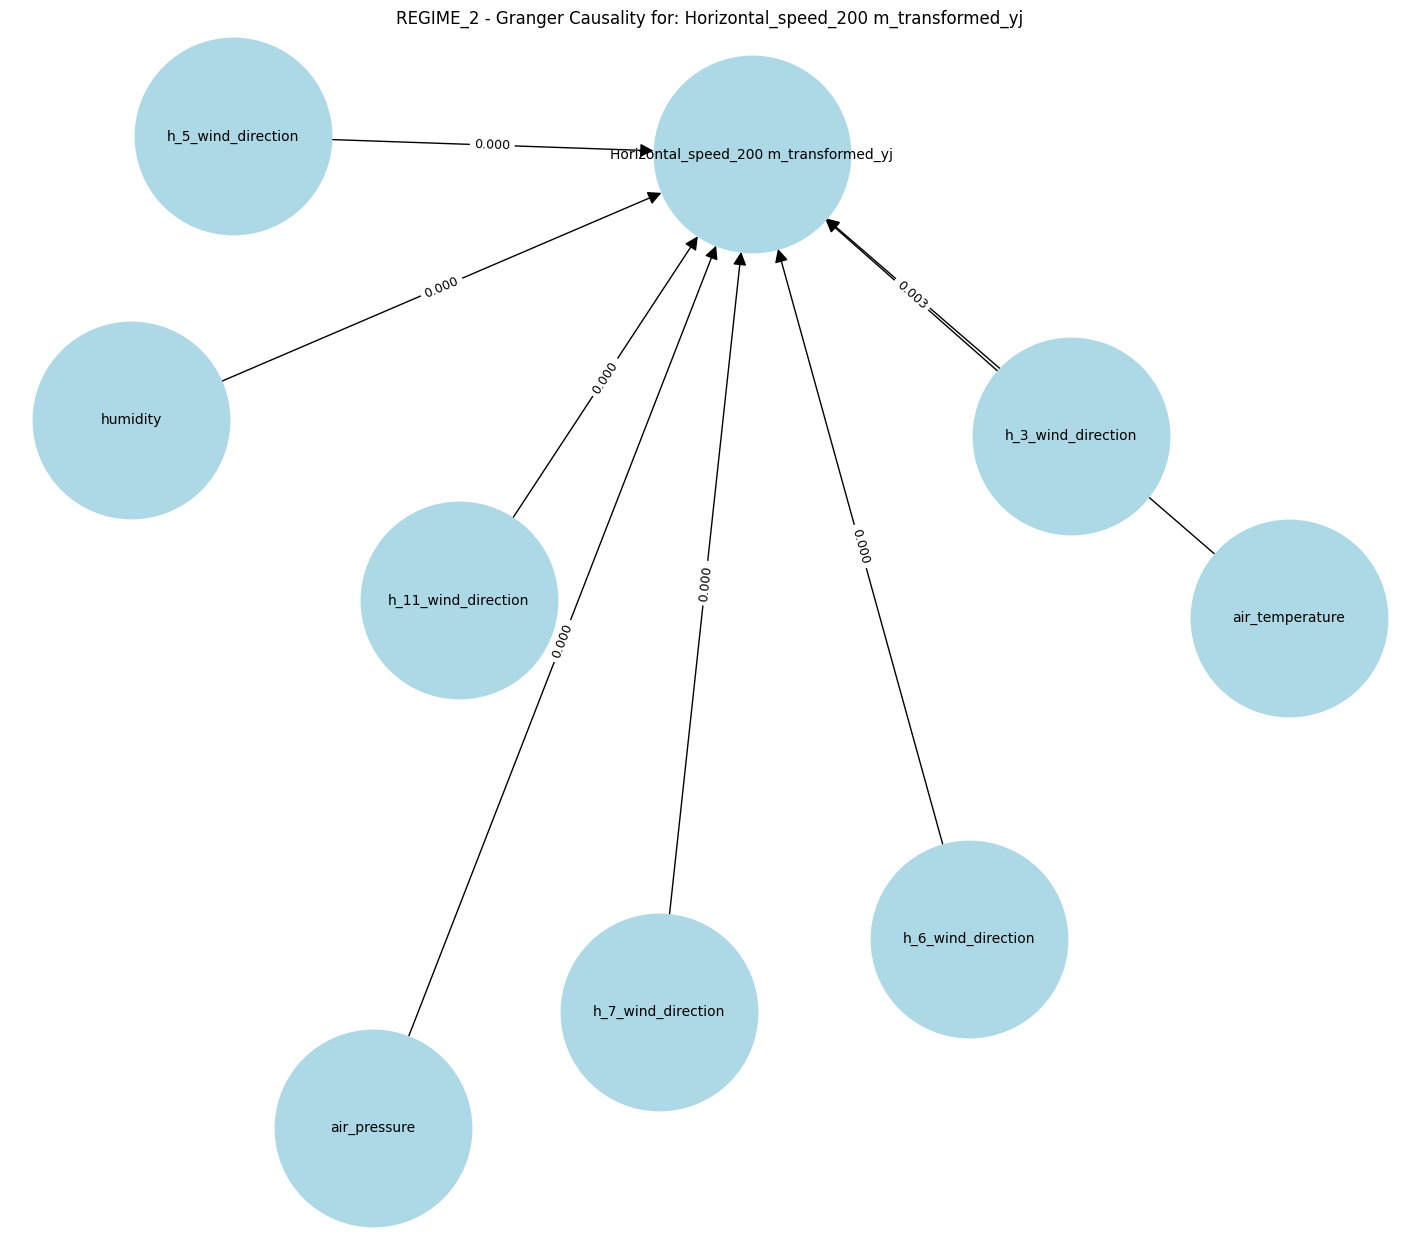

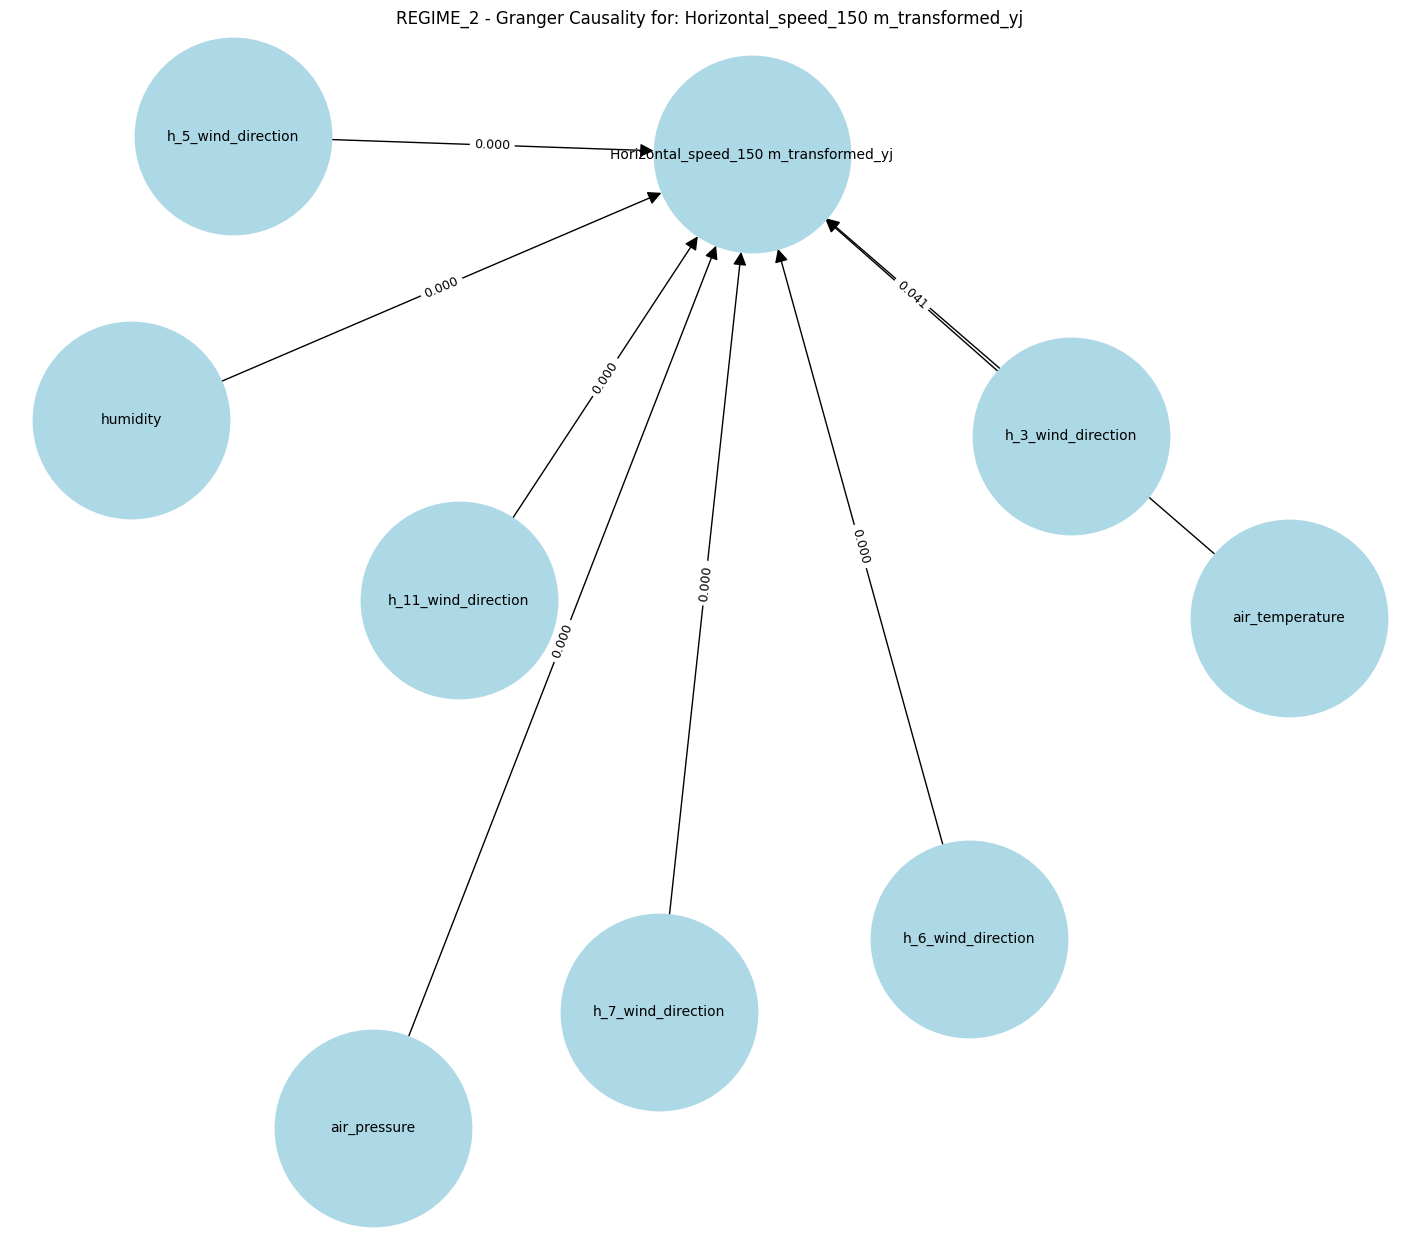

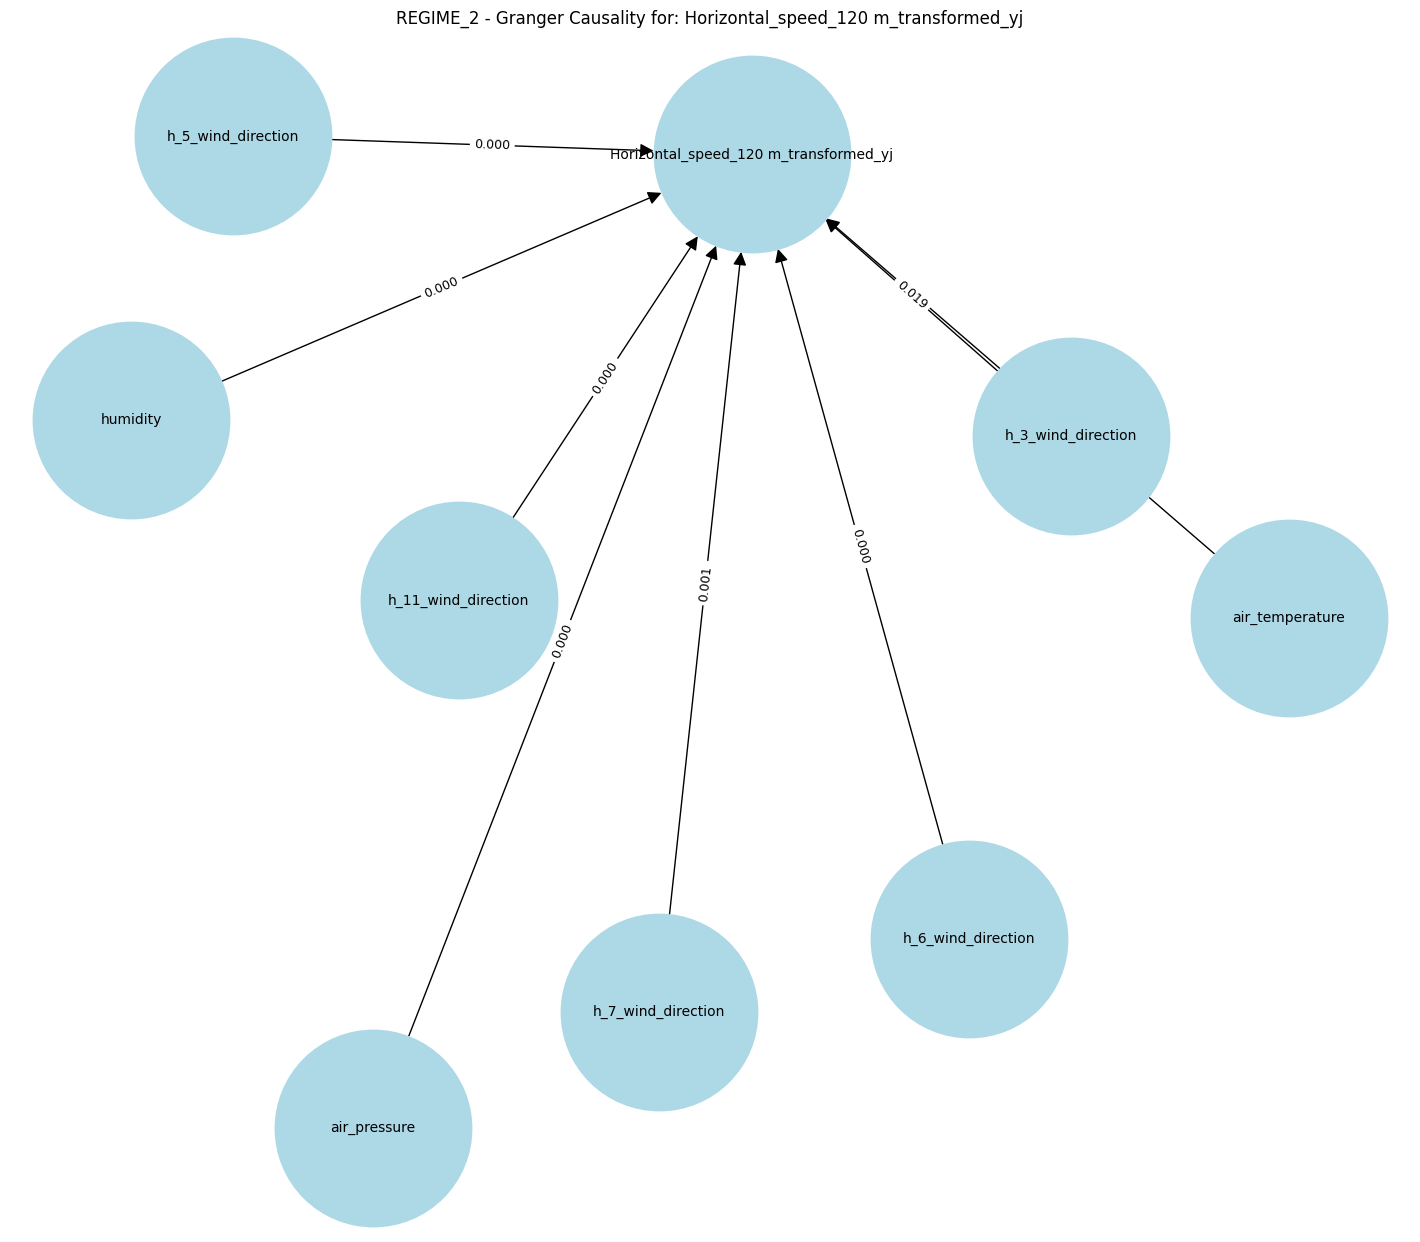

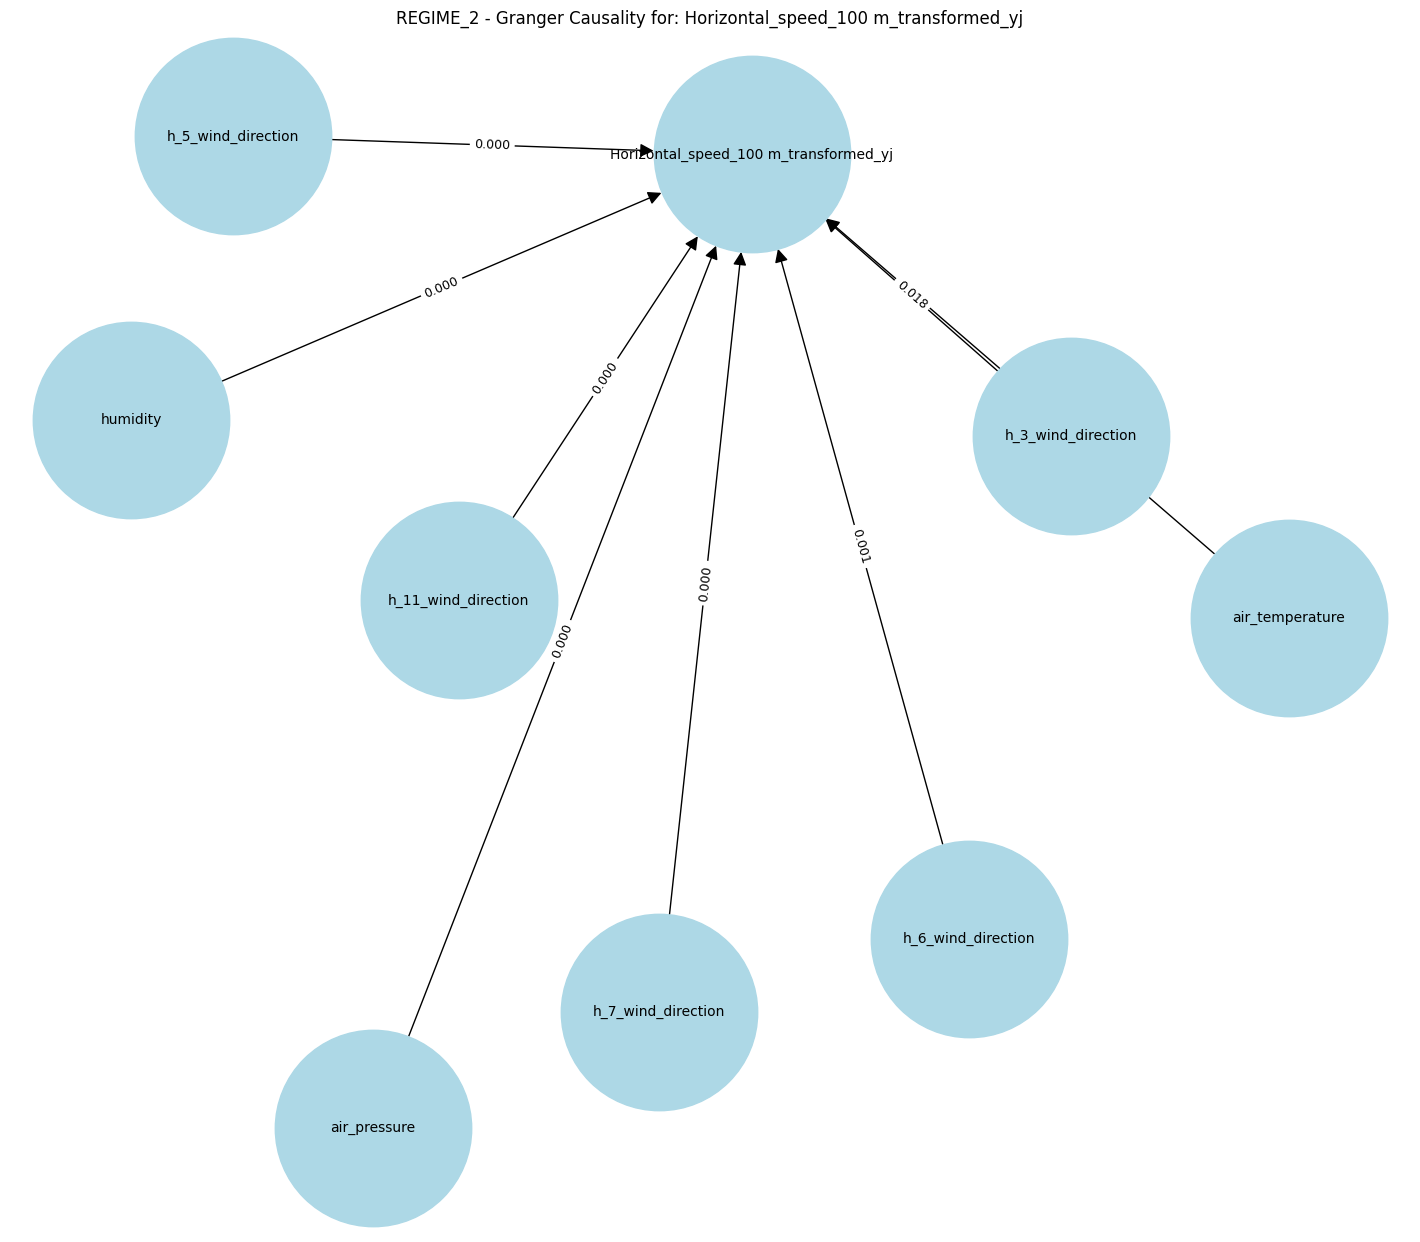

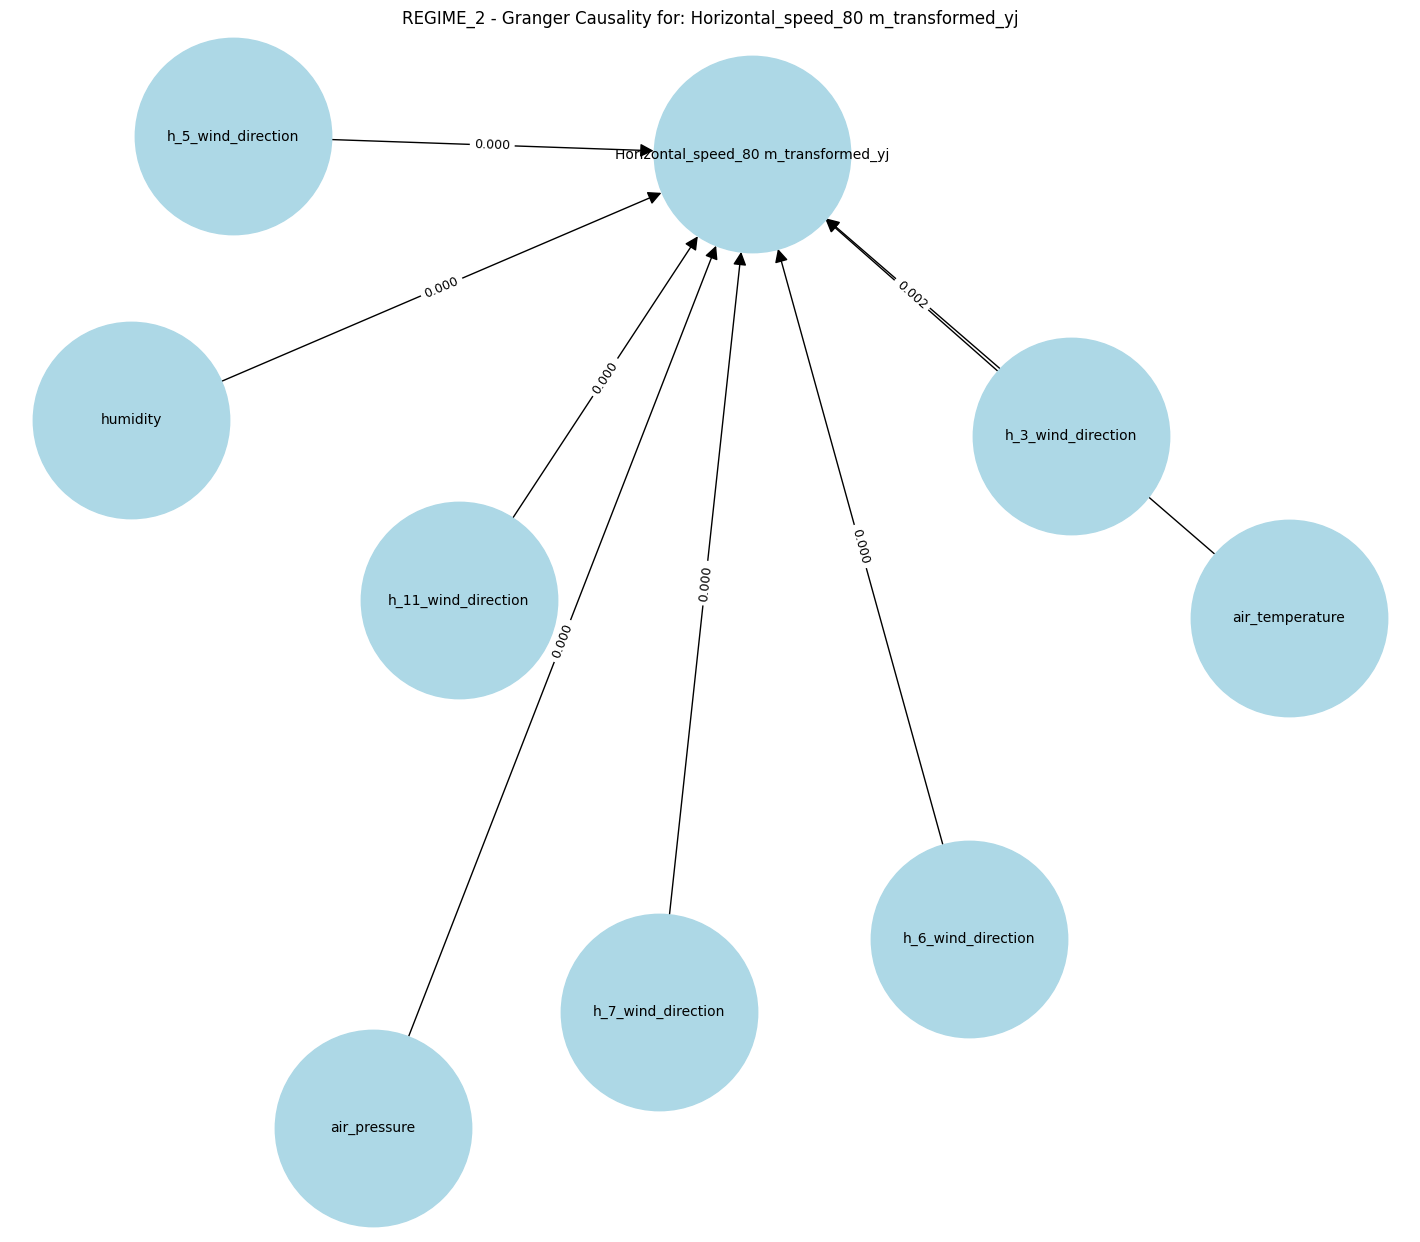

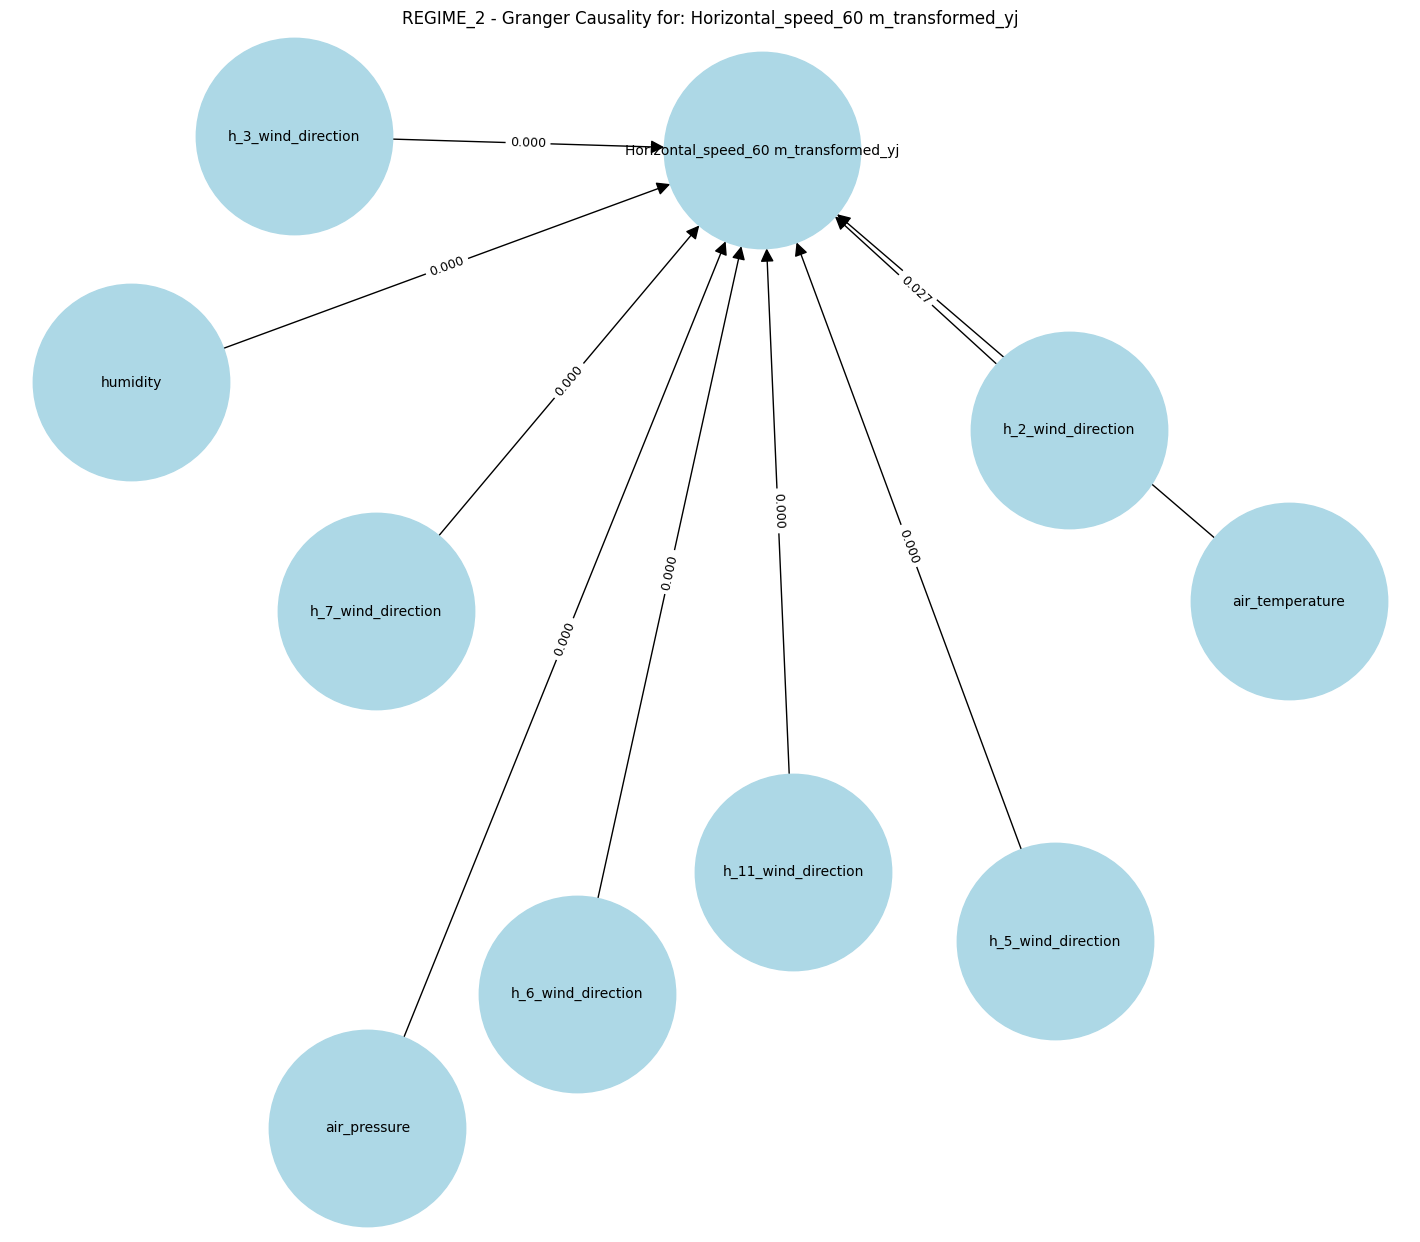

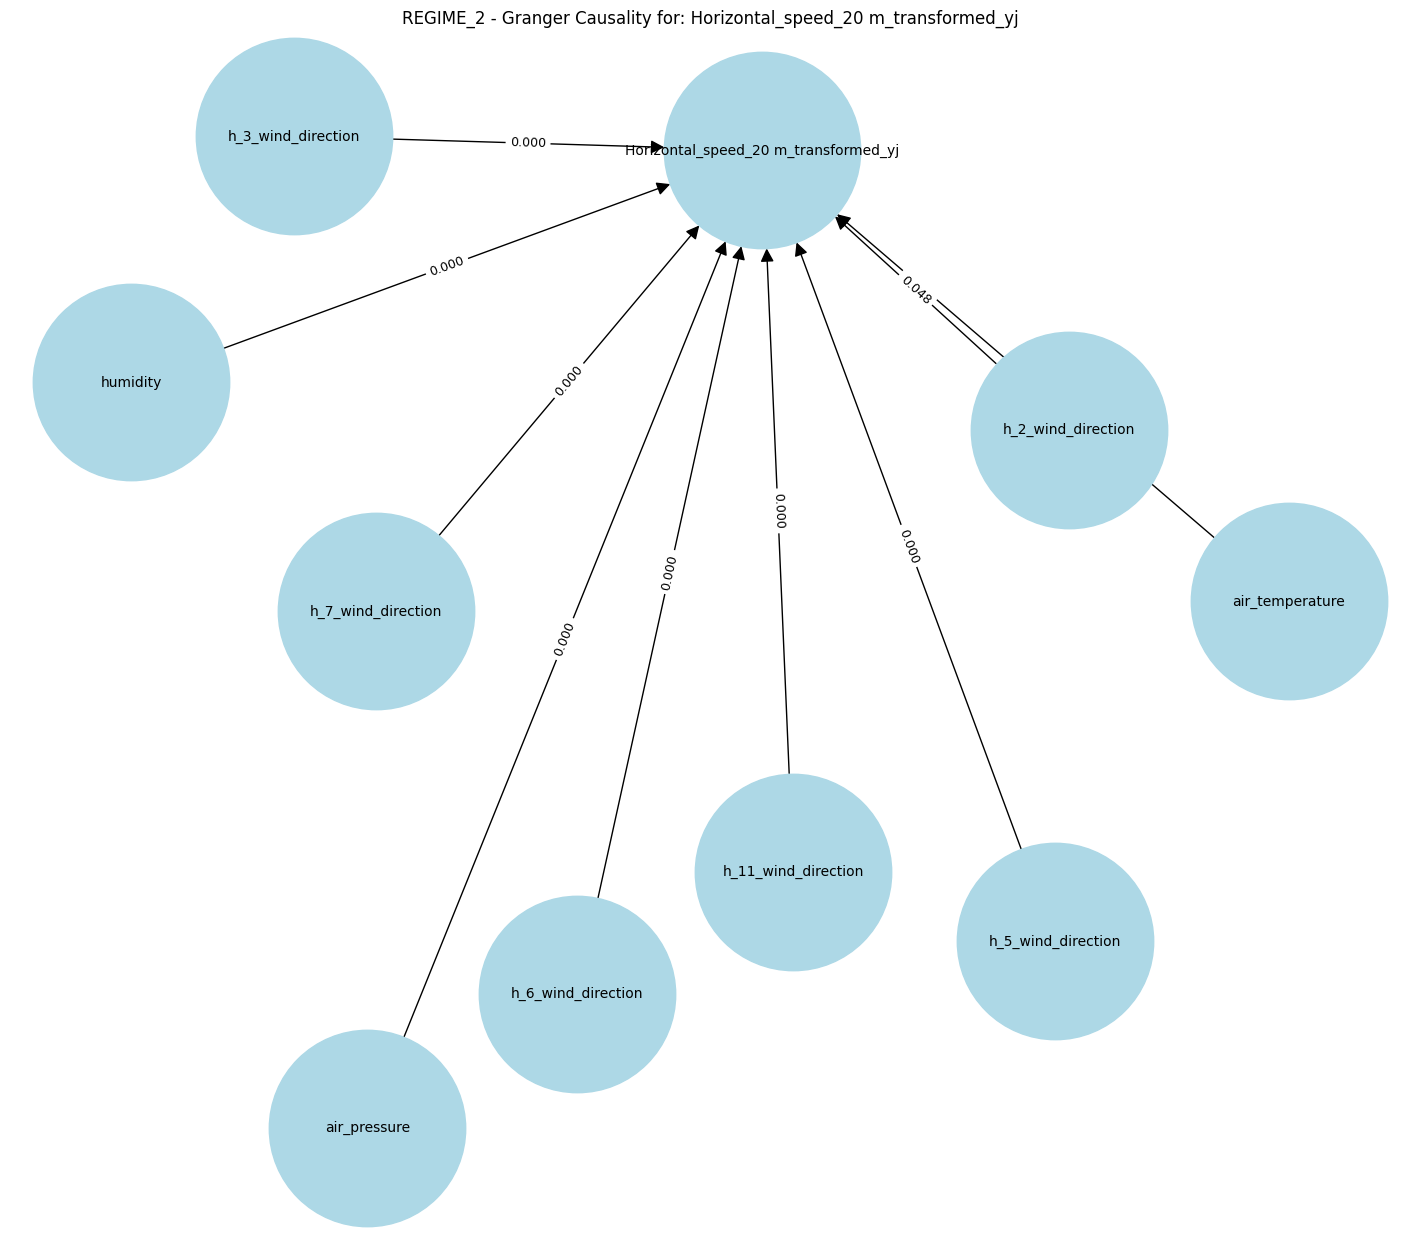

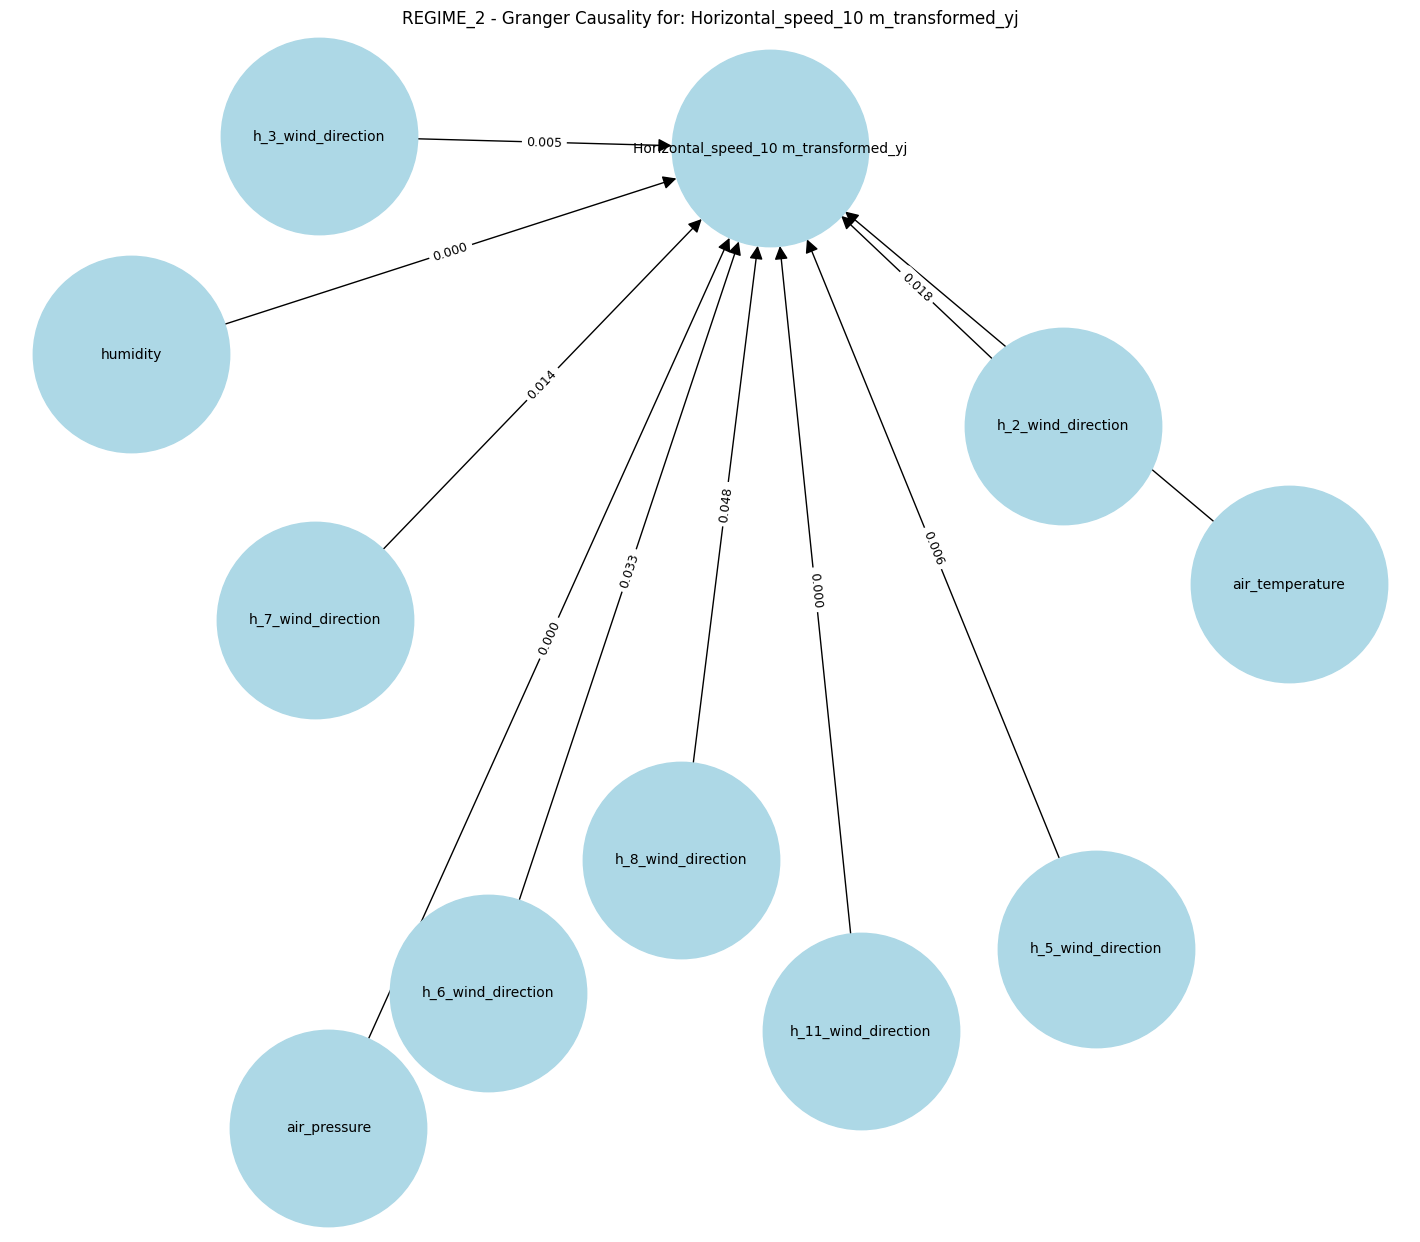

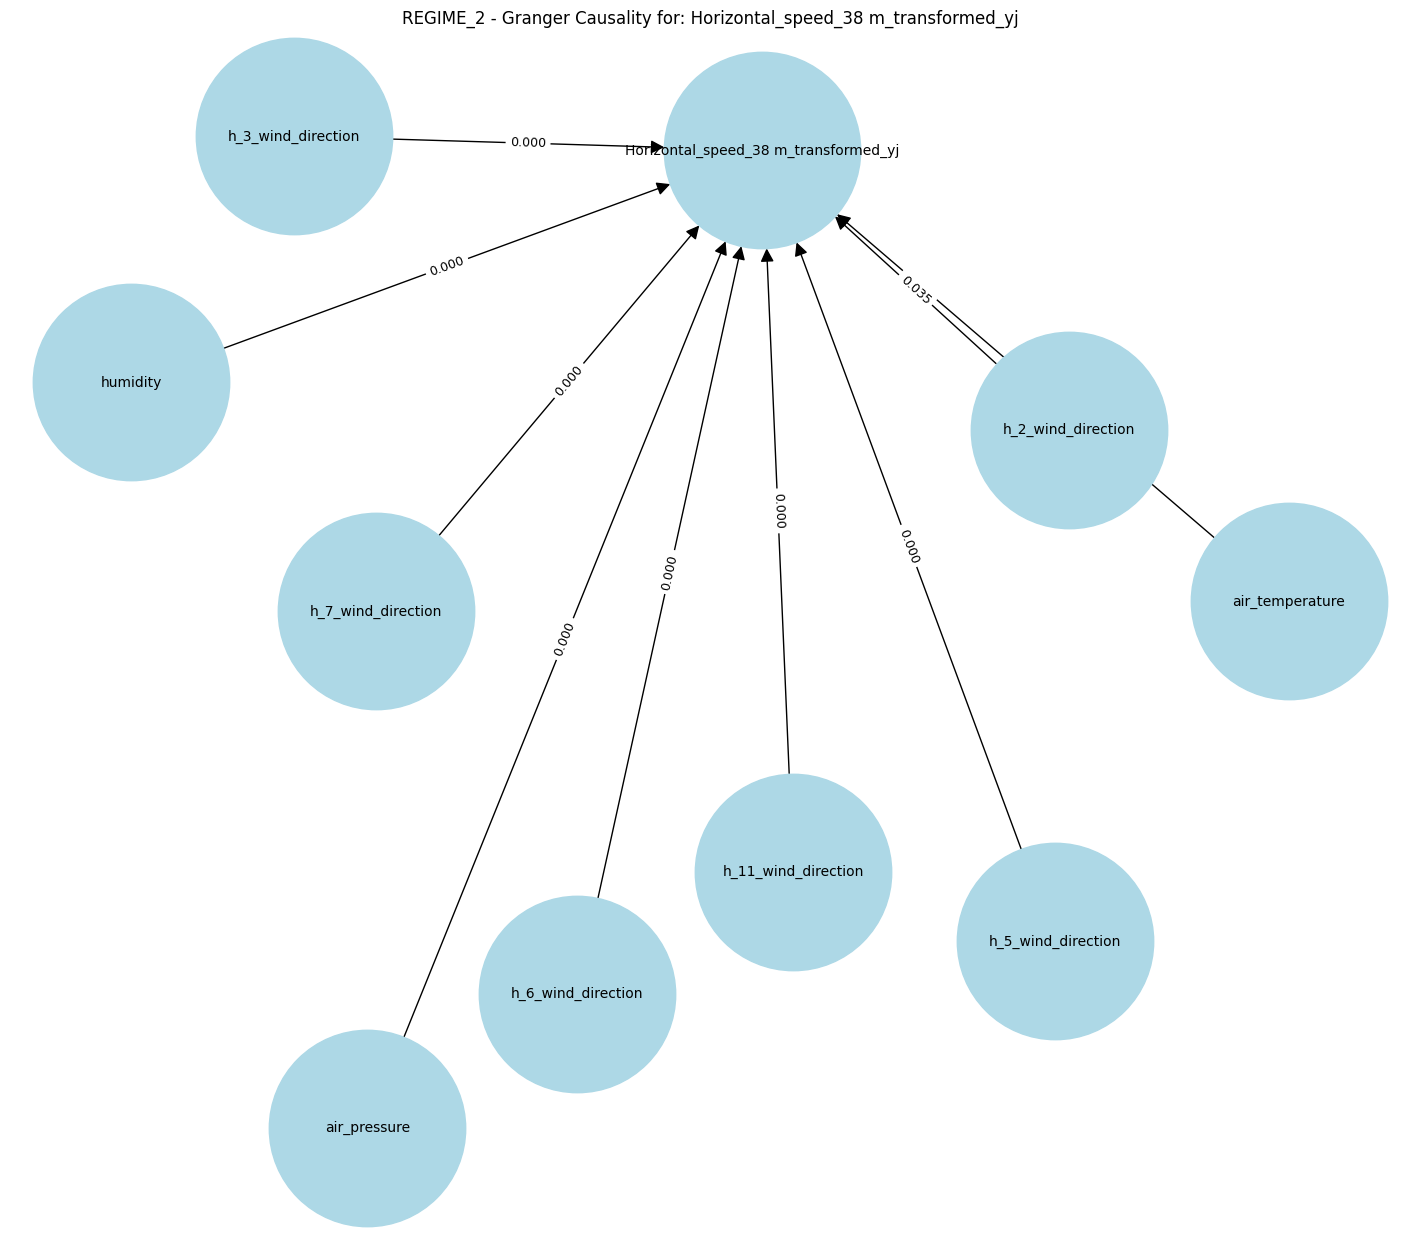

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_granger_graphs_per_target(granger_results, p_threshold=0.05):
    for regime, mat in granger_results.items():
        for target in mat.index:
            G = nx.DiGraph()
            influences = mat.loc[target].dropna()

            # Filter by significance threshold
            sig_influences = influences[influences < p_threshold]
            if sig_influences.empty:
                print(f"No significant influencers for {target} in {regime}")
                continue

            # Build graph
            G.add_node(target)
            for cause, pval in sig_influences.items():
                G.add_node(cause)
                G.add_edge(cause, target, label=f"{pval:.3f}")

            # Plot graph
            plt.figure(figsize=(14, 12))
            pos = nx.spring_layout(G, seed=42)

            nx.draw(G, pos, with_labels=True, node_color="lightblue",
                    node_size=20000, font_size=10, arrowsize=20)

            # Draw edge labels (p-values)
            edge_labels = nx.get_edge_attributes(G, 'label')
            nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,
                                         font_size=9, label_pos=0.5)

            plt.title(f"{regime.upper()} - Granger Causality for: {target}", fontsize=12)
            plt.axis("off")
            plt.tight_layout()
            plt.show()

# Run the visualization
draw_granger_graphs_per_target(gc_regime_results, p_threshold=0.05)

In [ ]:
df = df_selected.copy()

Anomaly Detection

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Step 5: Apply Isolation Forest for anomaly detection
# Prepare the data (exclude regime column and any non-numeric ones)
anomaly_df = df.drop(columns=['regime']).select_dtypes(include=[np.number])
anomaly_df = anomaly_df.dropna()  # Use dropna to avoid fitting on artificial zeros

# Scale features
scaler_if = StandardScaler()
X_scaled = scaler_if.fit_transform(anomaly_df)

# Fit Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iso_forest.fit(X_scaled)  # <-- Ensure fit is called before predict/decision_function

# Assign anomaly scores only to the rows used for fitting
df.loc[anomaly_df.index, 'anomaly_score'] = iso_forest.decision_function(X_scaled)
df.loc[anomaly_df.index, 'is_anomaly'] = iso_forest.predict(X_scaled) == -1

# Display summary
print("\n✅ Isolation Forest applied.")
print("Anomaly counts:")
print(df['is_anomaly'].value_counts())


✅ Isolation Forest applied.
Anomaly counts:
is_anomaly
False    152219
True       8012
Name: count, dtype: int64


In [ ]:
import pandas as pd

# Assume 'df', 'gc_regime_results', 'p_value_threshold' are already defined from previous steps.

# Get anomaly timestamps and their regimes
anomalies = df[df['is_anomaly'] == True].copy()

# Identify all target columns containing 'Horizontal_speed' in the original df
horizontal_speed_targets = [col for col in df.columns if 'Horizontal_speed' in col]

# Prepare a dictionary to store the new structured report
# Keys will be Timestamps, values will be dictionaries of {Horizontal_speed_col: reason_string}
detailed_anomaly_report_data = {}

for idx, row in anomalies.iterrows():
    ts = row['Timestamp']
    regime = row['regime']
    regime_key = f'regime_{regime}'
    granger_mat = gc_regime_results.get(regime_key)

    # Initialize entry for this timestamp with default empty strings/NaNs for all horizontal speed columns
    current_timestamp_reasons = {target: "" for target in horizontal_speed_targets}
    current_timestamp_reasons['Regime'] = regime # Add regime to the row

    if granger_mat is None:
        # If no Granger matrix, fill all target columns for this timestamp with a specific message
        for target_col in horizontal_speed_targets:
            current_timestamp_reasons[target_col] = "No Granger matrix available"
        detailed_anomaly_report_data[ts] = current_timestamp_reasons
        continue

    # Filter Granger matrix targets to include only relevant Horizontal_speed columns
    relevant_granger_targets = [target for target in granger_mat.index if target in horizontal_speed_targets]

    if not relevant_granger_targets:
        # If no relevant targets, fill all target columns for this timestamp with a specific message
        for target_col in horizontal_speed_targets:
            current_timestamp_reasons[target_col] = "No relevant Granger targets for this regime"
        detailed_anomaly_report_data[ts] = current_timestamp_reasons
        continue

    # For each relevant Horizontal_speed target variable, find significant influencers
    for target in relevant_granger_targets:
        target_reasons = [] # Reasons specific to this target column
        influences = granger_mat.loc[target].dropna()
        sig_influences = influences[influences < p_value_threshold]

        for cause, pval in sig_influences.items():
            if cause in anomalies.columns:
                # Check for large change in the cause variable at the anomaly timestamp
                # Use anomalies[cause].std() as a crude threshold for significant change
                if abs(row.get(cause, 0)) > anomalies[cause].std():
                    target_reasons.append(f"{cause} (p={pval:.3f})")
            else:
                pass # Cause column not found in anomaly row, ignore or log if needed

        if target_reasons:
            current_timestamp_reasons[target] = ",".join(target_reasons)
        else:
            current_timestamp_reasons[target] = "No significant influences"

    detailed_anomaly_report_data[ts] = current_timestamp_reasons

# Convert the dictionary of dictionaries to a DataFrame
# The keys of detailed_anomaly_report_data (Timestamps) will become the index.
anomaly_reason_df = pd.DataFrame.from_dict(detailed_anomaly_report_data, orient='index')

# Rename the index to 'Timestamp'
anomaly_reason_df.index.name = 'Timestamp'

# Reorder columns to have 'Regime' first, then Horizontal_speed columns
ordered_columns = ['Regime'] + sorted(horizontal_speed_targets)
anomaly_reason_df = anomaly_reason_df[ordered_columns]

print(anomaly_reason_df)

# Optional: Save to CSV
# anomaly_reason_df.to_csv('C:\\Users\\ariji\\Downloads\\granger_causality_anomaly_reasons.csv')

                  Regime               Horizontal_speed_10 m_transformed_yj  \
Timestamp                                                                     
2015-01-01 10:00       1  air_temperature (p=0.000),air_pressure (p=0.00...   
2015-01-01 10:20       1  air_temperature (p=0.000),air_pressure (p=0.00...   
2015-01-01 11:00       1  air_temperature (p=0.000),air_pressure (p=0.00...   
2015-01-01 11:10       0  air_temperature (p=0.000),air_pressure (p=0.04...   
2015-01-01 11:20       0  air_temperature (p=0.000),air_pressure (p=0.04...   
...                  ...                                                ...   
2018-12-26 20:50       1          air_pressure (p=0.000),humidity (p=0.000)   
2018-12-30 02:20       1          air_pressure (p=0.000),humidity (p=0.000)   
2018-12-30 10:10       1  air_temperature (p=0.000),air_pressure (p=0.00...   
2018-12-30 10:30       1  air_temperature (p=0.000),air_pressure (p=0.00...   
2018-12-30 10:40       1  air_temperature (p=0.000),

In [ ]:
anomaly_reason_df.to_csv("C:\\Users\\ariji\\Downloads\\anomaly_reason_report.csv")

In [ ]:
print(df.head(50))

           Timestamp  air_temperature  air_pressure   humidity  \
0   2015-01-01 00:10             5.90   1014.000000  56.400002   
1   2015-01-01 00:20             5.55   1013.799988  58.790001   
2   2015-01-01 00:30             5.63   1014.200012  57.590000   
3   2015-01-01 00:40             5.53   1014.099976  59.790001   
4   2015-01-01 00:50             5.26   1014.000000  60.290001   
5   2015-01-01 01:00             5.11   1013.900024  60.290001   
6   2015-01-01 01:10             4.53   1014.000000  60.400002   
7   2015-01-01 01:20             3.98   1014.200012  64.000000   
8   2015-01-01 01:30             3.26   1014.200012  65.690002   
9   2015-01-01 01:40             3.08   1014.200012  67.000000   
10  2015-01-01 01:50             3.80   1014.299988  63.700001   
11  2015-01-01 02:00             4.50   1014.400024  62.700001   
12  2015-01-01 02:10             5.15   1014.500000  58.900002   
13  2015-01-01 02:20             5.74   1014.599976  56.200001   
14  2015-0

In [ ]:
df.to_csv('C:\\Users\\ariji\\Downloads\\ZephIR_Data_2015_2018_transformed_with_regimes_anomaly_scores.csv')

In [ ]:
import pandas as pd
df = pd.read_csv('C:\\Users\\ariji\\Downloads\\ZephIR_Data_2015_2018_transformed_with_regimes_anomaly_scores.csv')
# df.index = pd.DatetimeIndex(df.index).to_period('10min')
print(df.head(50))

           Timestamp  air_temperature  air_pressure   humidity  \
0   2015-01-01 00:10             5.90   1014.000000  56.400002   
1   2015-01-01 00:20             5.55   1013.799988  58.790001   
2   2015-01-01 00:30             5.63   1014.200012  57.590000   
3   2015-01-01 00:40             5.53   1014.099976  59.790001   
4   2015-01-01 00:50             5.26   1014.000000  60.290001   
5   2015-01-01 01:00             5.11   1013.900024  60.290001   
6   2015-01-01 01:10             4.53   1014.000000  60.400002   
7   2015-01-01 01:20             3.98   1014.200012  64.000000   
8   2015-01-01 01:30             3.26   1014.200012  65.690002   
9   2015-01-01 01:40             3.08   1014.200012  67.000000   
10  2015-01-01 01:50             3.80   1014.299988  63.700001   
11  2015-01-01 02:00             4.50   1014.400024  62.700001   
12  2015-01-01 02:10             5.15   1014.500000  58.900002   
13  2015-01-01 02:20             5.74   1014.599976  56.200001   
14  2015-0

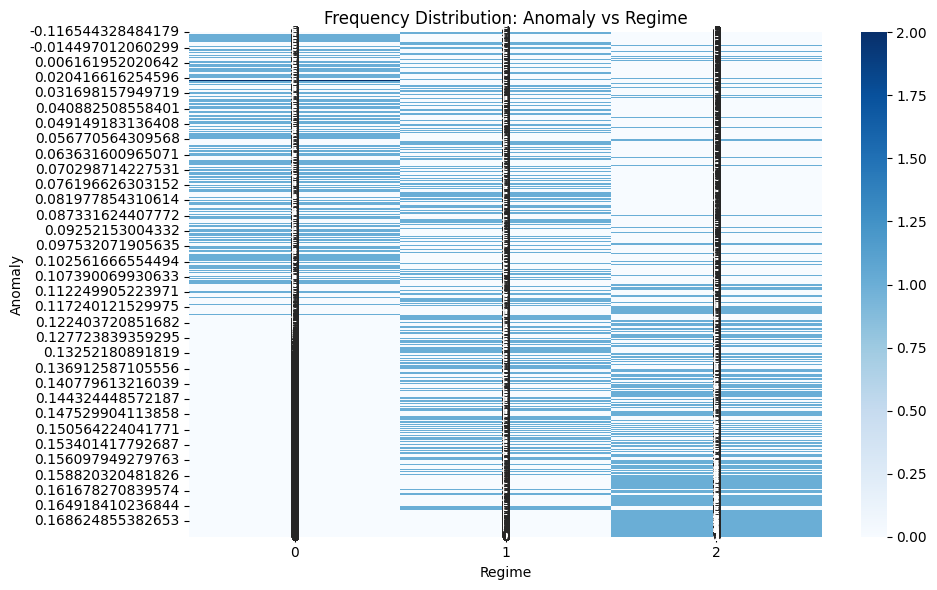

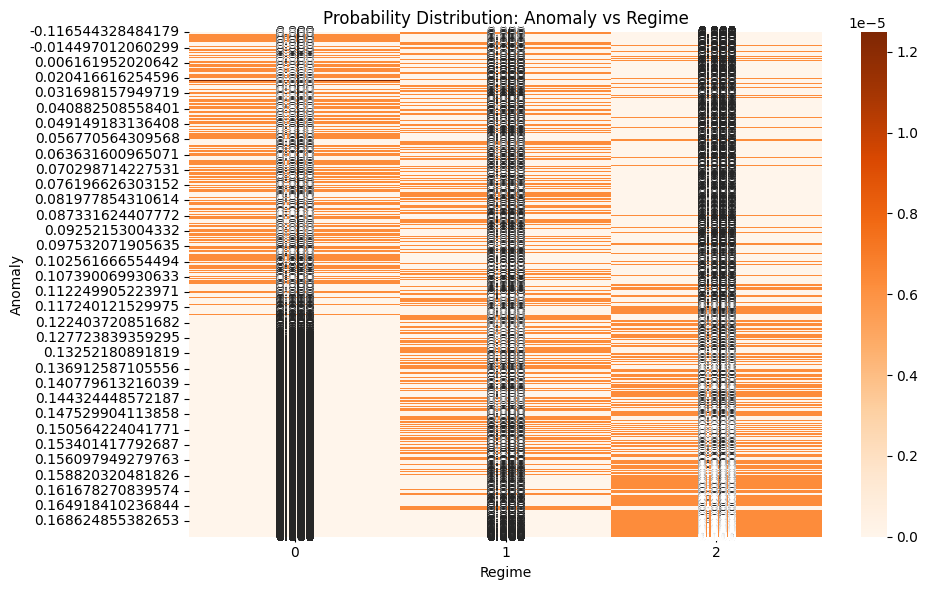

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Ensure required columns exist ---
if 'anomaly_score' not in df.columns or 'regime' not in df.columns:
    raise ValueError("Both 'anomaly' and 'regime' columns must exist in the DataFrame.")

# --- Frequency Distribution ---
frequency_table = pd.crosstab(df['anomaly_score'], df['regime'])

# --- Probability Distribution ---
probability_table = frequency_table.div(frequency_table.sum().sum())

# --- Plot Frequency Heatmap ---
plt.figure(figsize=(10, 6))
sns.heatmap(frequency_table, annot=True, fmt='d', cmap='Blues')
plt.title('Frequency Distribution: Anomaly vs Regime')
plt.xlabel('Regime')
plt.ylabel('Anomaly')
plt.tight_layout()
plt.show()

# --- Plot Probability Heatmap ---
plt.figure(figsize=(10, 6))
sns.heatmap(probability_table, annot=True, fmt='.3f', cmap='Oranges')
plt.title('Probability Distribution: Anomaly vs Regime')
plt.xlabel('Regime')
plt.ylabel('Anomaly')
plt.tight_layout()
plt.show()


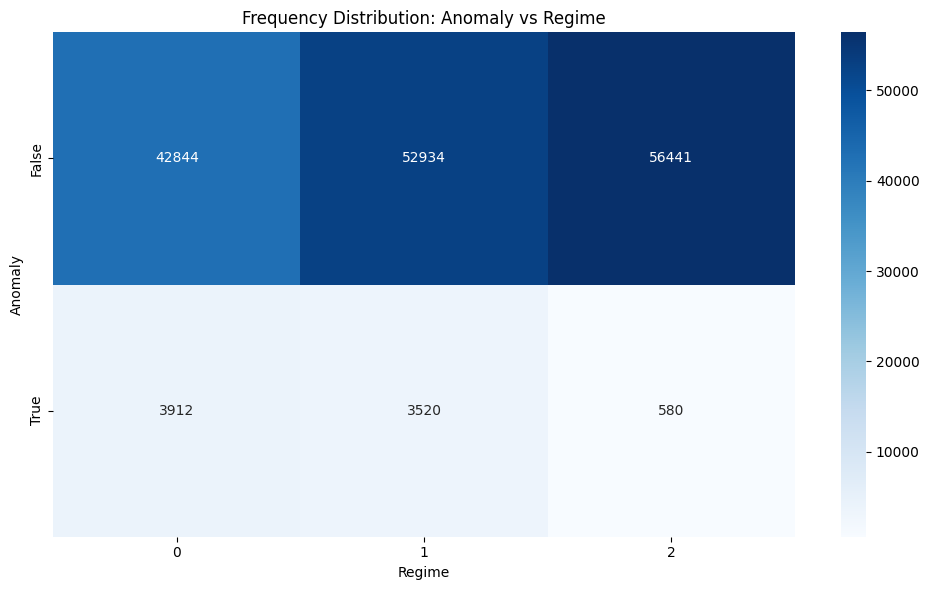

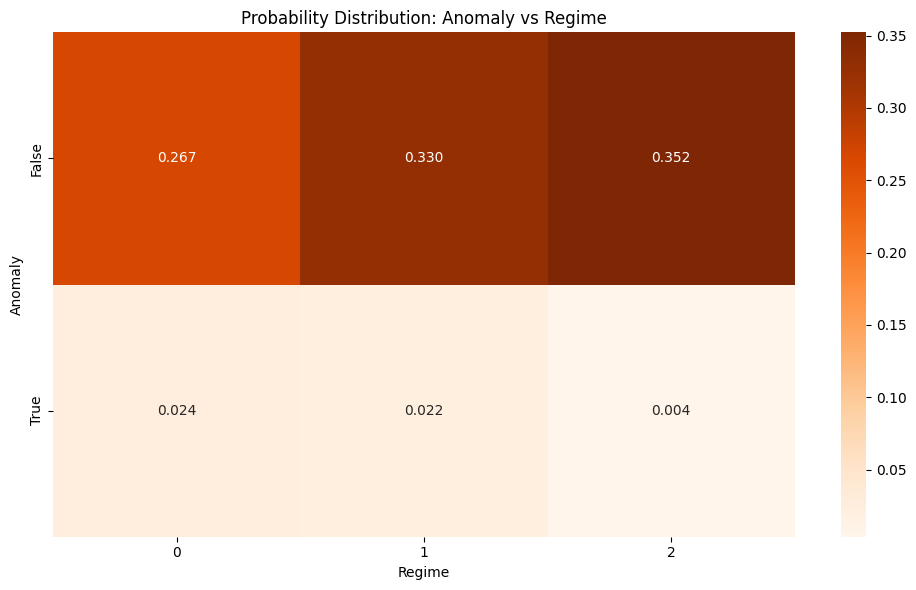

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Ensure required columns exist ---
if 'is_anomaly' not in df.columns or 'regime' not in df.columns:
    raise ValueError("Both 'anomaly' and 'regime' columns must exist in the DataFrame.")

# --- Frequency Distribution ---
frequency_table = pd.crosstab(df['is_anomaly'], df['regime'])

# --- Probability Distribution ---
probability_table = frequency_table.div(frequency_table.sum().sum())

# --- Plot Frequency Heatmap ---
plt.figure(figsize=(10, 6))
sns.heatmap(frequency_table, annot=True, fmt='d', cmap='Blues')
plt.title('Frequency Distribution: Anomaly vs Regime')
plt.xlabel('Regime')
plt.ylabel('Anomaly')
plt.tight_layout()
plt.show()

# --- Plot Probability Heatmap ---
plt.figure(figsize=(10, 6))
sns.heatmap(probability_table, annot=True, fmt='.3f', cmap='Oranges')
plt.title('Probability Distribution: Anomaly vs Regime')
plt.xlabel('Regime')
plt.ylabel('Anomaly')
plt.tight_layout()
plt.show()


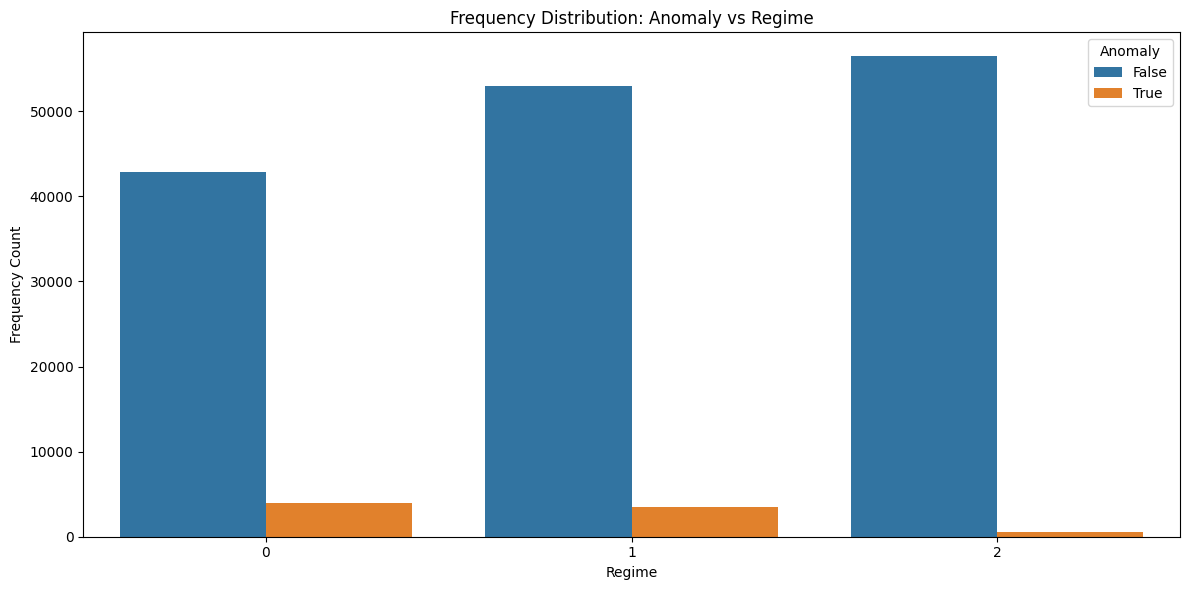

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Ensure required columns exist ---
if 'is_anomaly' not in df.columns or 'regime' not in df.columns:
    raise ValueError("Both 'anomaly' and 'regime' columns must exist in the DataFrame.")

# --- Frequency Distribution ---
frequency_table = pd.crosstab(df['is_anomaly'], df['regime'])

# --- Melt the DataFrame for Seaborn barplot ---
melted_freq = frequency_table.reset_index().melt(id_vars='is_anomaly', var_name='regime', value_name='count')

# --- Plot Grouped Histogram (Bar Chart) ---
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_freq, x='regime', y='count', hue='is_anomaly')
plt.title('Frequency Distribution: Anomaly vs Regime')
plt.xlabel('Regime')
plt.ylabel('Frequency Count')
plt.legend(title='Anomaly')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.preprocessing import MinMaxScaler
import warnings
import os
import gc

# ... (Previous code for configuration, warnings, df loading, etc., remains the same) ...

# --- Configuration for Batching ---
output_dir = 'ets_fitted_values_batches_regime_level'
os.makedirs(output_dir, exist_ok=True)

#warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge.")

if isinstance(df.index, pd.PeriodIndex):
    print("Converting df.index from PeriodIndex to DatetimeIndex for ETSModel compatibility.")
    df.index = df.index.to_timestamp()

if not isinstance(df.index, pd.DatetimeIndex):
    raise TypeError("df.index must be a DatetimeIndex for ETSModel.")

if 'regime' not in df.columns:
    raise ValueError("Run the HMM cell first to assign regimes.")

df.index = pd.DatetimeIndex(df.index).to_period('10min')
horizontal_speed_cols = [col for col in df.columns if 'Horizontal_speed' in col]

if not horizontal_speed_cols:
    print("No 'Horizontal_speed' columns found. Skipping ETS forecasting.")
else:
    # --- Outer loop: Process each target column ---
    for target_col in horizontal_speed_cols:
        print(f"\n--- Processing target variable: {target_col} (Regime-wise batches) ---")

        # Inner loop: Process each regime for the current target column
        for regime in sorted(df['regime'].unique()):
            print(f"  Processing regime {regime} for {target_col}")

            regime_mask = df['regime'] == regime
            regime_series_original = df.loc[regime_mask, target_col]

            if len(regime_series_original) < 10:
                print(f"    Skipping regime {regime} for {target_col}: not enough data for ETS (requires >=10).")
                continue

            # --- Data Scaling (Normalization) ---
            scaler = None
            if not regime_series_original.empty and regime_series_original.min() != regime_series_original.max():
                scaler = MinMaxScaler(feature_range=(0, 1))
                regime_series_scaled = pd.Series(scaler.fit_transform(regime_series_original.values.reshape(-1, 1)).flatten(),
                                                 index=regime_series_original.index,
                                                 name=regime_series_original.name)
            else:
                regime_series_scaled = regime_series_original
                print(f"    Regime {regime} for {target_col}: Series is constant or empty, skipping scaling.")

            if regime_series_scaled.isnull().all() or len(regime_series_scaled.dropna()) < 2:
                print(f"    Skipping regime {regime} for {target_col}: Series became all NaN or too short after scaling/cleaning.")
                continue

            # --- Initialize a temporary DataFrame for fitted values for this specific regime-target pair ---
            fitted_col_name = f'ets_fitted_{target_col}_regime{regime}'
            temp_fitted_df_batch = pd.DataFrame(index=regime_series_original.index)

            try:
                # --- ETS Model Fitting ---
                ets_model_spec = ETSModel(regime_series_scaled, error='add', trend='add', seasonal=None)
                ets_fit = ets_model_spec.fit(maxiter=2000, disp=False, full_output=True)

                if not ets_fit.mle_retvals['converged']:
                    print(f"    ETS for regime {regime} on {target_col} did NOT converge. Warnflag: {ets_fit.mle_retvals['warnflag']}, Message: {ets_fit.mle_retvals['message']}")
                    try:
                        print("    Retrying with error='mul' for convergence...")
                        ets_model_spec_mul = ETSModel(regime_series_scaled, error='mul', trend='add', seasonal=None)
                        ets_fit = ets_model_spec_mul.fit(maxiter=2000, disp=False, full_output=True)
                        if not ets_fit.mle_retvals['converged']:
                             print(f"    Still no convergence with multiplicative error for regime {regime}.")
                    except Exception as ex_mul:
                        print(f"    Multiplicative error model failed for regime {regime}: {ex_mul}")

                fitted_values_scaled = ets_fit.fittedvalues
                if scaler:
                    fitted_values = pd.Series(scaler.inverse_transform(fitted_values_scaled.values.reshape(-1, 1)).flatten(),
                                              index=fitted_values_scaled.index)
                else:
                    fitted_values = fitted_values_scaled

                temp_fitted_df_batch[fitted_col_name] = fitted_values

                # --- Batch Completion: Save this specific regime's fitted values to disk ---
                # FIX START: Explicitly name the index 'Timestamp' before saving
                temp_fitted_df_batch.index.name = 'Timestamp'
                output_file_name = os.path.join(output_dir, f'{fitted_col_name}.csv')
                temp_fitted_df_batch.to_csv(output_file_name)
                print(f"    Saved fitted values for {target_col}, regime {regime} to {output_file_name}")

            except Exception as e:
                print(f"    ETS failed for regime {regime} on {target_col}: {e}")

            finally:
                del regime_series_original, regime_series_scaled, ets_model_spec, ets_fit, fitted_values_scaled, fitted_values, temp_fitted_df_batch
                gc.collect()

    print(f"\nAll 'Horizontal_speed' columns processed. Fitted values saved in '{output_dir}', batched by regime.")


Converting df.index from PeriodIndex to DatetimeIndex for ETSModel compatibility.

--- Processing target variable: Horizontal_speed_300 m_transformed_yj (Regime-wise batches) ---
  Processing regime 0 for Horizontal_speed_300 m_transformed_yj
    Saved fitted values for Horizontal_speed_300 m_transformed_yj, regime 0 to ets_fitted_values_batches_regime_level\ets_fitted_Horizontal_speed_300 m_transformed_yj_regime0.csv
  Processing regime 1 for Horizontal_speed_300 m_transformed_yj
    Saved fitted values for Horizontal_speed_300 m_transformed_yj, regime 1 to ets_fitted_values_batches_regime_level\ets_fitted_Horizontal_speed_300 m_transformed_yj_regime1.csv
  Processing regime 2 for Horizontal_speed_300 m_transformed_yj
    Saved fitted values for Horizontal_speed_300 m_transformed_yj, regime 2 to ets_fitted_values_batches_regime_level\ets_fitted_Horizontal_speed_300 m_transformed_yj_regime2.csv

--- Processing target variable: Horizontal_speed_250 m_transformed_yj (Regime-wise batches)

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.preprocessing import MinMaxScaler
import warnings
import os
import gc

# --- Configuration for Batching ---
output_dir = 'ets_fitted_values_batches_regime_level'
os.makedirs(output_dir, exist_ok=True)

# --- Suppress ConvergenceWarning ---
warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge.")

# --- Ensure df is ready ---
if isinstance(df.index, pd.PeriodIndex):
    print("Converting df.index from PeriodIndex to DatetimeIndex for ETSModel compatibility.")
    df.index = df.index.to_timestamp()

if 'regime' not in df.columns:
    raise ValueError("Run the HMM cell first to assign regimes.")

# --- Identify Horizontal Speed Columns ---
horizontal_speed_cols = [col for col in df.columns if 'Horizontal_speed' in col]

# --- Combine all batch results in memory-efficient chunks ---
print("\n--- Combining all batch results in memory-efficient chunks ---")

# Removed global combined file handling since each target will have its own
# Combined files will be named per target column

chunk_size = 5000  # Limit size of each processing block

for target_col in horizontal_speed_cols:
    target_combined = pd.DataFrame({'Timestamp': df.index, 'regime': df['regime']})

    for regime in sorted(df['regime'].dropna().unique()):
        regime = int(regime)
        fitted_col_name = f'ets_fitted_{target_col}_regime{regime}'
        batch_file = os.path.join(output_dir, f'{fitted_col_name}.csv')

        if os.path.exists(batch_file):
            try:
                batch_df = pd.read_csv(batch_file, index_col='Timestamp', parse_dates=True)
                batch_col_name = batch_df.columns[-1]
                batch_values = batch_df[batch_col_name].values
                regime_indices = df[df['regime'] == regime].index.to_list()
                regime_ptr = 0  # Pointer for reading from batch_values

                for start in range(0, len(df), chunk_size):
                    end = min(start + chunk_size, len(df))
                    chunk_df = df.iloc[start:end]
                    chunk_index = chunk_df.index
                    chunk_regime = chunk_df['regime']

                    matching_rows = chunk_regime == regime
                    matching_idx = chunk_index[matching_rows]
                    n_matches = len(matching_idx)

                    if n_matches > 0 and regime_ptr + n_matches <= len(batch_values):
                        target_combined.loc[matching_idx, fitted_col_name] = pd.Series(batch_values[regime_ptr:regime_ptr + n_matches], index=matching_idx)
                        regime_ptr += n_matches

                    print(f"  Processed chunk {start}-{end} for {fitted_col_name} with {n_matches} matches.")

                del batch_df, batch_values
                gc.collect()

            except Exception as e:
                print(f"  Error merging {batch_file}: {e}")
        else:
            print(f"  Warning: Batch file for {fitted_col_name} not found at {batch_file}")

    # Write this target's combined data to its own CSV
    target_file = f'combined_{target_col}_fitted_values.csv'
    target_combined.to_csv(target_file, index=False)
    print(f"Finished writing combined data for {target_col} to {target_file}.")

print("All target-specific combined fitted value files have been saved.")

# Optional: Write all combined results to a single file if needed
all_combined = pd.concat([
    pd.read_csv(f'combined_{target_col}_fitted_values.csv')
    for target_col in horizontal_speed_cols
], axis=1)

# Avoid duplicating 'regime' columns, keep only one
all_combined = all_combined.loc[:,~all_combined.columns.duplicated()]

# Overwrite Timestamp column with df.index
all_combined['Timestamp'] = df.index

# Reorder Timestamp first
cols = ['Timestamp'] + [col for col in all_combined.columns if col != 'Timestamp']
all_combined = all_combined[cols]

all_combined.to_csv('all_combined_ets_fitted_values.csv', index=False)
print("Final merged file saved as 'all_combined_ets_fitted_values.csv'")


--- Combining all batch results in memory-efficient chunks ---
  Processed chunk 0-5000 for ets_fitted_Horizontal_speed_300 m_transformed_yj_regime0 with 1886 matches.
  Processed chunk 5000-10000 for ets_fitted_Horizontal_speed_300 m_transformed_yj_regime0 with 1869 matches.
  Processed chunk 10000-15000 for ets_fitted_Horizontal_speed_300 m_transformed_yj_regime0 with 1101 matches.
  Processed chunk 15000-20000 for ets_fitted_Horizontal_speed_300 m_transformed_yj_regime0 with 525 matches.
  Processed chunk 20000-25000 for ets_fitted_Horizontal_speed_300 m_transformed_yj_regime0 with 943 matches.
  Processed chunk 25000-30000 for ets_fitted_Horizontal_speed_300 m_transformed_yj_regime0 with 738 matches.
  Processed chunk 30000-35000 for ets_fitted_Horizontal_speed_300 m_transformed_yj_regime0 with 1380 matches.
  Processed chunk 35000-40000 for ets_fitted_Horizontal_speed_300 m_transformed_yj_regime0 with 1784 matches.
  Processed chunk 40000-45000 for ets_fitted_Horizontal_speed_300

In [ ]:
all_combined_fitted_values.to_csv("C:\\Users\\ariji\\Downloads\\all_combined_fitted_values.csv")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def load_data(file_path):
    """
    Load time-series data from a CSV file and preprocess it.
    Returns normalized numpy array.
    """
    data = pd.read_csv(file_path)
    data.fillna(method='ffill', inplace=True)
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data.values)
    return data_scaled, scaler

In [ ]:
import numpy as np

def create_sequences(data, seq_length):
    """
    Split data into overlapping sequences for LSTM input.
    """
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
    return np.array(sequences)

Dynamic Basian Network

In [ ]:
import pandas as pd
import numpy as np
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.estimators import MaximumLikelihoodEstimator, HillClimbSearch
from pgmpy.estimators import BIC
from sklearn.preprocessing import KBinsDiscretizer

# === Discretization helper ===
def discretize_data(df, strategy='quantile', n_bins=5):
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
    # Handle potential errors during transformation (e.g., if a bin has no data)
    transformed_data = discretizer.fit_transform(df)
    # Ensure the output has the correct number of bins even if some are empty in the data
    # This might involve mapping the transformed values back to the expected range [0, n_bins-1]
    # However, KBinsDiscretizer encode='ordinal' should already do this.
    # A more robust check might be needed if certain bins are consistently empty.
    return pd.DataFrame(transformed_data, columns=df.columns, index=df.index).astype(int)

def train_dbn_per_regime(df, regime_col='regime', discretization_strategy='quantile', n_bins=5, max_hc_iter=50):
    regimes = df[regime_col].unique()
    dbn_models = {}

    for reg in regimes:
        print(f"\nTraining DBN for Regime {reg}...")
        df_reg = df[df[regime_col] == reg].drop(columns=[regime_col]).copy()

        if df_reg.empty:
            print(f"Skipping Regime {reg}: No data available.")
            dbn_models[f"regime_{reg}"] = None
            continue

        df_disc = discretize_data(df_reg, strategy=discretization_strategy, n_bins=n_bins)

        # Prepare time-sliced data
        data_t = df_disc.iloc[:-1].copy().reset_index(drop=True)
        data_t1 = df_disc.iloc[1:].copy().reset_index(drop=True)
        common_index = data_t.index.intersection(data_t1.index)
        data_t = data_t.loc[common_index]
        data_t1 = data_t1.loc[common_index]

        # Create suffixed columns for structure learning
        time0_columns = [f"{col}_t" for col in data_t.columns]
        time1_columns = [f"{col}_t+1" for col in data_t1.columns]
        data_t_struc = data_t.copy()
        data_t_struc.columns = time0_columns
        data_t1_struc = data_t1.copy()
        data_t1_struc.columns = time1_columns
        df_timesliced_struc = pd.concat([data_t_struc, data_t1_struc], axis=1)

        if len(df_timesliced_struc) < 2:
            print(f"Skipping Regime {reg}: Insufficient data ({len(df_timesliced_struc)} points).")
            dbn_models[f"regime_{reg}"] = None
            continue

        # Structure learning
        hc = HillClimbSearch(df_timesliced_struc)
        best_model_dag = hc.estimate(scoring_method=BIC(df_timesliced_struc), max_iter=max_hc_iter)

        # Build DBN with consistent node representation
        dbn_model = DBN()
        base_columns = data_t.columns.tolist()

        # Add nodes using base column names
        for col in base_columns:
            dbn_model.add_node((col, 0))
            dbn_model.add_node((col, 1))

        # Create mapping for suffixes to base names
        col_mapping = {}
        for col in base_columns:
            col_mapping[f"{col}_t"] = (col, 0)
            col_mapping[f"{col}_t+1"] = (col, 1)

        # Add edges with cycle prevention
        for u, v in best_model_dag.edges():
            if u not in col_mapping or v not in col_mapping:
                continue

            u_node = col_mapping[u]  # Tuple (base_name, time)
            v_node = col_mapping[v]  # Tuple (base_name, time)

            # Prevent backward edges (future to past)
            if u_node[1] > v_node[1]:
                print(f"Skipping backward edge: {u} → {v}")
                continue

            # Skip intra-slice edges that would create cycles
            if u_node[1] == v_node[1]:
                # Check if reverse edge already exists
                if dbn_model.has_edge(v_node, u_node):
                    print(f"Skipping intra-slice edge {u_node[0]}->{v_node[0]} (would create cycle)")
                    continue

            try:
                dbn_model.add_edge(u_node, v_node)
            except ValueError as e:
                print(f"Skipping edge {u_node[0]}->{v_node[0]}: {str(e)}")

        # Prepare data for parameter fitting
        data_for_parameter_fit = {0: data_t, 1: data_t1}

        # Verify node coverage using base names
        nodes_t0 = [node[0] for node in dbn_model.nodes() if node[1] == 0]
        nodes_t1 = [node[0] for node in dbn_model.nodes() if node[1] == 1]

        if not set(nodes_t0).issubset(set(data_t.columns)):
            missing = set(nodes_t0) - set(data_t.columns)
            # Convert all items to string for safe display
            missing_str = [str(item) for item in missing]
            print(f"Missing time0 columns: {', '.join(missing_str)}")
            dbn_model = None
        elif not set(nodes_t1).issubset(set(data_t1.columns)):
            missing = set(nodes_t1) - set(data_t1.columns)
            # Convert all items to string for safe display
            missing_str = [str(item) for item in missing]
            print(f"Missing time1 columns: {', '.join(missing_str)}")
            dbn_model = None
        else:
            try:
                dbn_model.fit(data_for_parameter_fit, estimator=MaximumLikelihoodEstimator)
            except ValueError as e:
                print(f"Parameter fitting failed: {str(e)}")
                dbn_model = None

        dbn_models[f"regime_{reg}"] = dbn_model

    return dbn_models

# Execute training
if 'regime' not in df_selected.columns:
    print("Error: 'regime' column not found in df_selected. Please run the HMM cell first.")
else:
    print(df_selected.dropna().size)
    dbn_models = train_dbn_per_regime(df_selected, max_hc_iter=50)

    # Print model structures
    for regime, model in dbn_models.items():
        print(f"\n{regime.upper()} STRUCTURE:")
        if model:
            print("Intra-slice (Time 0) Edges:")
            intra_edges = [(u, v) for u, v in model.edges() if u[1] == 0 and v[1] == 0]
            if intra_edges:
                for u, v in intra_edges:
                    print(f"{u[0]} -> {v[0]}")
            else:
                print("No intra-slice edges found.")

            print("\nInter-slice (Time 0 -> Time 1) Edges:")
            inter_edges = [(u, v) for u, v in model.edges() if u[1] == 0 and v[1] == 1]
            if inter_edges:
                for u, v in inter_edges:
                    print(f"{u[0]}_t -> {v[0]}_t+1")
            else:
                print("No inter-slice edges found.")
        else:
            print("Model training failed or skipped for this regime.")

4326237

Training DBN for Regime 1...


ValueError: could not convert string to float: '2015-01-01 00:10'